# Deep learning -  Opdracht sessie 01 - neurale netwerken

## Doelstelling van de opdracht

Deep learning is onovertroffen in het extraheren van informatie uit grote hoeveelheden data. Als subdomein binnen de machine learning zorgt het ervoor dat praktische toepassingen die vroeger als sciencefiction werden beschouwd realiteit worden. Denk maar aan betere preventieve gezondheidszorg, self-driving cars, performante recommendation systems, CSI style beeldverwerking, machine translations, etc.

De onderliggende technologie van de verschillende deep learning architecturen zijn de zogenaamde neurale netwerken.
Het is daarom essentiëel een goed inzicht te verkrijgen in de mechanismen en parameters van deze neurale netwerken.

Bij deze opdracht zullen feedforward neurale netwerken in Keras worden gebouwd voor het uitvoeren van classificatietaken.

De warm-up oefening is vooral bedoeld om inzicht te verkrijgen in de invloed en rol van de verschillende hyperparameters. Deze oefening wordt stap voor stap opgebouwd. Belangrijk zijn niet zozeer de uiteindelijk accuracy cijfers, maar de conclusies en inzichten die in dit document worden neergeschreven.

Bij de andere oefeningen wordt van de student verwacht om zelfstandig een performante pipeline te kunnen opzetten van ruwe data tot en met een performante classificatie.


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight

from skopt.searchcv import BayesSearchCV
from skopt.space import Integer, Real, Categorical 

import matplotlib.image as mpimg
from skimage.io import imread, imshow

# distributions
from scipy.stats import randint 
from scipy.stats import uniform


# Import Keras libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

###### Voor Tensorflow-GPU ########
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Warm-up

Hieronder worden 1000 random samples gegenereerd (getrokken uit vier Gaussiaanse verdelingen). De data bestaat uit 2 features en elke sample behoort tot één van de vier klasses.
Gebruik deze data om een neuraal netwerk te trainen dat als classifier optreedt.
De volledige datapipeline van deze opdracht is hieronder beschikbaar. De bedoeling is om de invloed van de hyperparameters uit te testen en de conclusies neer te schrijven in dit document. De vragen kan je onder de voorbeeldcode terugvinden.

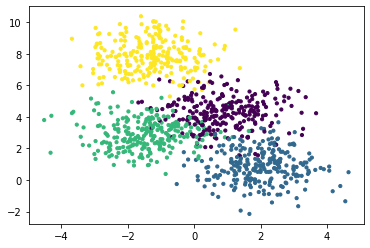

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=4, center_box = [-10,10],
                  random_state=0, cluster_std=1)
plt.scatter(X[:, 0], X[:, 1], s=10,c=y);

In [3]:
# splitsen in test set en training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =0)

# ---------------------------------------------------
# normaliseren van de input data

#scaler = StandardScaler()

#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

#----------------------------------------------------
# one-hot encoding op output
y_train = to_categorical(y_train)
print(y_train)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [4]:
# NN parameters

batch_size = 32
epochs = 100
epochlist = np.linspace(1, epochs, epochs)
dropoutrate = 0.0
input_dim = X_train.shape[1]
activation_hidden = 'relu' # activatiefunctie van de hidden layer neuronen
activation_output = 'sigmoid'# activatie van de output layer neuronen
initializer = 'RandomUniform' # type van kernel intializer
SGD = tf.keras.optimizers.SGD(lr=0.3)
adam = tf.optimizers.Adam()
model = Sequential()
model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(y_train.shape[1], kernel_initializer=initializer,activation=activation_output))


model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

# train the model

history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)

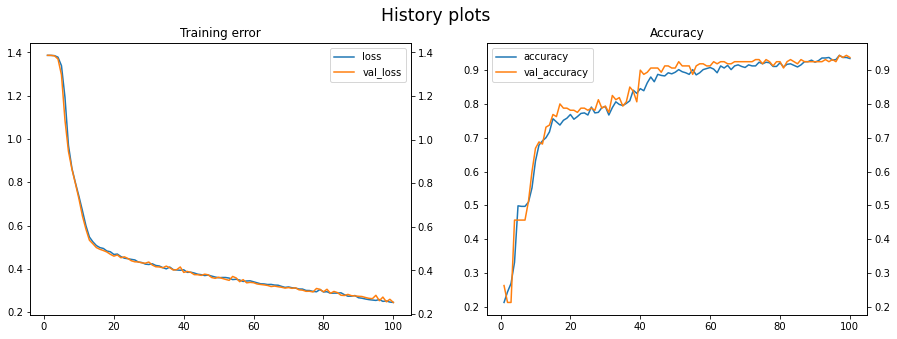

In [5]:
def history_plotter(epochs, metric1='loss', metric2='accuracy'):
    metric1val = f'val_{metric1}'
    metric2val = f'val_{metric2}'
    epochlist = np.linspace(1, epochs, epochs)
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('History plots', size='xx-large')
    colors = sns.color_palette()
    
    sns.lineplot(x=epochlist, y=history.history[metric1], color=colors[0], ax=ax1, label=metric1, legend=False)
    ax1.title.set_text('Training error')
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    ax2 = ax1.twinx()
    sns.lineplot(x=epochlist, y=history.history[metric1val], color=colors[1], ax=ax2, label=metric1val, legend=False)
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_a = lines_1 + lines_2
    labels_a = labels_1 + labels_2
    ax2.legend(lines_a, labels_a, loc=0)
    
    sns.lineplot(x=epochlist, y=history.history[metric2], color=colors[0], ax=ax3, label=metric2, legend=False)
    ax3.title.set_text('Accuracy')
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    ax4 = ax3.twinx()
    sns.lineplot(x=epochlist, y=history.history[metric2val], color=colors[1], ax=ax4, label=metric2val, legend=False);
    lines_4, labels_4 = ax4.get_legend_handles_labels()
    lines_b = lines_3 + lines_4
    labels_b = labels_3 + labels_4
    ax4.legend(lines_b, labels_b, loc=0)
    
    plt.show()

history_plotter(epochs, metric1='loss', metric2='accuracy')


(-4.14847939486199, 12.251520605138023)

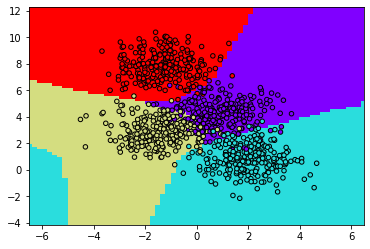

In [6]:
# Plotten van de decision boundary

h = 0.2
x1_min = X[:,0].min()-2
x1_max = X[:,0].max()+2
x2_min = X[:,1].min()-2
x2_max = X[:,1].max()+2
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),np.arange(x2_min, x2_max, h))

xy = np.vstack([xx.ravel(), yy.ravel()]).T

xys = xy
#xys = scaler.transform(xy)

predict_x = model.predict(xys)
Zn = np.argmax(predict_x, axis=1).reshape(xx.shape)

plt.pcolormesh(xx,yy, Zn,cmap='rainbow')
plt.scatter(X[:, 0], X[:, 1], c=y,edgecolor='k', s=20,cmap='rainbow')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())



              precision    recall  f1-score   support

           0       0.79      0.77      0.78        44
           1       0.98      0.96      0.97        51
           2       0.86      0.88      0.87        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200

Accuracy: 	90.5%



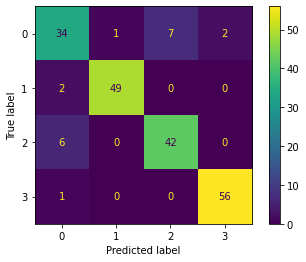

In [7]:
# Testen met test set
y_pred = np.argmax(model.predict(X_test), axis=-1)
print('\n')
print(classification_report(y_test, y_pred))
print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

### Opdrachten warm-up oefening

1. Varieer bij SGD de learning rate en onderzoek wat er gebeurt wanneer deze te klein of te groot wordt. Wat is de invloed van normalisatie op de learning rate en de plot van de model loss?
2. Probeer verschillende optimizers uit: SGD, Adam, RMSProp, Adagrad, ... (https://keras.io/optimizers/). Kijk wat er gebeurt in termen van de model loss curve en de accuracy.
3. Kies een dropoutrate van 0.8. Verklaar wat er gebeurt. Zet nadien de dropout rate terug naar 0.0
4. Verhoog het aantal neuronen in de hidden layers. Wat is de invloed daarvan?
5. Verhoog het aantal hidden layers. Wat merk je? Bekijk de decision boundary. Controleer of je met overfitting te maken hebt. Verhoog nu de dropout rate. Verklaar wat er gebeurt.
6. Bespreek de invloed van batchnormalization.
7. Probeer verschillende activatiefuncties uit bij de hidden layers. (https://keras.io/activations/)
8. Probeer verschillende initializers. (https://keras.io/initializers/)
9. Doe hyperparameter tuning via grid search, random search en bayes optimization. Wat is de finale accuracy die je haalt op de test set?


### Uitwerking warm-up oefening
Hieronder zal elke puntje uit de opdracht een voor een worden uitgewerkt.

#### Variatie van de learning rate bij SGD en invloed van normalisatie
**Opdracht**  
Varieer bij SGD de learning rate en onderzoek wat er gebeurt wanneer deze te klein of te groot wordt. Wat is de invloed van normalisatie op de learning rate en de plot van de model loss?

MODEL MET LEARNING RATE 1e-05 ZONDER NORMALISATIE


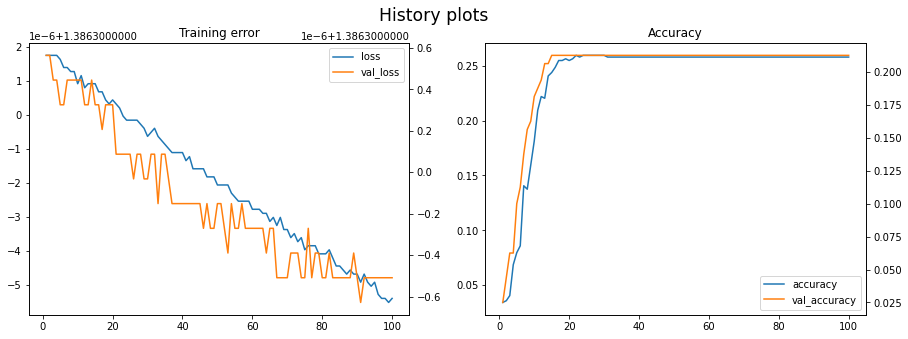



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.26      1.00      0.41        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.26       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.07      0.26      0.10       200

Accuracy: 	25.5%



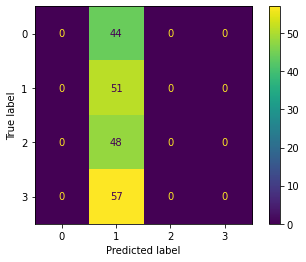



MODEL MET LEARNING RATE 0.001 ZONDER NORMALISATIE


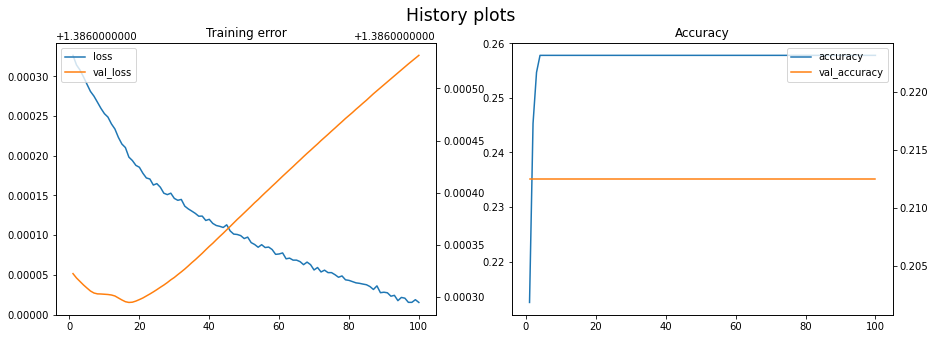



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.26      1.00      0.41        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.26       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.07      0.26      0.10       200

Accuracy: 	25.5%



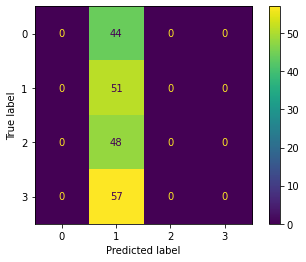



MODEL MET LEARNING RATE 0.1 ZONDER NORMALISATIE


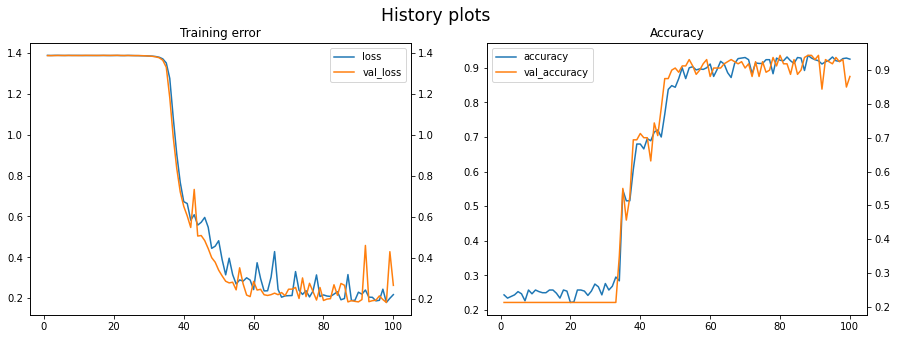



              precision    recall  f1-score   support

           0       0.81      0.77      0.79        44
           1       0.96      0.98      0.97        51
           2       0.95      0.83      0.89        48
           3       0.89      1.00      0.94        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.90       200

Accuracy: 	90.5%



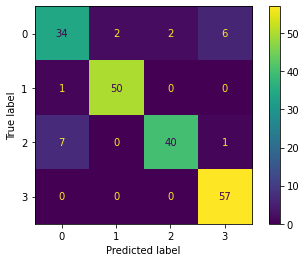



MODEL MET LEARNING RATE 0.3 ZONDER NORMALISATIE


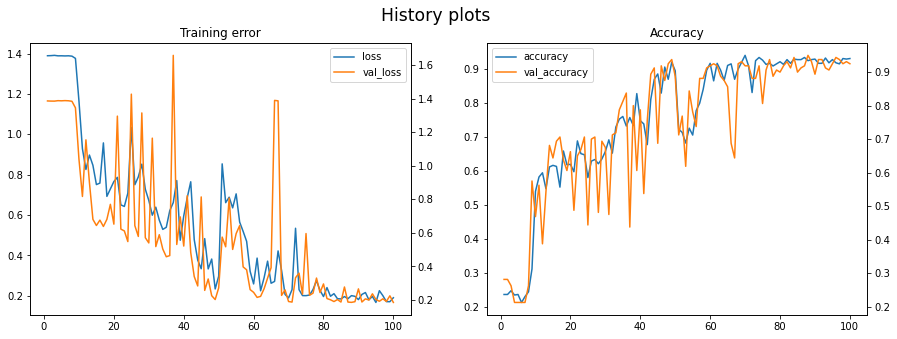



              precision    recall  f1-score   support

           0       0.81      0.77      0.79        44
           1       0.98      0.96      0.97        51
           2       0.83      0.92      0.87        48
           3       0.98      0.95      0.96        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200

Accuracy: 	90.5%



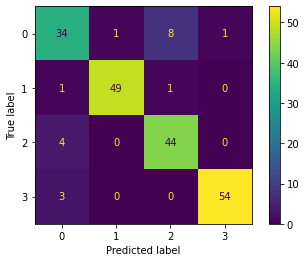



MODEL MET LEARNING RATE 0.5 ZONDER NORMALISATIE


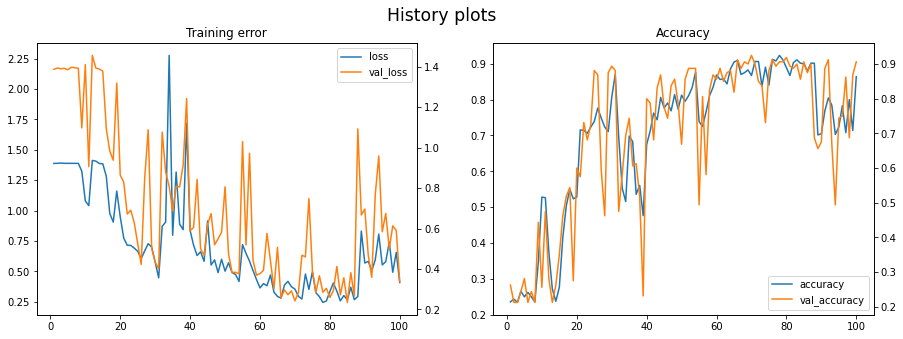



              precision    recall  f1-score   support

           0       0.83      0.68      0.75        44
           1       0.98      0.94      0.96        51
           2       0.83      0.92      0.87        48
           3       0.90      0.98      0.94        57

    accuracy                           0.89       200
   macro avg       0.89      0.88      0.88       200
weighted avg       0.89      0.89      0.89       200

Accuracy: 	89.0%



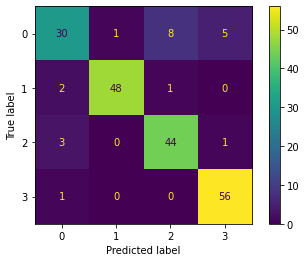



MODEL MET LEARNING RATE 0.7 ZONDER NORMALISATIE


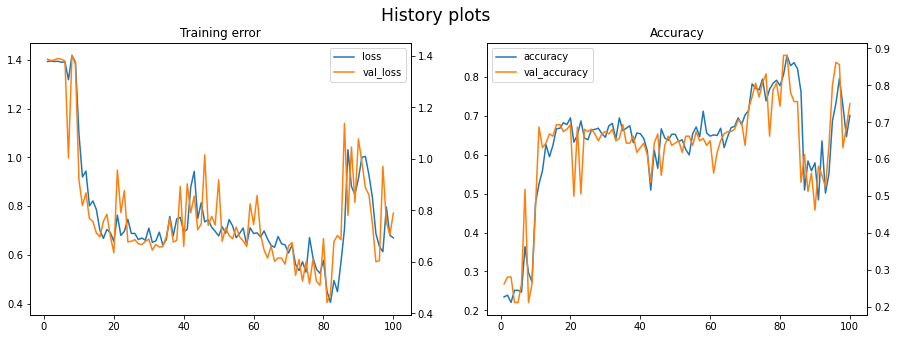



              precision    recall  f1-score   support

           0       0.59      0.82      0.69        44
           1       0.98      0.92      0.95        51
           2       0.58      0.73      0.65        48
           3       0.55      0.30      0.39        57

    accuracy                           0.68       200
   macro avg       0.68      0.69      0.67       200
weighted avg       0.68      0.68      0.66       200

Accuracy: 	67.5%



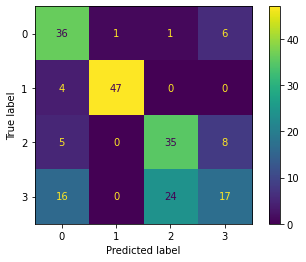



MODEL MET LEARNING RATE 0.9 ZONDER NORMALISATIE


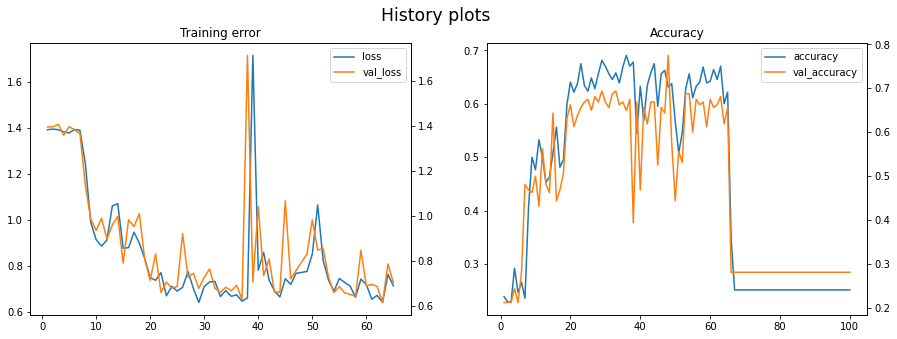



              precision    recall  f1-score   support

           0       0.22      1.00      0.36        44
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.22       200
   macro avg       0.06      0.25      0.09       200
weighted avg       0.05      0.22      0.08       200

Accuracy: 	22.0%



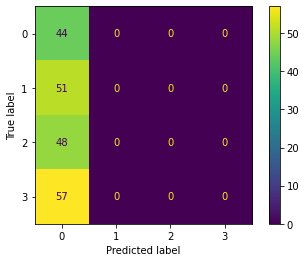



MODEL MET LEARNING RATE 1 ZONDER NORMALISATIE


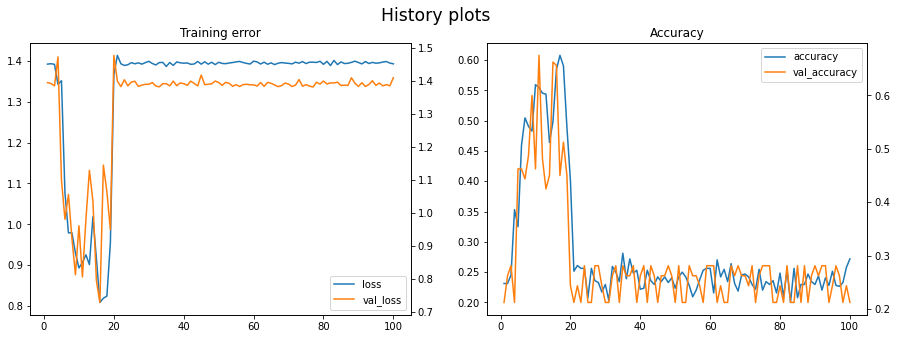



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.26      1.00      0.41        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.26       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.07      0.26      0.10       200

Accuracy: 	25.5%



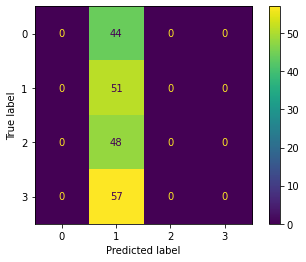



MODEL MET LEARNING RATE 10 ZONDER NORMALISATIE


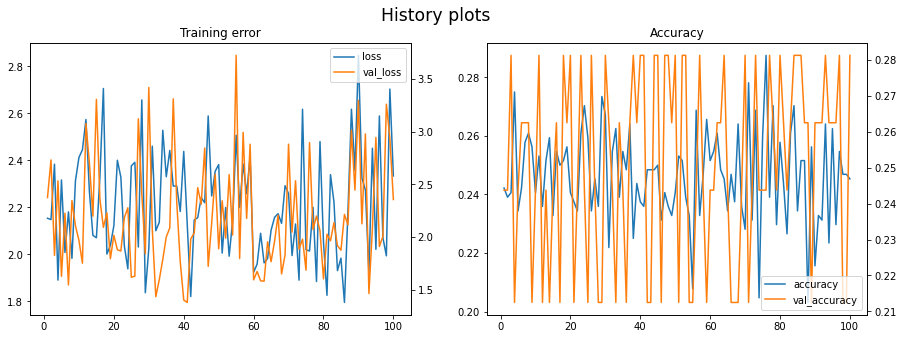



              precision    recall  f1-score   support

           0       0.22      1.00      0.36        44
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.22       200
   macro avg       0.06      0.25      0.09       200
weighted avg       0.05      0.22      0.08       200

Accuracy: 	22.0%



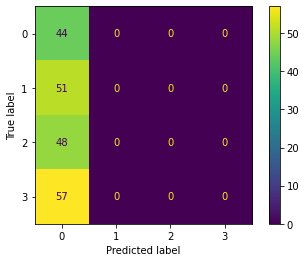



MODEL MET LEARNING RATE 1000 ZONDER NORMALISATIE


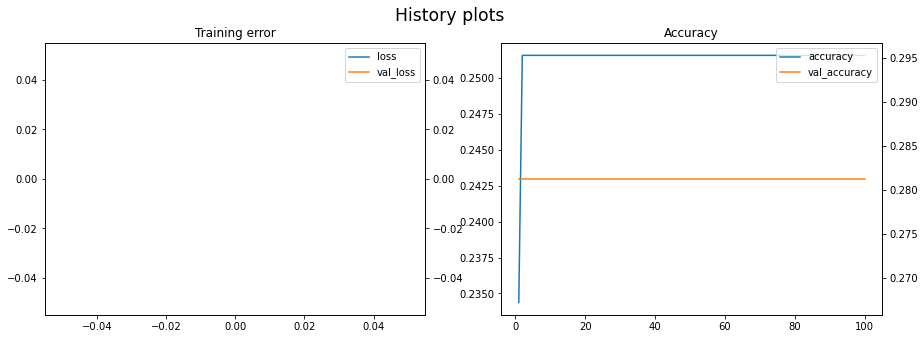



              precision    recall  f1-score   support

           0       0.22      1.00      0.36        44
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.22       200
   macro avg       0.06      0.25      0.09       200
weighted avg       0.05      0.22      0.08       200

Accuracy: 	22.0%



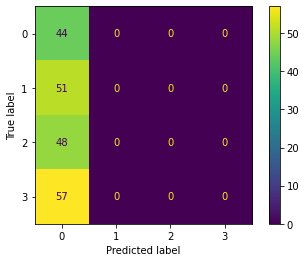

In [8]:
# Uitwerking van de opdrachten
## Learning rate
lrs = [0.00001, 0.001, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 10, 1000]
for l in lrs:
    header = f'MODEL MET LEARNING RATE {l} ZONDER NORMALISATIE'
    headlen = len(header)
    headline = '=' * headlen
    print(header)
    print(headline)
    batch_size = 32
    epochs = 100
    dropoutrate = 0.0
    input_dim = X_train.shape[1]
    activation_hidden = 'relu' # activatiefunctie van de hidden layer neuronen
    activation_output = 'sigmoid'# activatie van de output layer neuronen
    initializer = 'RandomUniform' # type van kernel intializer
    SGD = tf.keras.optimizers.SGD(lr=l)
    adam = tf.optimizers.Adam()
    model = Sequential()
    model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(dropoutrate))
    #model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
    #model.add(Dropout(dropoutrate))
    model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(dropoutrate))
    model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(dropoutrate))
    model.add(Dense(y_train.shape[1], kernel_initializer=initializer,activation=activation_output))
    model.compile(loss='categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2,verbose=0)
    
    history_plotter(epochs, metric1='loss', metric2='accuracy')
    
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print('\n')
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('\n')

MODEL MET LEARNING RATE 1e-05 MET NORMALISATIE


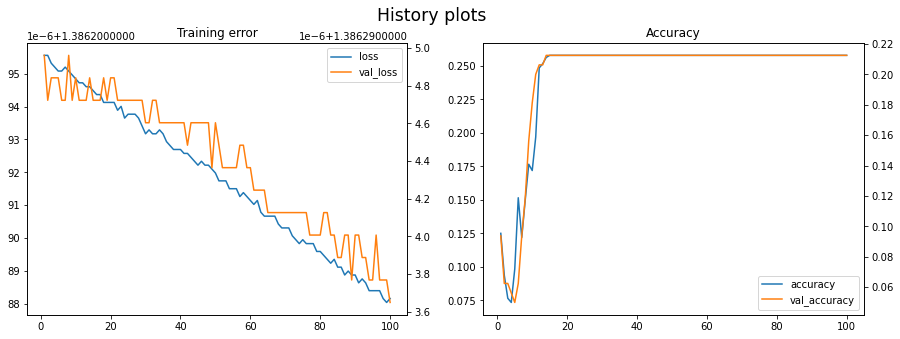



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.26      1.00      0.41        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.26       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.07      0.26      0.10       200

Accuracy: 	25.5%



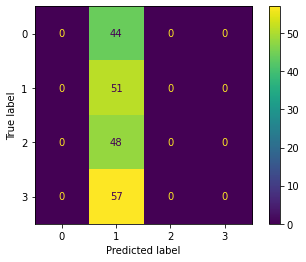



MODEL MET LEARNING RATE 0.001 MET NORMALISATIE


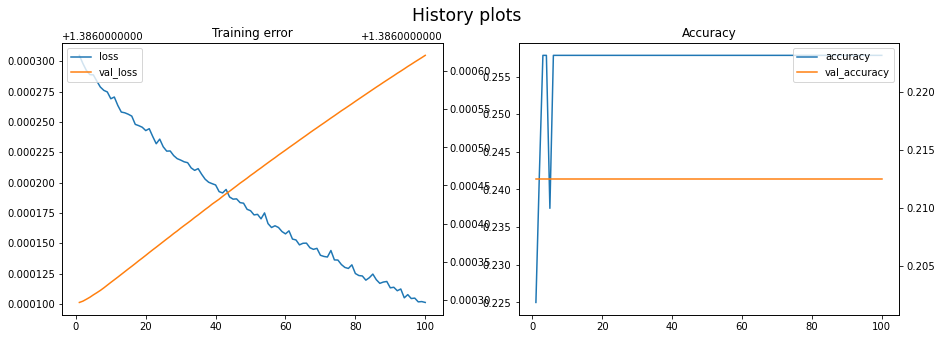



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.26      1.00      0.41        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.26       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.07      0.26      0.10       200

Accuracy: 	25.5%



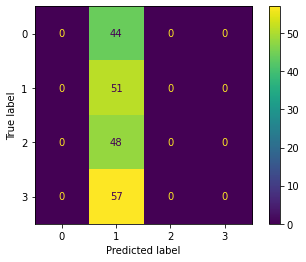



MODEL MET LEARNING RATE 0.1 MET NORMALISATIE


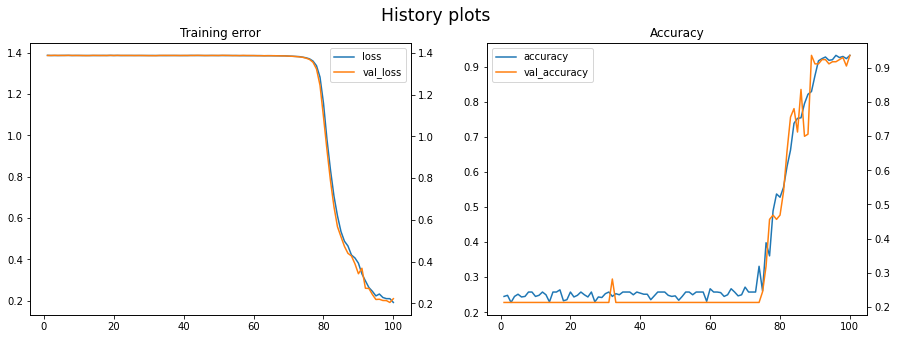



              precision    recall  f1-score   support

           0       0.86      0.68      0.76        44
           1       0.91      0.98      0.94        51
           2       0.84      0.90      0.87        48
           3       0.95      0.98      0.97        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.88       200
weighted avg       0.89      0.90      0.89       200

Accuracy: 	89.5%



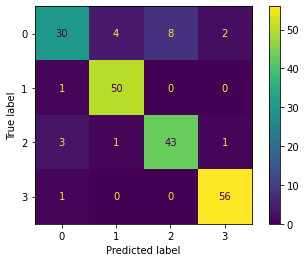



MODEL MET LEARNING RATE 0.3 MET NORMALISATIE


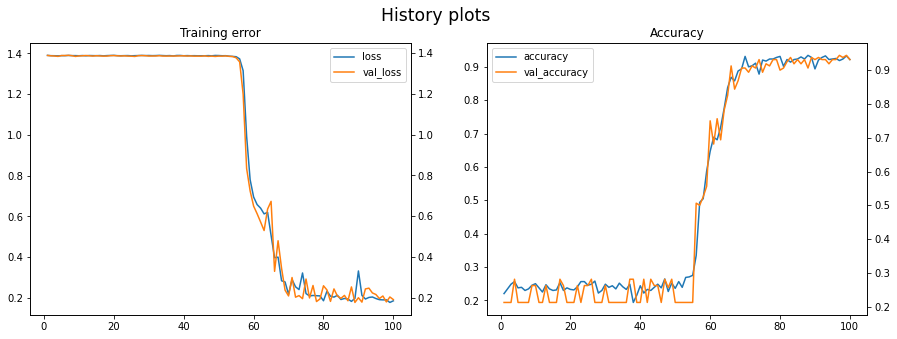



              precision    recall  f1-score   support

           0       0.78      0.80      0.79        44
           1       0.93      0.98      0.95        51
           2       0.91      0.83      0.87        48
           3       0.96      0.96      0.96        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.90      0.90      0.90       200

Accuracy: 	90.0%



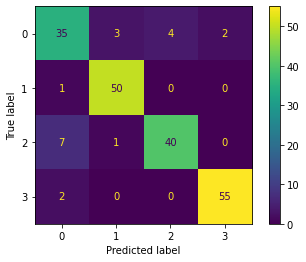



MODEL MET LEARNING RATE 0.5 MET NORMALISATIE


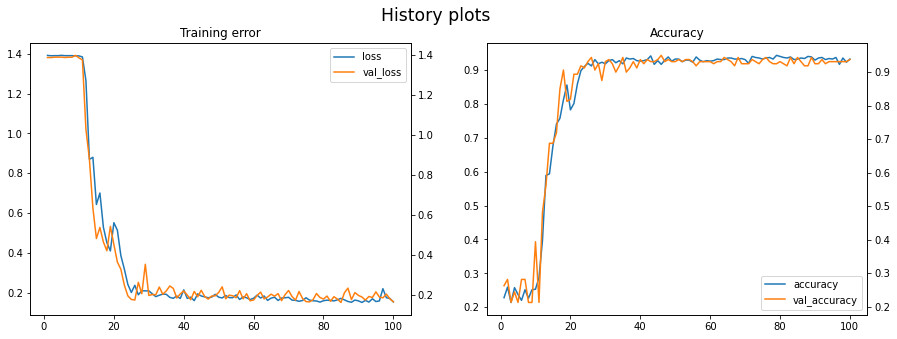



              precision    recall  f1-score   support

           0       0.80      0.80      0.80        44
           1       0.98      0.94      0.96        51
           2       0.86      0.88      0.87        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200

Accuracy: 	90.5%



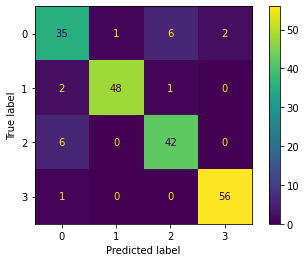



MODEL MET LEARNING RATE 0.7 MET NORMALISATIE


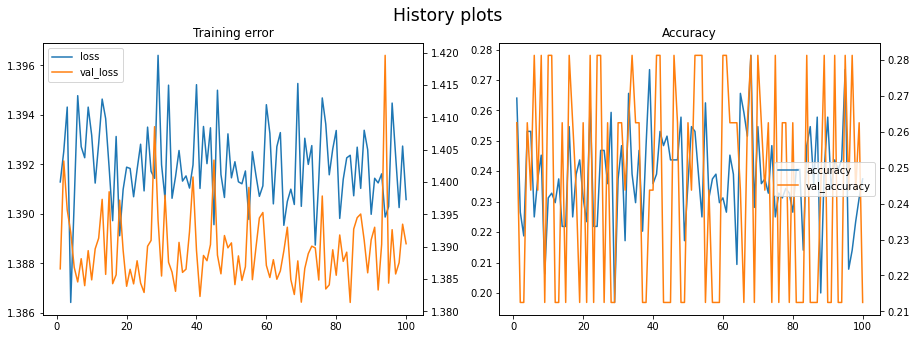



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.26      1.00      0.41        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.26       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.07      0.26      0.10       200

Accuracy: 	25.5%



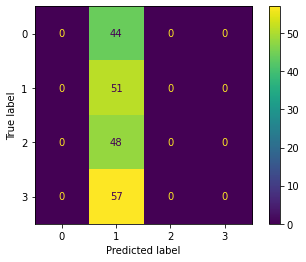



MODEL MET LEARNING RATE 0.9 MET NORMALISATIE


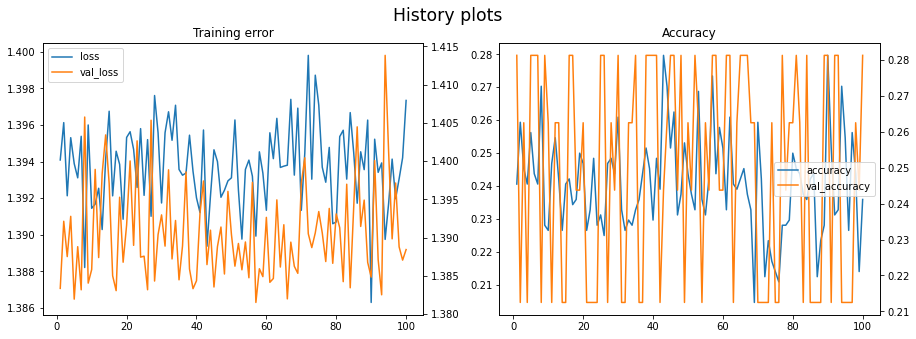



              precision    recall  f1-score   support

           0       0.22      1.00      0.36        44
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.22       200
   macro avg       0.06      0.25      0.09       200
weighted avg       0.05      0.22      0.08       200

Accuracy: 	22.0%



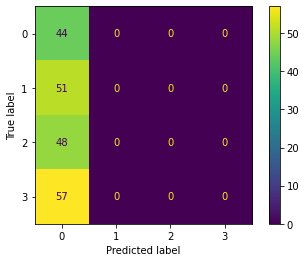



MODEL MET LEARNING RATE 1 MET NORMALISATIE


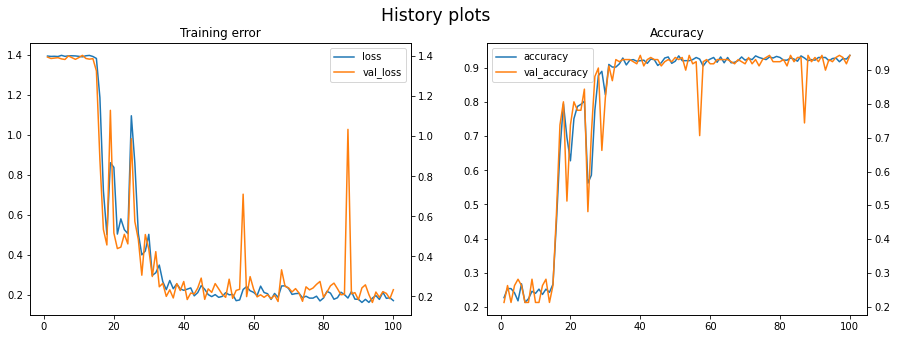



              precision    recall  f1-score   support

           0       0.78      0.70      0.74        44
           1       0.94      0.98      0.96        51
           2       0.81      0.90      0.85        48
           3       0.98      0.93      0.95        57

    accuracy                           0.89       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.89      0.89      0.88       200

Accuracy: 	88.5%



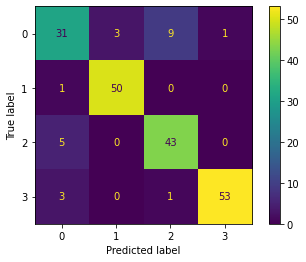



MODEL MET LEARNING RATE 10 MET NORMALISATIE


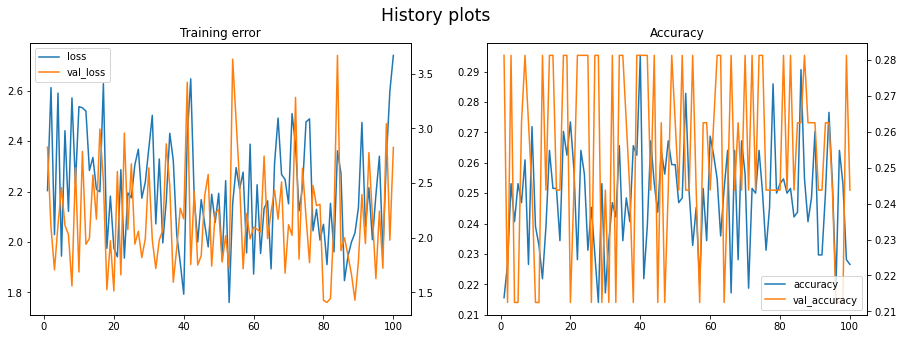



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        48
           3       0.28      1.00      0.44        57

    accuracy                           0.28       200
   macro avg       0.07      0.25      0.11       200
weighted avg       0.08      0.28      0.13       200

Accuracy: 	28.499999999999996%



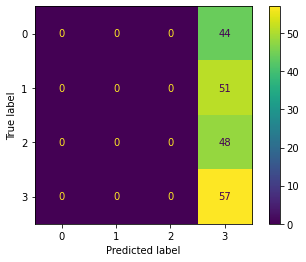



MODEL MET LEARNING RATE 1000 MET NORMALISATIE


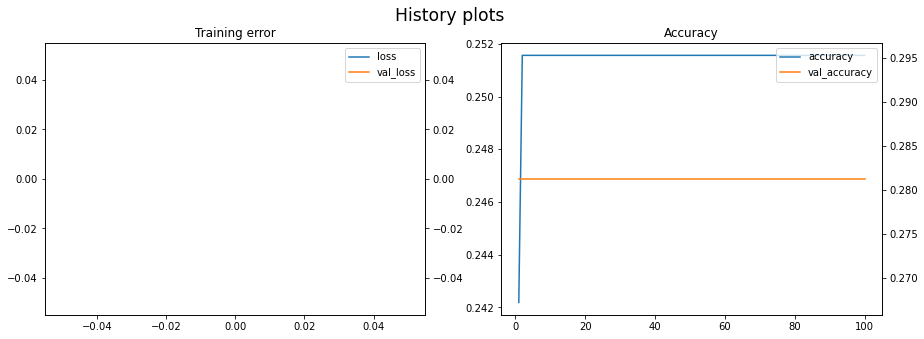



              precision    recall  f1-score   support

           0       0.22      1.00      0.36        44
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.22       200
   macro avg       0.06      0.25      0.09       200
weighted avg       0.05      0.22      0.08       200

Accuracy: 	22.0%



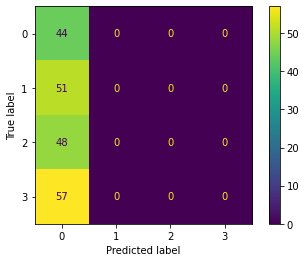

In [9]:
# Variatie van learning rate met normalisatie
scaler = StandardScaler()
scaler.fit(X_train)
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)

for l in lrs:
    header = f'MODEL MET LEARNING RATE {l} MET NORMALISATIE'
    headlen = len(header)
    headline = '=' * headlen
    print(header)
    print(headline)
    batch_size = 32
    epochs = 100
    dropoutrate = 0.0
    input_dim = X_train.shape[1]
    activation_hidden = 'relu' # activatiefunctie van de hidden layer neuronen
    activation_output = 'sigmoid'# activatie van de output layer neuronen
    initializer = 'RandomUniform' # type van kernel intializer
    SGD = tf.keras.optimizers.SGD(lr=l)
    adam = tf.optimizers.Adam()
    model = Sequential()
    model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(dropoutrate))
    #model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
    #model.add(Dropout(dropoutrate))
    model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(dropoutrate))
    model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(dropoutrate))
    model.add(Dense(y_train.shape[1], kernel_initializer=initializer,activation=activation_output))
    model.compile(loss='categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
    
    history = model.fit(X_train_ss, y_train, epochs=epochs, validation_split = 0.2,verbose=0)
    
    history_plotter(epochs, metric1='loss', metric2='accuracy')
    
    y_pred = np.argmax(model.predict(X_test_ss), axis=-1)
    print('\n')
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('\n')

**Conclusie variatie learning rate**  
Bij lage learning rates lijkt het neuraal netwerk niet te leren. De loss functie daalt lineair. Vermoedelijk wordt er geen optimum in de stochastische gradient descent gevonden. Het model voorspelt voor alle waarden slechts een klasse, waardoor de accuracy rond de 1/4 blijft hangen. Bij het gradueel stijgen van de learning rate lijkt de loss-functie wel exponentiële dalingen te kennen (hoe hoger de learning rate, des te sneller de daling inzet), maar stijgt daarna voor de validatieset of blijft op een plateau oscilleren. De accuracy verbetert hier niet. Vermoedelijk is er hier sprake van het bereiken vn lokale optima in stochastische gradient descent, maar wordt het globale optimum niet bereikt.

De beste resultaten worden bereikt met een learning rate van 0.1 en 0.3 waarbij de loss-functie exponentieel daalt en glad plateau bereikt zonder duidelijke tekenen van over- of underfitting. De accuracy is hier 90.5%.

Van zodra de learning rate nog meer wordt verhoogd, begint het plateau opnieuw te oscilleren of de exponentiele daling gaat verloren. Het model begint steeds minder en minder te leren en wijst alle observaties terug toe aan 1 categorie.

Het effect van data-normalisatie laat zich zien in de mogelijkheid om een bredere range van optimale learning rates te gebruiken, maar lijkt het in deze data set een iets hogere learning rate nodig te hebben om de beste en meest vroege exponentiële daling te tonen.

#### Effect van verschillende optimizers
**Opdracht**  
Probeer verschillende optimizers uit: SGD, Adam, RMSProp, Adagrad, ... (https://keras.io/optimizers/). Kijk wat er gebeurt in termen van de model loss curve en de accuracy.b

MODEL MET OPTIMIZER: SGD MET NORMALISATIE


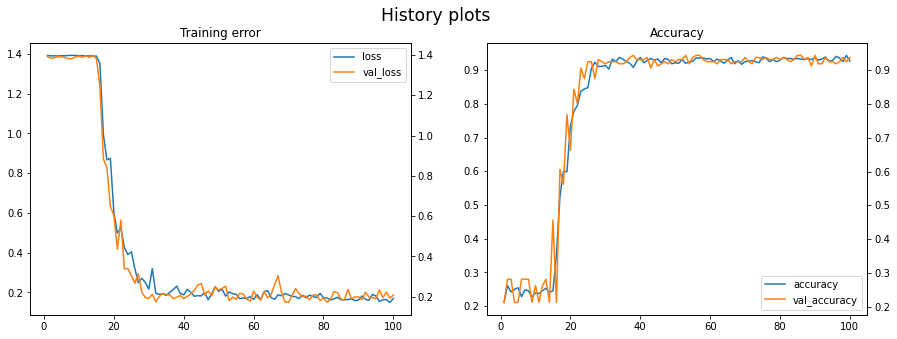



              precision    recall  f1-score   support

           0       0.81      0.77      0.79        44
           1       0.94      0.98      0.96        51
           2       0.87      0.85      0.86        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200

Accuracy: 	90.5%



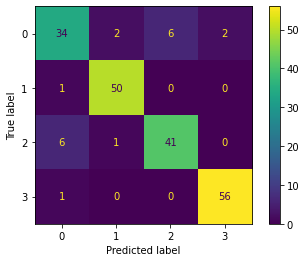



MODEL MET OPTIMIZER: ADAM MET NORMALISATIE


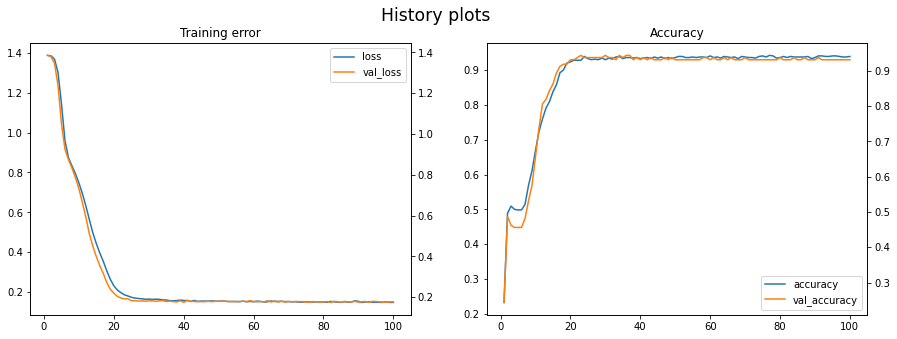



              precision    recall  f1-score   support

           0       0.80      0.73      0.76        44
           1       0.96      0.96      0.96        51
           2       0.82      0.88      0.85        48
           3       0.97      0.98      0.97        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.90      0.89       200

Accuracy: 	89.5%



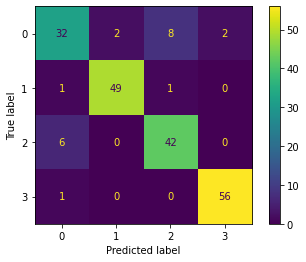



MODEL MET OPTIMIZER: RMSPROP MET NORMALISATIE


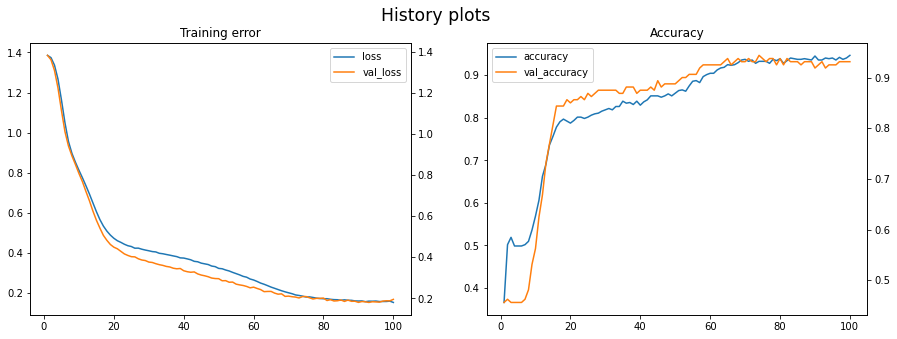



              precision    recall  f1-score   support

           0       0.80      0.73      0.76        44
           1       0.94      0.96      0.95        51
           2       0.84      0.88      0.86        48
           3       0.97      0.98      0.97        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.90      0.89       200

Accuracy: 	89.5%



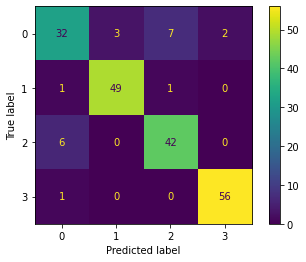



MODEL MET OPTIMIZER: ADADELTA MET NORMALISATIE


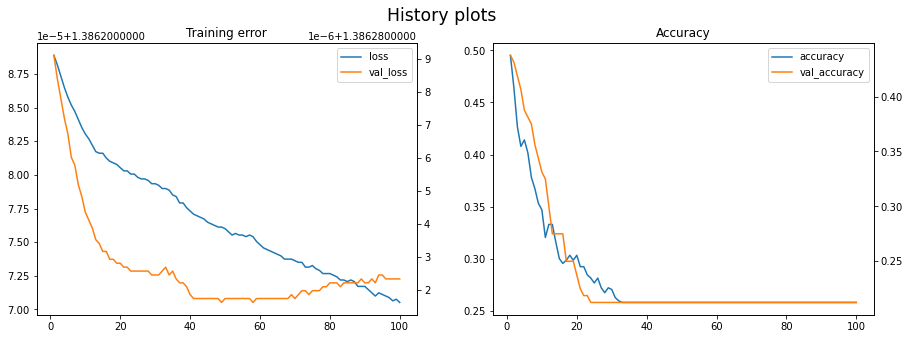



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.26      1.00      0.41        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.26       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.07      0.26      0.10       200

Accuracy: 	25.5%



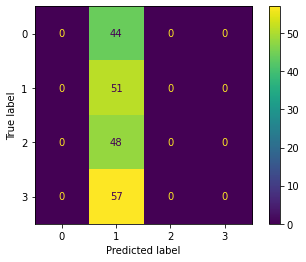



MODEL MET OPTIMIZER: ADAGRAD MET NORMALISATIE


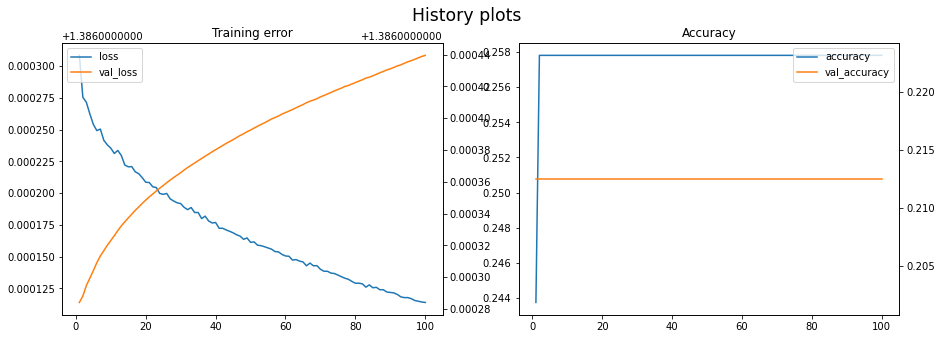



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.26      1.00      0.41        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.26       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.07      0.26      0.10       200

Accuracy: 	25.5%



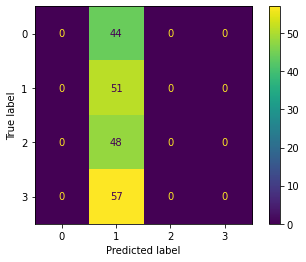



MODEL MET OPTIMIZER: ADAMAX MET NORMALISATIE


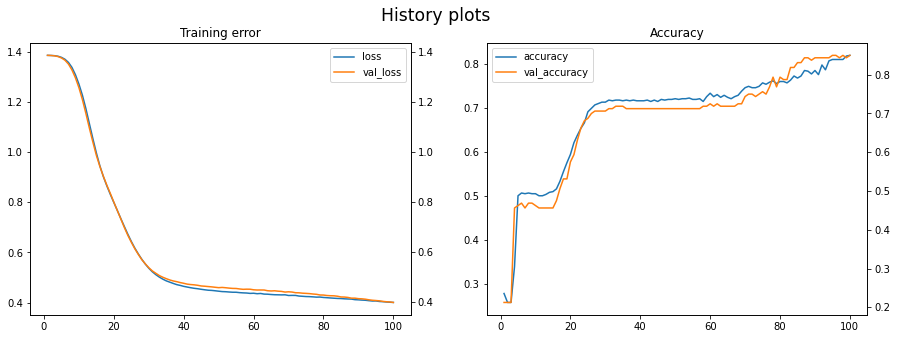



              precision    recall  f1-score   support

           0       0.63      0.75      0.69        44
           1       0.98      0.94      0.96        51
           2       0.73      0.67      0.70        48
           3       1.00      0.96      0.98        57

    accuracy                           0.84       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.85      0.84      0.84       200

Accuracy: 	84.0%



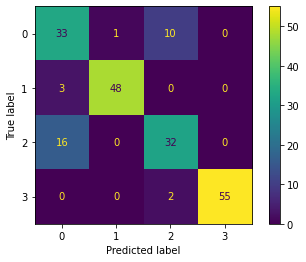



MODEL MET OPTIMIZER: NADAM MET NORMALISATIE


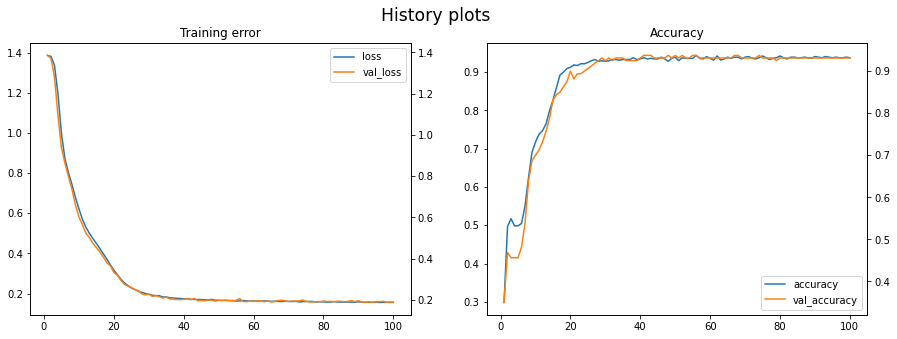



              precision    recall  f1-score   support

           0       0.80      0.80      0.80        44
           1       0.98      0.94      0.96        51
           2       0.86      0.88      0.87        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200

Accuracy: 	90.5%



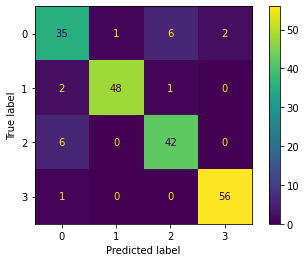



MODEL MET OPTIMIZER: FTRL MET NORMALISATIE


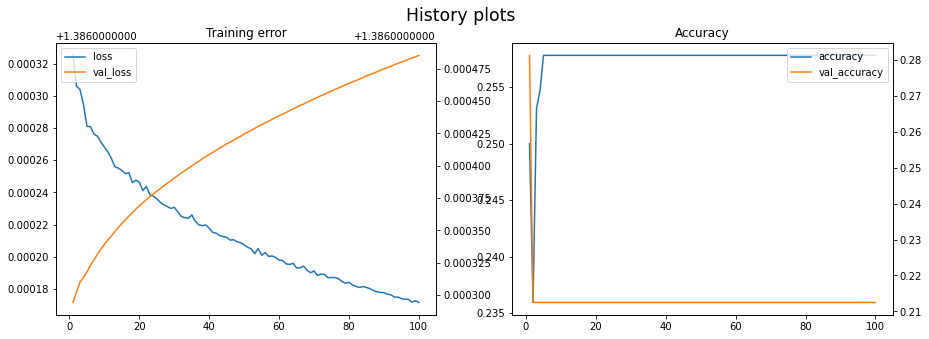



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.26      1.00      0.41        51
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57

    accuracy                           0.26       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.07      0.26      0.10       200

Accuracy: 	25.5%



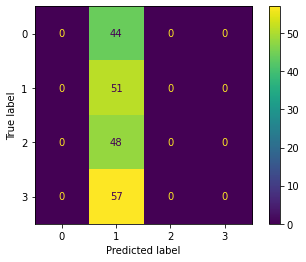

In [10]:
# Uitwerking optimizers
optimizers = {
    'SGD': tf.keras.optimizers.SGD(lr=0.7),
    'Adam': tf.optimizers.Adam(),
    'RMSprop': tf.optimizers.RMSprop(),
    'Adadelta': tf.optimizers.Adadelta(),
    'Adagrad': tf.optimizers.Adagrad(),
    'Adamax': tf.optimizers.Adamax(),
    'Nadam': tf.optimizers.Nadam(),
    'Ftrl': tf.optimizers.Ftrl()        
}

for n,o in optimizers.items():
    header = f'MODEL MET OPTIMIZER: {n.upper()} MET NORMALISATIE'
    headlen = len(header)
    headline = '=' * headlen
    print(header)
    print(headline)
    batch_size = 32
    epochs = 100
    dropoutrate = 0.0
    input_dim = X_train.shape[1]
    activation_hidden = 'relu' # activatiefunctie van de hidden layer neuronen
    activation_output = 'sigmoid'# activatie van de output layer neuronen
    initializer = 'RandomUniform' # type van kernel intializer
    model = Sequential()
    model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(dropoutrate))
    model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(dropoutrate))
    model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(dropoutrate))
    model.add(Dense(y_train.shape[1], kernel_initializer=initializer,activation=activation_output))
    model.compile(loss='categorical_crossentropy', optimizer=o, metrics=['accuracy'])
    
    history = model.fit(X_train_ss, y_train, epochs=epochs, validation_split = 0.2,verbose=0)
    
    history_plotter(epochs, metric1='loss', metric2='accuracy')
    
    y_pred = np.argmax(model.predict(X_test_ss), axis=-1)
    print('\n')
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('\n')

**Conclusie effect van optimizer**  
Alle optimizers hebben een verschillend effect op de loss-functie in termen van de snelheid van meest optimale loss-daling en de steilheid van deze daling. De beste en snelste dalingen worden gezien bij Adam en Nadam. Adamax en RMSprop dalen iets minder steil, maar dalen ook vrij snel. SGD daalt wat later, maar laat hier ook een goede steile daling zien. FTRL en Adagrad laten zien dat de loss-functie voor de validatieset blijft stijgen. Deze modellen leren niets en wijzen alle observaties toe aan 1 categorie. Deze laatste 2 optimizers lijken daarom minder geschikt.

#### Effect van dropoutrate
**Opdracht**  
Kies een dropoutrate van 0.8. Verklaar wat er gebeurt. Zet nadien de dropout rate terug naar 0.0

MODEL MET DROPOUT RATE 0.8 MET NORMALISATIE


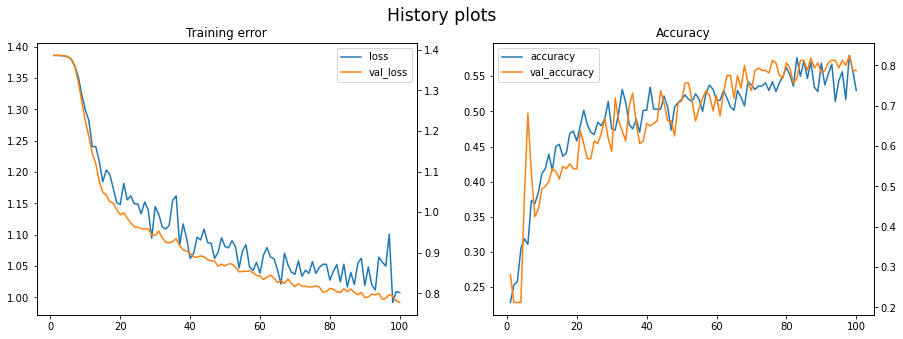



              precision    recall  f1-score   support

           0       0.73      0.55      0.62        44
           1       0.91      0.98      0.94        51
           2       0.59      0.67      0.63        48
           3       0.86      0.88      0.87        57

    accuracy                           0.78       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.78      0.78      0.78       200

Accuracy: 	78.0%



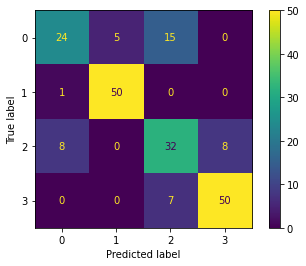



MODEL MET DROPOUT RATE 0.0 MET NORMALISATIE


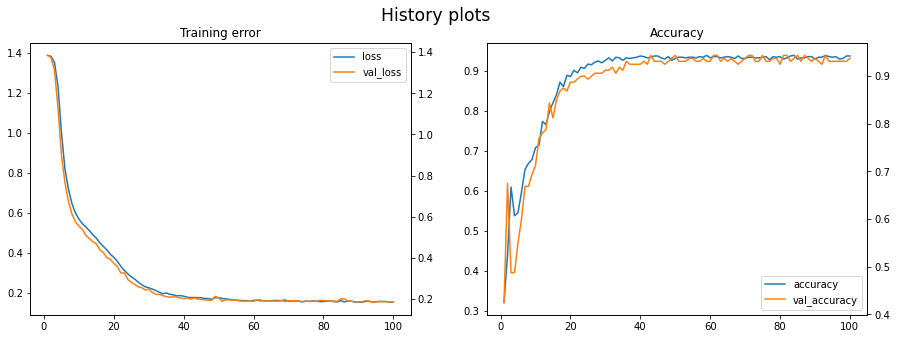



              precision    recall  f1-score   support

           0       0.79      0.77      0.78        44
           1       0.96      0.96      0.96        51
           2       0.86      0.88      0.87        48
           3       0.96      0.96      0.96        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.90      0.90      0.90       200

Accuracy: 	90.0%



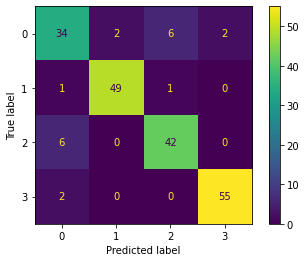

In [11]:
# Uitwerking dropoutrate
rates = [0.8, 0.0]
for rate in rates:
    header = f'MODEL MET DROPOUT RATE {rate} MET NORMALISATIE'
    headlen = len(header)
    headline = '=' * headlen
    print(header)
    print(headline)
    batch_size = 32
    epochs = 100
    input_dim = X_train.shape[1]
    activation_hidden = 'relu' # activatiefunctie van de hidden layer neuronen
    activation_output = 'sigmoid'# activatie van de output layer neuronen
    initializer = 'RandomUniform' # type van kernel intializer
    SGD = tf.keras.optimizers.SGD(lr=l)
    adam = tf.optimizers.Adam()
    model = Sequential()
    model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(rate))
    #model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
    #model.add(Dropout(dropoutrate))
    model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(rate))
    model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(rate))
    model.add(Dense(y_train.shape[1], kernel_initializer=initializer,activation=activation_output))
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2,verbose=0)
    
    history_plotter(epochs, metric1='loss', metric2='accuracy')
    
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print('\n')
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('\n')

**Conclusie invloed dropout**  
Bij de extreme drop out van 0.8 lijkt het model trager te leren en treedt er oscillatie op. Het lijkt er ook op dat het model nog niet klaar is met leren na 100 epochs. In dit model is er onderfitting ontstaan. Bij het verwijderen van de drop out komt dit niet meer voor. Het model leert opnieuw goed zonder overfitting of onderfitting.

#### Invloed aantal neuronen
**Opdracht**  
Verhoog het aantal neuronen in de hidden layers. Wat is de invloed daarvan?

MODEL MET 20 NEURONEN PER LAAG MET NORMALISATIE


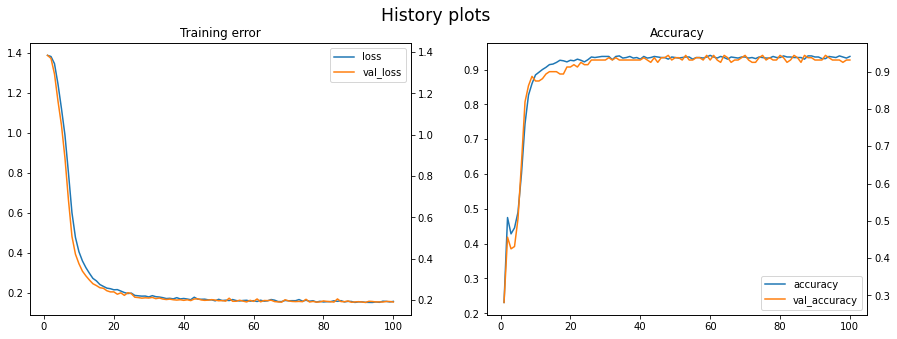



              precision    recall  f1-score   support

           0       0.82      0.82      0.82        44
           1       0.98      0.96      0.97        51
           2       0.88      0.88      0.88        48
           3       0.97      0.98      0.97        57

    accuracy                           0.92       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.92      0.92      0.91       200

Accuracy: 	91.5%



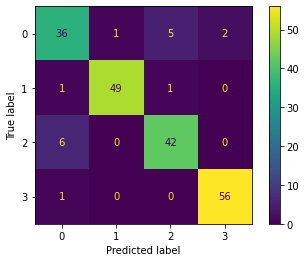



MODEL MET 50 NEURONEN PER LAAG MET NORMALISATIE


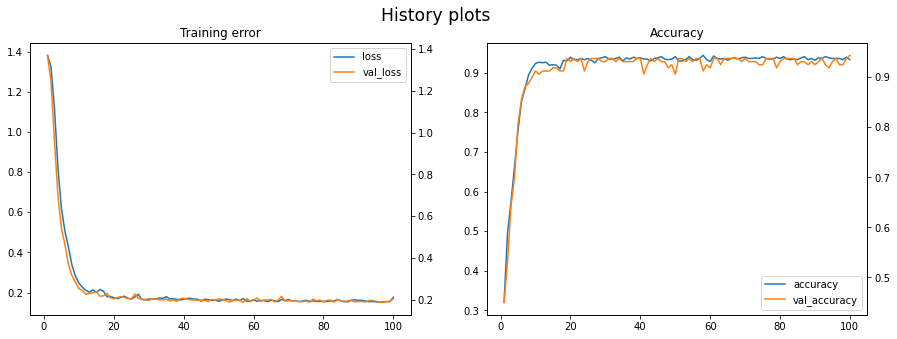



              precision    recall  f1-score   support

           0       0.71      0.77      0.74        44
           1       0.94      0.98      0.96        51
           2       0.84      0.88      0.86        48
           3       1.00      0.86      0.92        57

    accuracy                           0.88       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.88      0.88      0.88       200

Accuracy: 	87.5%



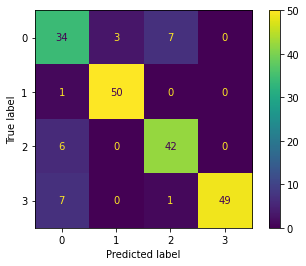



MODEL MET 100 NEURONEN PER LAAG MET NORMALISATIE


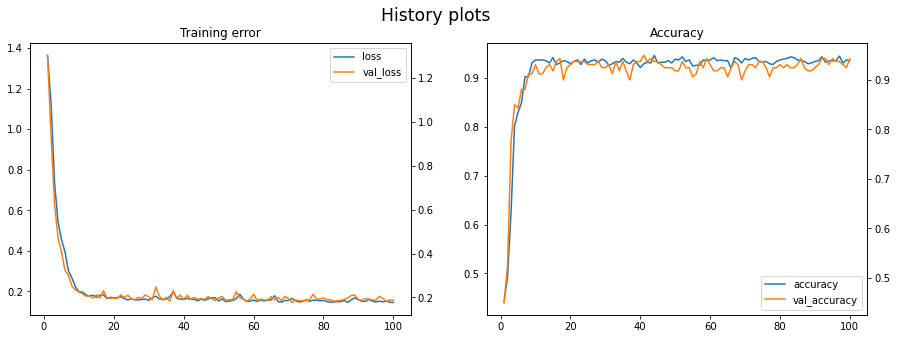



              precision    recall  f1-score   support

           0       0.82      0.73      0.77        44
           1       0.94      0.96      0.95        51
           2       0.83      0.92      0.87        48
           3       0.98      0.96      0.97        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.90      0.90      0.90       200

Accuracy: 	90.0%



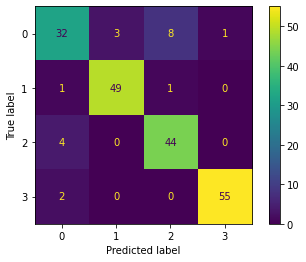



MODEL MET 250 NEURONEN PER LAAG MET NORMALISATIE


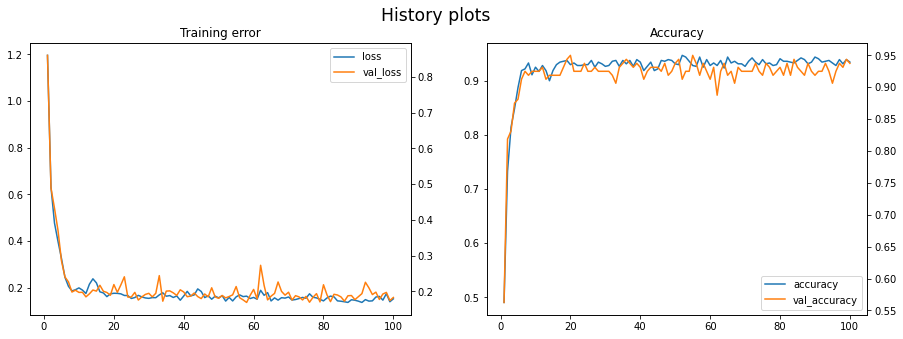



              precision    recall  f1-score   support

           0       0.79      0.70      0.75        44
           1       0.93      0.98      0.95        51
           2       0.83      0.92      0.87        48
           3       0.98      0.93      0.95        57

    accuracy                           0.89       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.89      0.89      0.89       200

Accuracy: 	89.0%



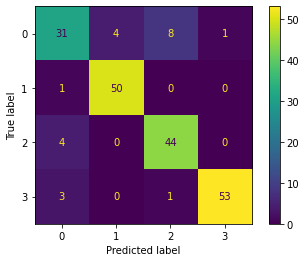



MODEL MET 1000 NEURONEN PER LAAG MET NORMALISATIE


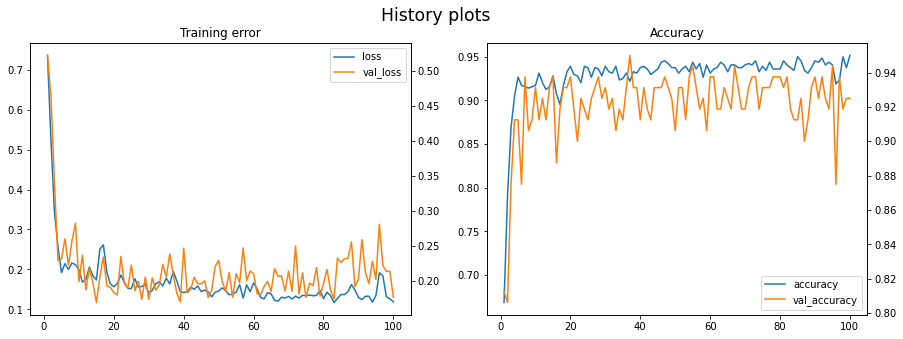



              precision    recall  f1-score   support

           0       0.80      0.73      0.76        44
           1       0.94      0.98      0.96        51
           2       0.86      0.88      0.87        48
           3       0.97      0.98      0.97        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.90      0.90      0.90       200

Accuracy: 	90.0%



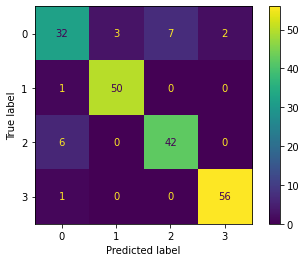

In [12]:
# Uitwerking invloed aantal neuronen
neurons = [20, 50, 100, 250, 1000]
for neuron in neurons:
    header = f'MODEL MET {neuron} NEURONEN PER LAAG MET NORMALISATIE'
    headlen = len(header)
    headline = '=' * headlen
    print(header)
    print(headline)
    batch_size = 32
    epochs = 100
    input_dim = X_train.shape[1]
    activation_hidden = 'relu' # activatiefunctie van de hidden layer neuronen
    activation_output = 'sigmoid'# activatie van de output layer neuronen
    initializer = 'RandomUniform' # type van kernel intializer
    SGD = tf.keras.optimizers.SGD(lr=l)
    adam = tf.optimizers.Adam()
    model = Sequential()
    model.add(Dense(neuron, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(0.0))
    #model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
    #model.add(Dropout(dropoutrate))
    model.add(Dense(neuron, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(0.0))
    model.add(Dense(neuron, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(0.0))
    model.add(Dense(y_train.shape[1], kernel_initializer=initializer,activation=activation_output))
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2,verbose=0)
    
    history_plotter(epochs, metric1='loss', metric2='accuracy')
    
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print('\n')
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('\n')

**Conclusie verhogen aantal neuronen**  
Bij een verhoging tot 100 neuronen wordt er weinig effect opgemerkt. De accuracy blijft ongeveer het zelfde (ongeveer 90%). De loss-functies zien er min of meer hetzelfde uit. Van zodra er opnieuw wordt verhoogd, begint het plateau van de loss-functie en van de accuracy-functie te oscilleren en lijkt deze voor de validatie set opnieuw te stijgen of te dalen, respectievelijk. Er begint overfitting op te treden. Op de uiteindelijk test set heeft dit nog geen effect op de accuracy. Deze blijft voorlopig nog 90%.

#### Effect van aantal hidden layers
**Opdracht**  
Verhoog het aantal hidden layers. Wat merk je? Bekijk de decision boundary. Controleer of je met overfitting te maken hebt. Verhoog nu de dropout rate. Verklaar wat er gebeurt.

MODEL MET 3 HIDDEN LAYERS


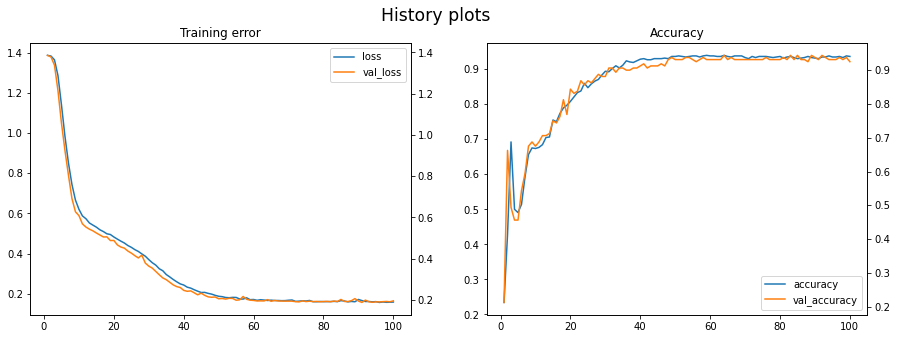

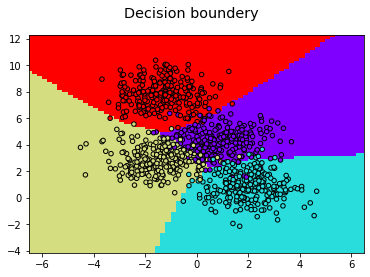



              precision    recall  f1-score   support

           0       0.81      0.80      0.80        44
           1       0.96      0.96      0.96        51
           2       0.87      0.85      0.86        48
           3       0.95      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200

Accuracy: 	90.5%



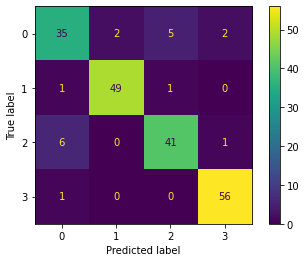

In [17]:
# 3 hidden layers (initieel model)#
###################################
print('MODEL MET 3 HIDDEN LAYERS')
print('=========================')
batch_size = 32
epochs = 100
epochlist = np.linspace(1, epochs, epochs)
dropoutrate = 0.0
input_dim = X_train.shape[1]
activation_hidden = 'relu' # activatiefunctie van de hidden layer neuronen
activation_output = 'sigmoid'# activatie van de output layer neuronen
initializer = 'RandomUniform' # type van kernel intializer
adam = tf.optimizers.Adam()

model = Sequential()
model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(y_train.shape[1], kernel_initializer=initializer,activation=activation_output))

model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)

history_plotter(epochs, metric1='loss', metric2='accuracy')

h = 0.2
x1_min = X[:,0].min()-2
x1_max = X[:,0].max()+2
x2_min = X[:,1].min()-2
x2_max = X[:,1].max()+2
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),np.arange(x2_min, x2_max, h))

xy = np.vstack([xx.ravel(), yy.ravel()]).T

xys = xy
#xys = scaler.transform(xy)

predict_x = model.predict(xys)
Zn = np.argmax(predict_x, axis=1).reshape(xx.shape)

plt.pcolormesh(xx,yy, Zn,cmap='rainbow')
plt.scatter(X[:, 0], X[:, 1], c=y,edgecolor='k', s=20,cmap='rainbow')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.suptitle('Decision boundery', size='x-large')
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=-1)
print('\n')
print(classification_report(y_test, y_pred, zero_division=0))
print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
print('\n')


MODEL MET 6 HIDDEN LAYERS ZONDER DROPOUT


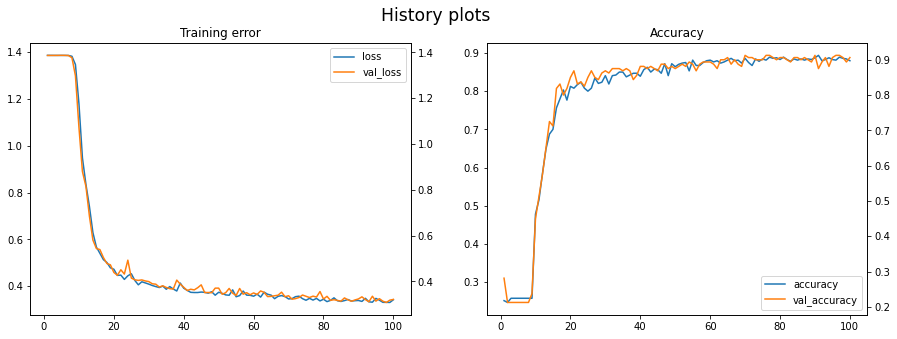

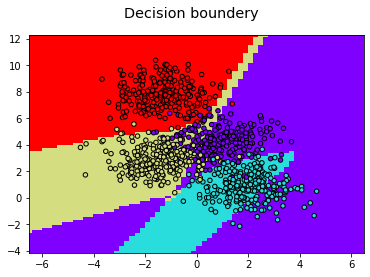



              precision    recall  f1-score   support

           0       0.55      0.66      0.60        44
           1       0.94      0.67      0.78        51
           2       0.79      0.85      0.82        48
           3       0.95      0.98      0.97        57

    accuracy                           0.80       200
   macro avg       0.81      0.79      0.79       200
weighted avg       0.82      0.80      0.80       200

Accuracy: 	80.0%



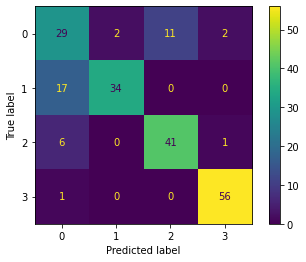

In [26]:
# 6 hidden layers (zonder dropout)#
###################################
print('MODEL MET 6 HIDDEN LAYERS ZONDER DROPOUT')
print('========================================')
batch_size = 32
epochs = 100
epochlist = np.linspace(1, epochs, epochs)
dropoutrate = 0.0
input_dim = X_train.shape[1]
activation_hidden = 'relu' # activatiefunctie van de hidden layer neuronen
activation_output = 'sigmoid'# activatie van de output layer neuronen
initializer = 'RandomUniform' # type van kernel intializer
adam = tf.optimizers.Adam()

model = Sequential()
model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(y_train.shape[1], kernel_initializer=initializer,activation=activation_output))

model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)

history_plotter(epochs, metric1='loss', metric2='accuracy')

h = 0.2
x1_min = X[:,0].min()-2
x1_max = X[:,0].max()+2
x2_min = X[:,1].min()-2
x2_max = X[:,1].max()+2
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),np.arange(x2_min, x2_max, h))

xy = np.vstack([xx.ravel(), yy.ravel()]).T

xys = xy
#xys = scaler.transform(xy)

predict_x = model.predict(xys)
Zn = np.argmax(predict_x, axis=1).reshape(xx.shape)

plt.pcolormesh(xx,yy, Zn,cmap='rainbow')
plt.scatter(X[:, 0], X[:, 1], c=y,edgecolor='k', s=20,cmap='rainbow')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.suptitle('Decision boundery', size='x-large')
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=-1)
print('\n')
print(classification_report(y_test, y_pred, zero_division=0))
print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
print('\n')

MODEL MET 6 HIDDEN LAYERS MET DROPOUT


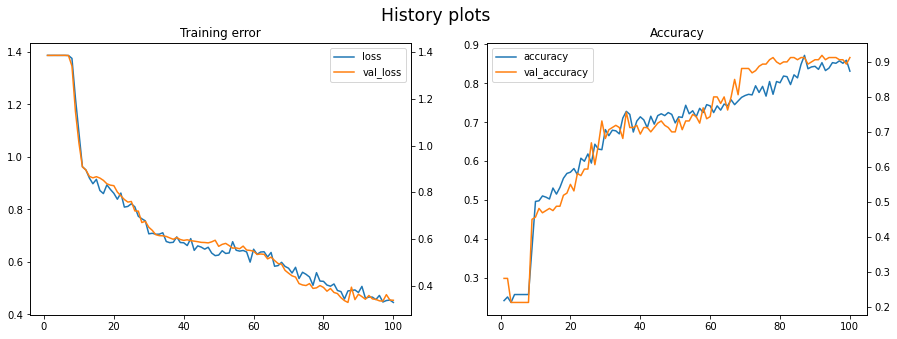

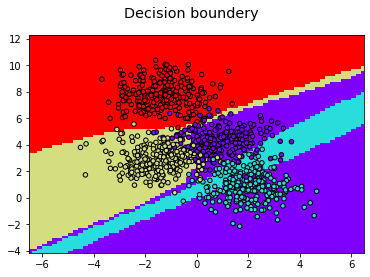



              precision    recall  f1-score   support

           0       0.41      0.66      0.51        44
           1       0.76      0.31      0.44        51
           2       0.84      0.88      0.86        48
           3       0.97      1.00      0.98        57

    accuracy                           0.72       200
   macro avg       0.75      0.71      0.70       200
weighted avg       0.76      0.72      0.71       200

Accuracy: 	72.0%



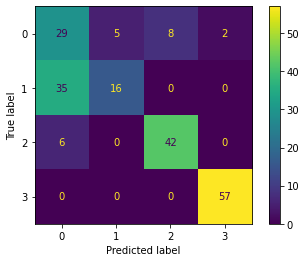

In [27]:
# 6 hidden layers (met dropout)#
###################################
print('MODEL MET 6 HIDDEN LAYERS MET DROPOUT')
print('=====================================')
batch_size = 32
epochs = 100
epochlist = np.linspace(1, epochs, epochs)
dropoutrate = 0.3
input_dim = X_train.shape[1]
activation_hidden = 'relu' # activatiefunctie van de hidden layer neuronen
activation_output = 'sigmoid'# activatie van de output layer neuronen
initializer = 'RandomUniform' # type van kernel intializer
adam = tf.optimizers.Adam()

model = Sequential()
model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
model.add(Dropout(dropoutrate))
model.add(Dense(y_train.shape[1], kernel_initializer=initializer,activation=activation_output))

model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)

history_plotter(epochs, metric1='loss', metric2='accuracy')

h = 0.2
x1_min = X[:,0].min()-2
x1_max = X[:,0].max()+2
x2_min = X[:,1].min()-2
x2_max = X[:,1].max()+2
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),np.arange(x2_min, x2_max, h))

xy = np.vstack([xx.ravel(), yy.ravel()]).T

xys = xy
#xys = scaler.transform(xy)

predict_x = model.predict(xys)
Zn = np.argmax(predict_x, axis=1).reshape(xx.shape)

plt.pcolormesh(xx,yy, Zn,cmap='rainbow')
plt.scatter(X[:, 0], X[:, 1], c=y,edgecolor='k', s=20,cmap='rainbow')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.suptitle('Decision boundery', size='x-large')
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=-1)
print('\n')
print(classification_report(y_test, y_pred, zero_division=0))
print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
print('\n')

**Conclusie aantal hidden layers**  
Bij het verhogen van het aantal hidden layers lijkt er overfitting te ontstaan. Dit is nog niet duidelijk te zien aan de loss-functie, maar de decision bounderies zijn veel scherper en preciezer omschreven. Bij het toevoegen van een drop out rate, lijkt het modelijk trager te leren. De loss-curve daalt later en trager. De decision bounderies zijn nu iets minder scherp omschreven, maar blijven soms nog te nauw (cfr. blauwe categorie)

#### Invloed van batchnormalization
**Opdracht**  
Bespreek de invloed van batchnormalization

MODEL ZONDER BATCHNORMALIZATION


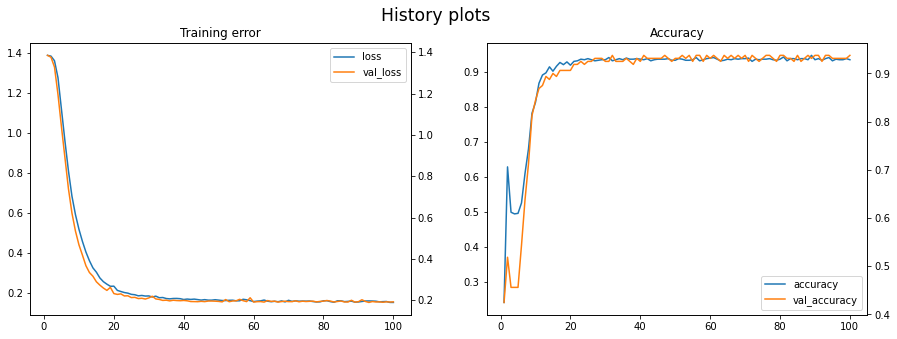

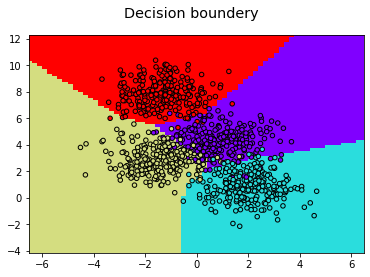



              precision    recall  f1-score   support

           0       0.78      0.80      0.79        44
           1       0.98      0.98      0.98        51
           2       0.84      0.88      0.86        48
           3       0.98      0.93      0.95        57

    accuracy                           0.90       200
   macro avg       0.89      0.90      0.89       200
weighted avg       0.90      0.90      0.90       200

Accuracy: 	90.0%



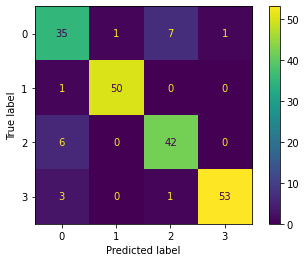



MODEL MET BATCHNORMALIZATION


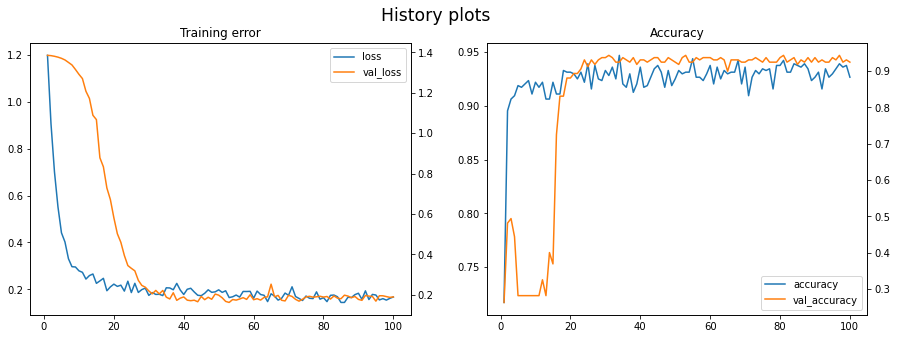

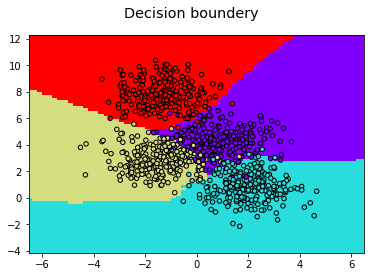



              precision    recall  f1-score   support

           0       0.80      0.82      0.81        44
           1       0.96      0.96      0.96        51
           2       0.86      0.88      0.87        48
           3       1.00      0.96      0.98        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200

Accuracy: 	91.0%



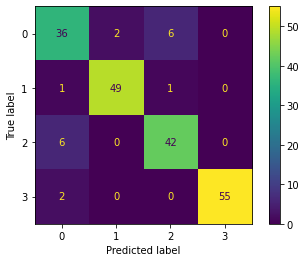

In [29]:
# Uitwerking batchnormalization
batchn = [0, 1]
for b in batchn:
    if b == 0:
        prepos = 'ZONDER'
    else:
        prepos = 'MET'
    header = f'MODEL {prepos} BATCHNORMALIZATION'
    headlen = len(header)
    headline = '=' * headlen
    print(header)
    print(headline)
    
    batch_size = 32
    epochs = 100
    epochlist = np.linspace(1, epochs, epochs)
    dropoutrate = 0.0
    input_dim = X_train.shape[1]
    activation_hidden = 'relu' # activatiefunctie van de hidden layer neuronen
    activation_output = 'sigmoid'# activatie van de output layer neuronen
    initializer = 'RandomUniform' # type van kernel intializer
    adam = tf.optimizers.Adam()
    
    model = Sequential()
    model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(dropoutrate))
    if b == 1:
        model.add(BatchNormalization())
    model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(dropoutrate))
    if b == 1:
        model.add(BatchNormalization())
    model.add(Dense(20, kernel_initializer=initializer,activation=activation_hidden))
    model.add(Dropout(dropoutrate))
    if b == 1:
        model.add(BatchNormalization())
    model.add(Dense(y_train.shape[1], kernel_initializer=initializer,activation=activation_output))
    
    model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
    
    history_plotter(epochs, metric1='loss', metric2='accuracy')
    
    h = 0.2
    x1_min = X[:,0].min()-2
    x1_max = X[:,0].max()+2
    x2_min = X[:,1].min()-2
    x2_max = X[:,1].max()+2
    xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h),np.arange(x2_min, x2_max, h))
    xy = np.vstack([xx.ravel(), yy.ravel()]).T
    
    xys = xy
    #xys = scaler.transform(xy)
    predict_x = model.predict(xys)
    Zn = np.argmax(predict_x, axis=1).reshape(xx.shape)
    
    plt.pcolormesh(xx,yy, Zn,cmap='rainbow')
    plt.scatter(X[:, 0], X[:, 1], c=y,edgecolor='k', s=20,cmap='rainbow')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.suptitle('Decision boundery', size='x-large')
    plt.show()
    
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print('\n')
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('\n')

**Conclusie batchnormalization**  
In bovenstaande uitwerking lijkt het model sneller te leren op de training set bij batchnormalization, maar trager op de validatieset. Voor beide wordt een licht hogere accuracy bereikt, wat zich dan ook uit op de test set. De history curves lijken wel meer te oscilleren, doordat er een vorm van ruis wordt gezet op de data. Batch normalizatie lijkt hierbij de functie van regularisatie te hebben.

#### Effect van verschillende activatiefuncties
**Opdracht**  
Probeer verschillende activatiefuncties uit bij de hidden layers. (https://keras.io/activations/)

MODEL MET HIDDEN ACTIVATION: RELU MET NORMALISATIE


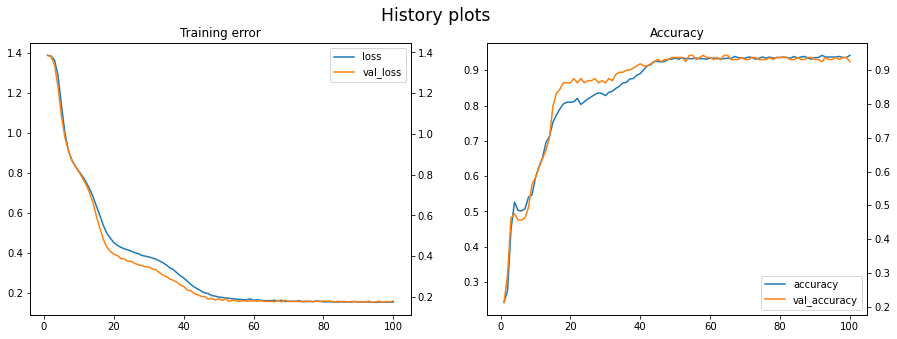



              precision    recall  f1-score   support

           0       0.81      0.77      0.79        44
           1       0.96      0.96      0.96        51
           2       0.86      0.88      0.87        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200

Accuracy: 	90.5%



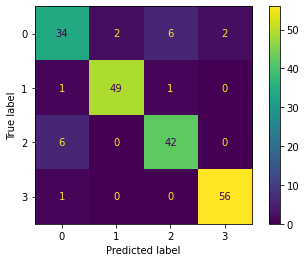



MODEL MET HIDDEN ACTIVATION: SIGMOID MET NORMALISATIE


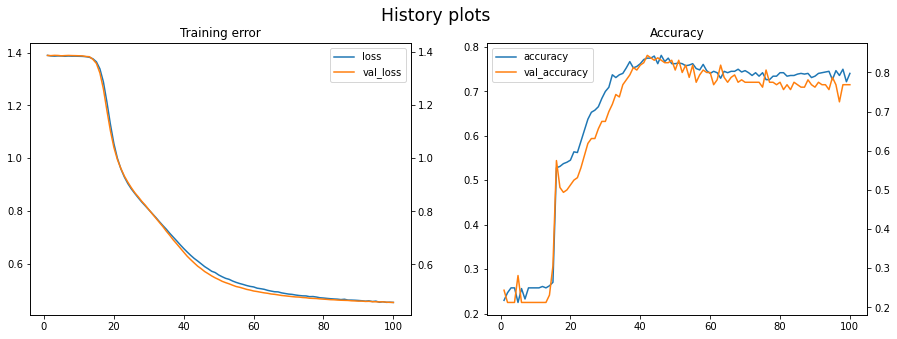



              precision    recall  f1-score   support

           0       0.57      0.36      0.44        44
           1       0.96      0.98      0.97        51
           2       0.60      0.77      0.67        48
           3       0.97      0.98      0.97        57

    accuracy                           0.80       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.79      0.80      0.78       200

Accuracy: 	79.5%



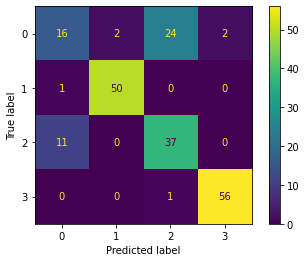



MODEL MET HIDDEN ACTIVATION: SOFTMAX MET NORMALISATIE


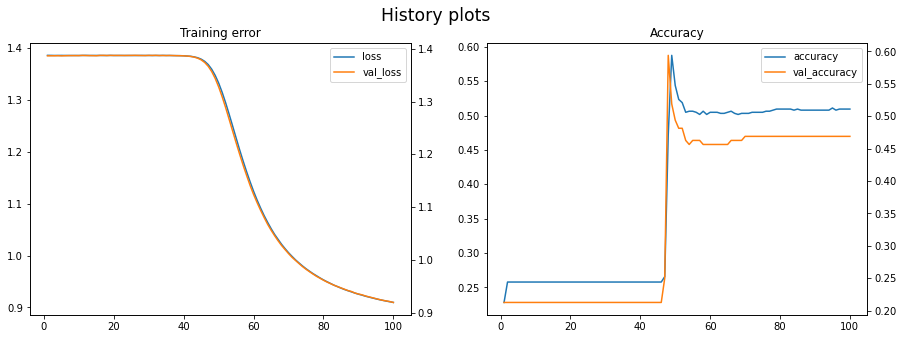



              precision    recall  f1-score   support

           0       0.67      0.05      0.09        44
           1       0.57      1.00      0.73        51
           2       0.17      0.02      0.04        48
           3       0.52      0.93      0.67        57

    accuracy                           0.54       200
   macro avg       0.48      0.50      0.38       200
weighted avg       0.48      0.54      0.40       200

Accuracy: 	53.5%



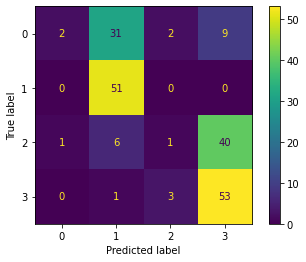



MODEL MET HIDDEN ACTIVATION: SOFTPLUS MET NORMALISATIE


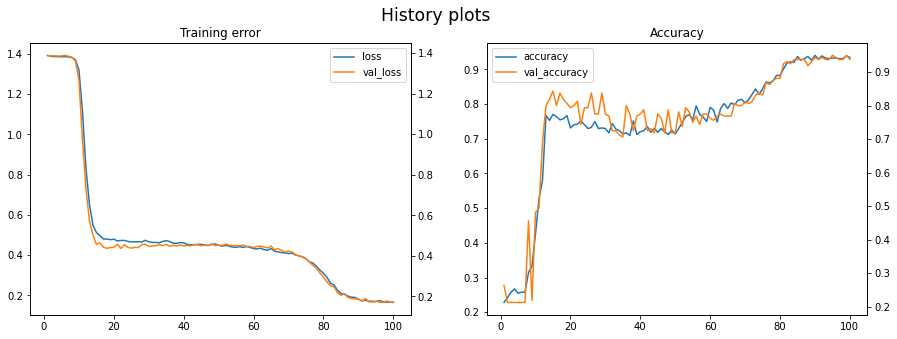



              precision    recall  f1-score   support

           0       0.87      0.75      0.80        44
           1       0.98      0.96      0.97        51
           2       0.83      0.92      0.87        48
           3       0.97      1.00      0.98        57

    accuracy                           0.92       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.92      0.92      0.91       200

Accuracy: 	91.5%



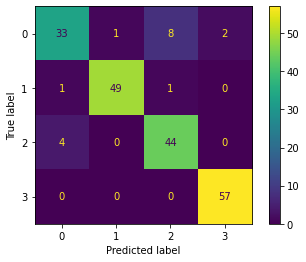



MODEL MET HIDDEN ACTIVATION: SOFTSIGN MET NORMALISATIE


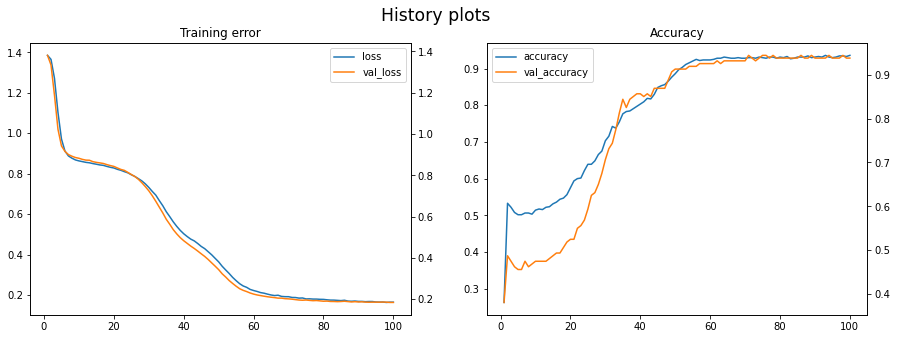



              precision    recall  f1-score   support

           0       0.81      0.77      0.79        44
           1       0.96      0.96      0.96        51
           2       0.86      0.88      0.87        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200

Accuracy: 	90.5%



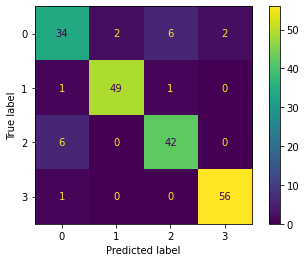



MODEL MET HIDDEN ACTIVATION: TANH MET NORMALISATIE


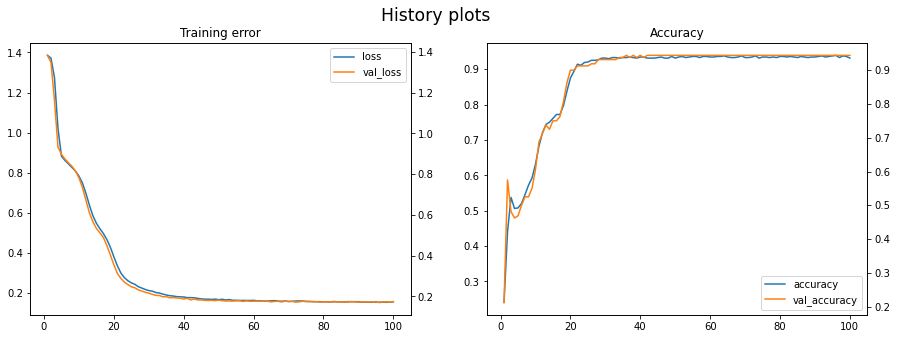



              precision    recall  f1-score   support

           0       0.80      0.73      0.76        44
           1       0.94      0.96      0.95        51
           2       0.84      0.88      0.86        48
           3       0.97      0.98      0.97        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.90      0.89       200

Accuracy: 	89.5%



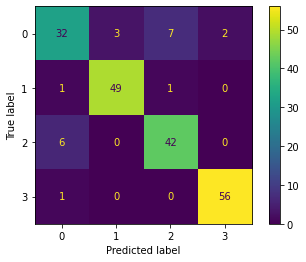



MODEL MET HIDDEN ACTIVATION: SELU MET NORMALISATIE


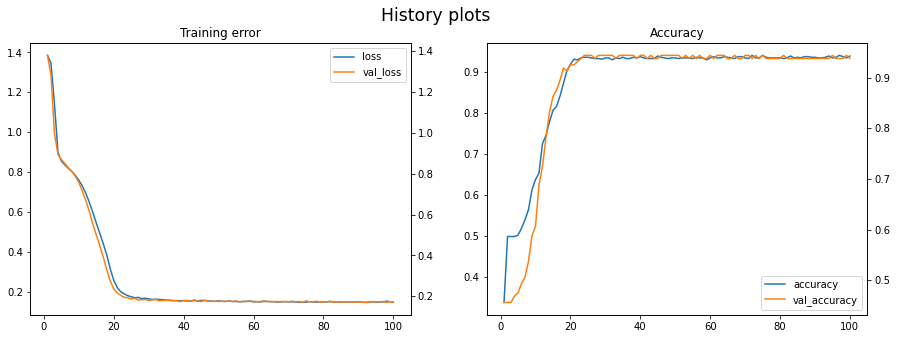



              precision    recall  f1-score   support

           0       0.81      0.77      0.79        44
           1       0.98      0.96      0.97        51
           2       0.84      0.88      0.86        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200

Accuracy: 	90.5%



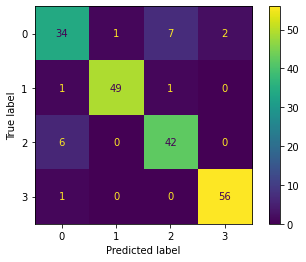



MODEL MET HIDDEN ACTIVATION: ELU MET NORMALISATIE


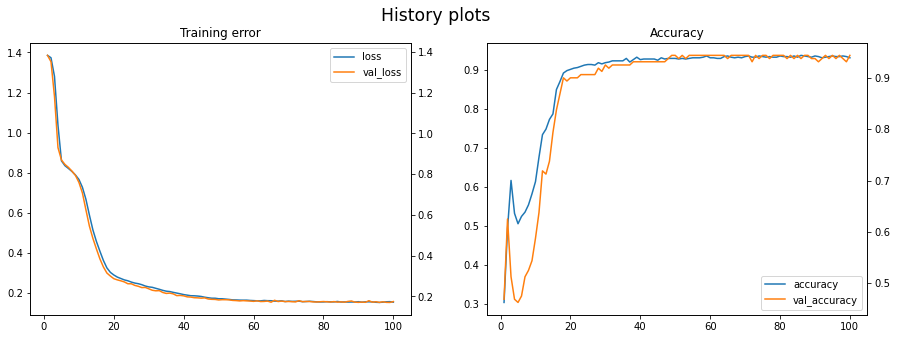



              precision    recall  f1-score   support

           0       0.81      0.77      0.79        44
           1       0.96      0.96      0.96        51
           2       0.86      0.88      0.87        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200

Accuracy: 	90.5%



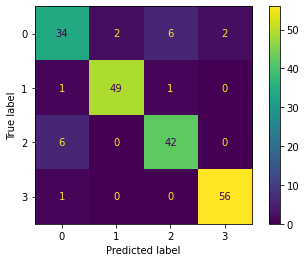



MODEL MET HIDDEN ACTIVATION: EXPONENTIAL MET NORMALISATIE


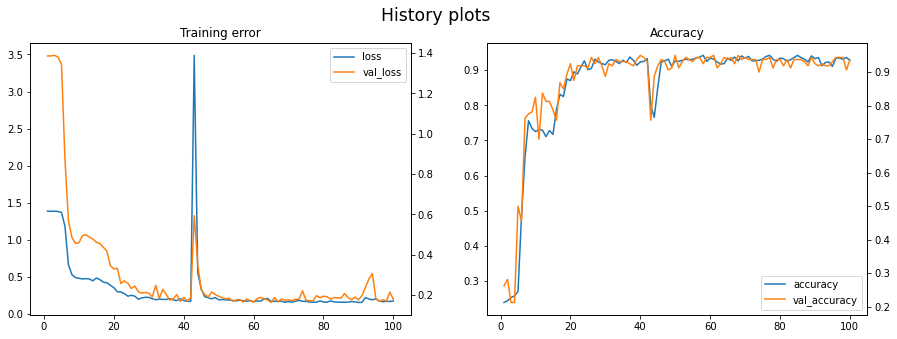



              precision    recall  f1-score   support

           0       0.46      0.82      0.59        44
           1       0.98      0.86      0.92        51
           2       0.88      0.88      0.88        48
           3       0.96      0.47      0.64        57

    accuracy                           0.74       200
   macro avg       0.82      0.76      0.75       200
weighted avg       0.83      0.74      0.75       200

Accuracy: 	74.5%



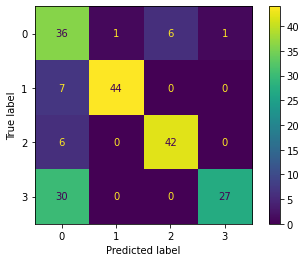



MODEL MET HIDDEN ACTIVATION: LINEAR MET NORMALISATIE


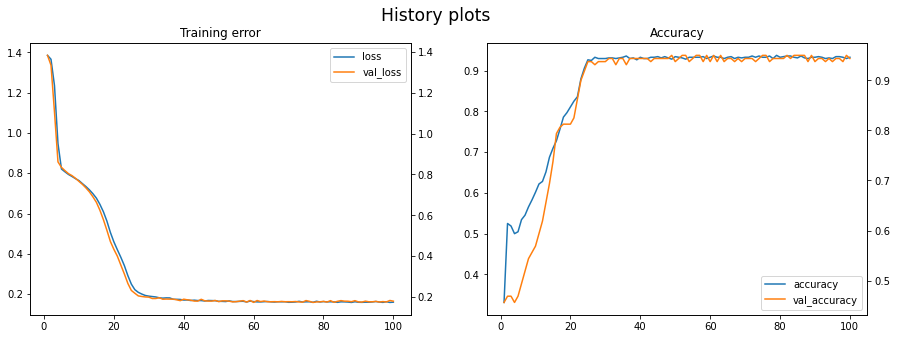



              precision    recall  f1-score   support

           0       0.80      0.82      0.81        44
           1       0.96      0.96      0.96        51
           2       0.88      0.88      0.88        48
           3       0.98      0.96      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200

Accuracy: 	91.0%



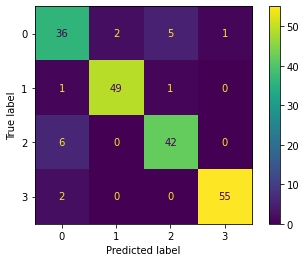



MODEL MET HIDDEN ACTIVATION: GELU MET NORMALISATIE


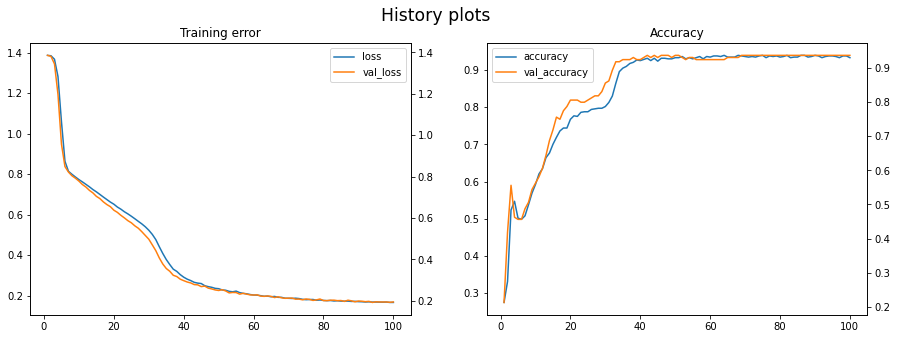



              precision    recall  f1-score   support

           0       0.83      0.77      0.80        44
           1       0.98      0.96      0.97        51
           2       0.84      0.90      0.87        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200

Accuracy: 	91.0%



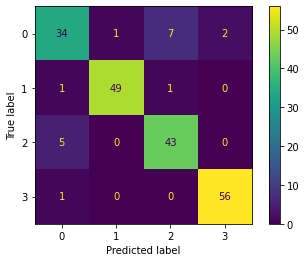



MODEL MET HIDDEN ACTIVATION: SWISH MET NORMALISATIE


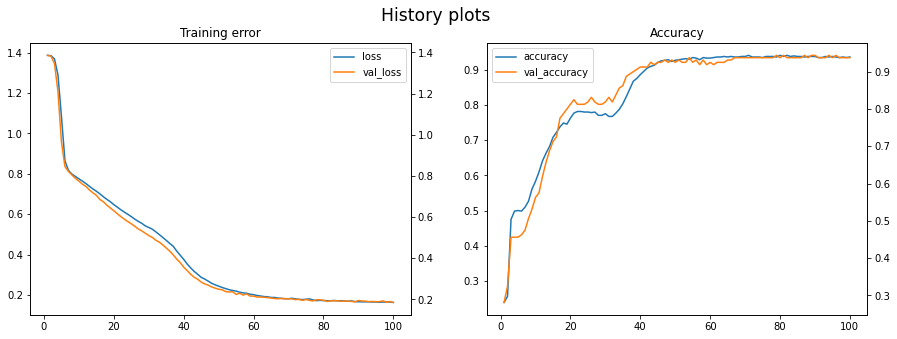



              precision    recall  f1-score   support

           0       0.80      0.80      0.80        44
           1       0.98      0.94      0.96        51
           2       0.84      0.90      0.87        48
           3       0.98      0.96      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200

Accuracy: 	90.5%



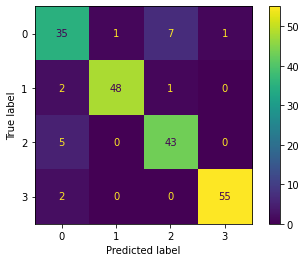

In [31]:
# Uitwerking verschillende activatiefuncties
activations = [
    'relu',
    'sigmoid',
    'softmax',
    'softplus',
    'softsign',
    'tanh',
    'selu',
    'elu',
    'exponential',
    'linear',
    'gelu',
    'swish'
]

for a in activations:
    header = f'MODEL MET HIDDEN ACTIVATION: {a.upper()} MET NORMALISATIE'
    headlen = len(header)
    headline = '=' * headlen
    print(header)
    print(headline)
    batch_size = 32
    epochs = 100
    dropoutrate = 0.0
    input_dim = X_train.shape[1]
    activation_output = 'sigmoid'# activatie van de output layer neuronen
    initializer = 'RandomUniform' # type van kernel intializer
    adam = tf.optimizers.Adam()
    model = Sequential()
    model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=a))
    model.add(Dropout(dropoutrate))
    model.add(Dense(20, kernel_initializer=initializer,activation=a))
    model.add(Dropout(dropoutrate))
    model.add(Dense(20, kernel_initializer=initializer,activation=a))
    model.add(Dropout(dropoutrate))
    model.add(Dense(y_train.shape[1], kernel_initializer=initializer,activation=activation_output))
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    history = model.fit(X_train_ss, y_train, epochs=epochs, validation_split = 0.2,verbose=0)
    
    history_plotter(epochs, metric1='loss', metric2='accuracy')
    
    y_pred = np.argmax(model.predict(X_test_ss), axis=-1)
    print('\n')
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('\n')

**Conclusie activatiefuncties**  
De verschillende activatiefuncties hebben een invloed op hoe snel en hoe stijl de loss-functies dalen, daar zij met hun afgeleiden een invloed hebben op het instellen van de learning rate. Dit leidt er toe dat bij softmax en sigmoid de accuracy naar verloop van tijd daalt, omdat een resultaat dat neigt naar de limiten van de curven, oneindige afgeleiden krijgt en daardoor moeilijk de learning rate kan bijstellen.

#### Effect van verschillende initializers
**Opdracht**  
Probeer verschillende initializers

MODEL MET INITIALIZER RANDOMUNIFORM EN NORMALISATIE


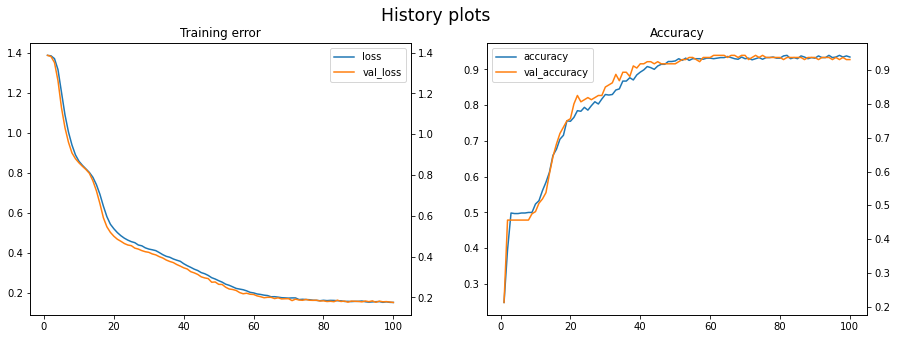



              precision    recall  f1-score   support

           0       0.80      0.73      0.76        44
           1       0.96      0.96      0.96        51
           2       0.82      0.88      0.85        48
           3       0.97      0.98      0.97        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.90      0.89       200

Accuracy: 	89.5%



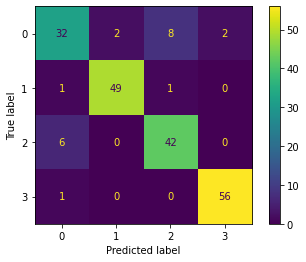



MODEL MET INITIALIZER RANDOMNORMAL EN NORMALISATIE


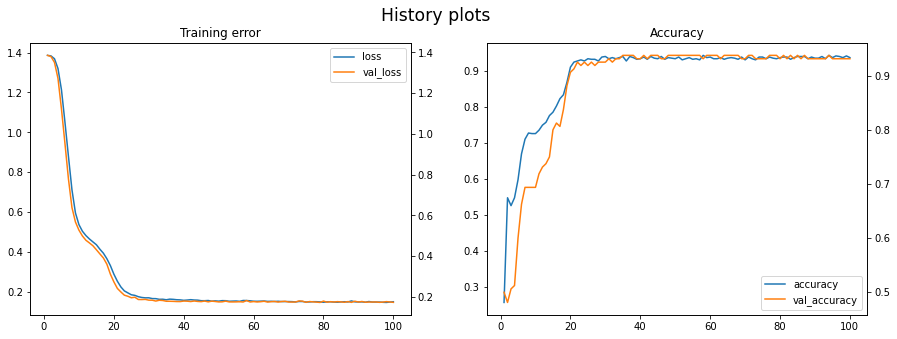



              precision    recall  f1-score   support

           0       0.80      0.80      0.80        44
           1       0.98      0.94      0.96        51
           2       0.86      0.88      0.87        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200

Accuracy: 	90.5%



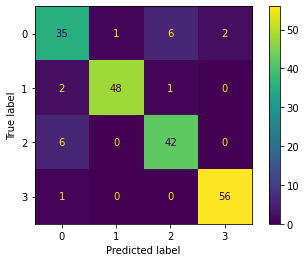



MODEL MET INITIALIZER GLOROTNORMAL EN NORMALISATIE


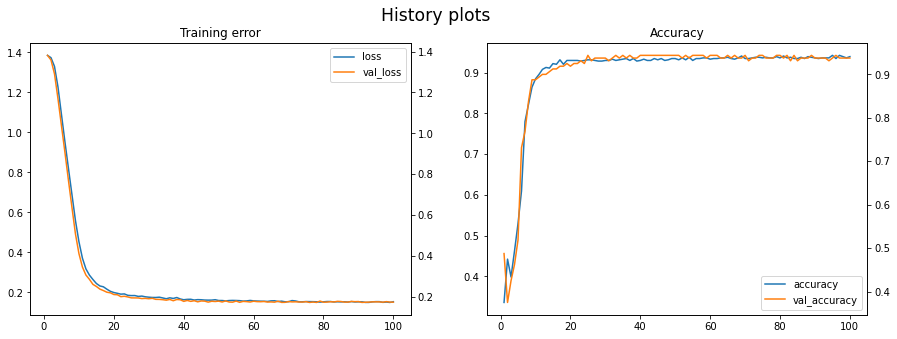



              precision    recall  f1-score   support

           0       0.80      0.73      0.76        44
           1       0.96      0.96      0.96        51
           2       0.82      0.88      0.85        48
           3       0.97      0.98      0.97        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.90      0.89       200

Accuracy: 	89.5%



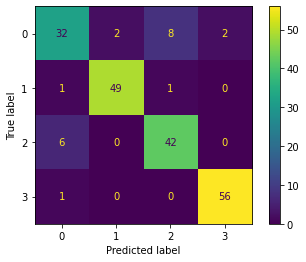



MODEL MET INITIALIZER GLOROTUNIFORM EN NORMALISATIE


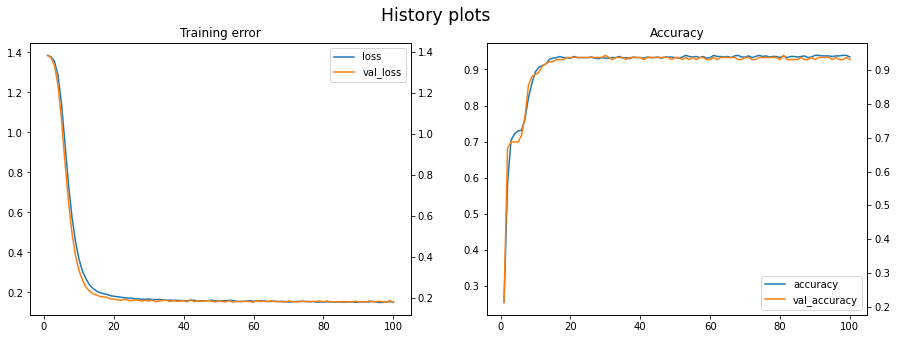



              precision    recall  f1-score   support

           0       0.81      0.80      0.80        44
           1       0.98      0.96      0.97        51
           2       0.86      0.88      0.87        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200

Accuracy: 	91.0%



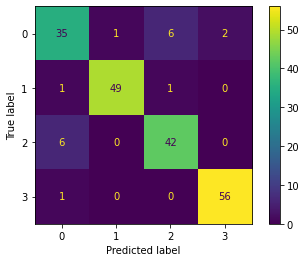



MODEL MET INITIALIZER HENORMAL EN NORMALISATIE


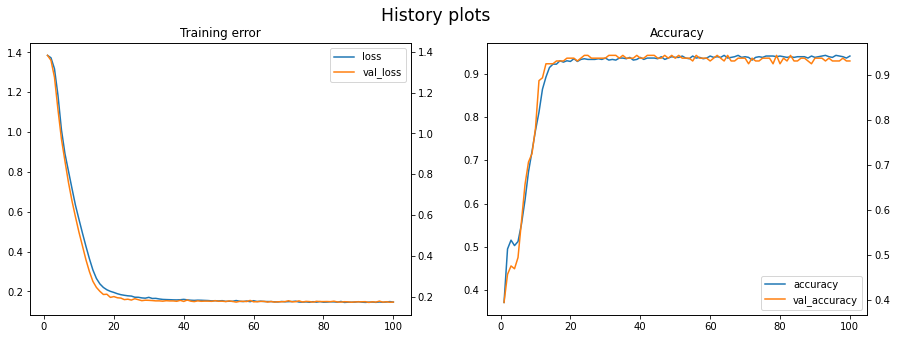



              precision    recall  f1-score   support

           0       0.81      0.77      0.79        44
           1       0.96      0.96      0.96        51
           2       0.86      0.88      0.87        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200

Accuracy: 	90.5%



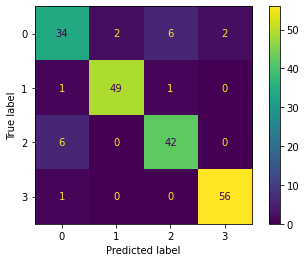



MODEL MET INITIALIZER HEUNIFORM EN NORMALISATIE


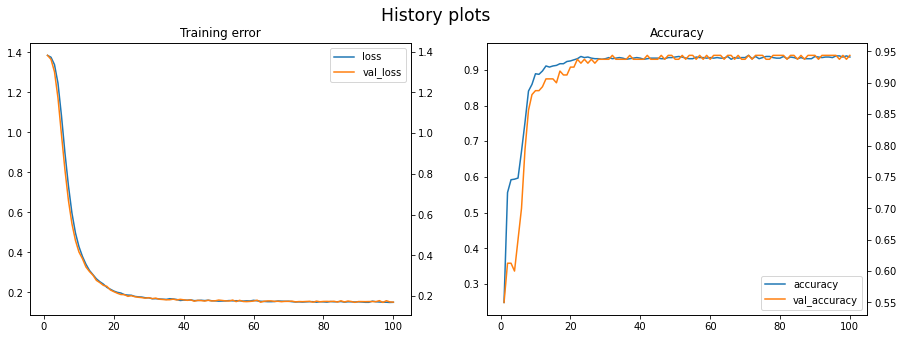



              precision    recall  f1-score   support

           0       0.80      0.73      0.76        44
           1       0.94      0.96      0.95        51
           2       0.84      0.88      0.86        48
           3       0.97      0.98      0.97        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.90      0.89       200

Accuracy: 	89.5%



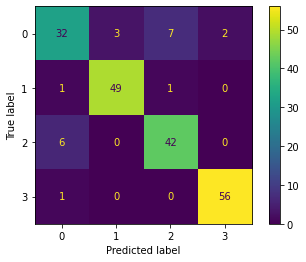



MODEL MET INITIALIZER LECUNNORMAL EN NORMALISATIE


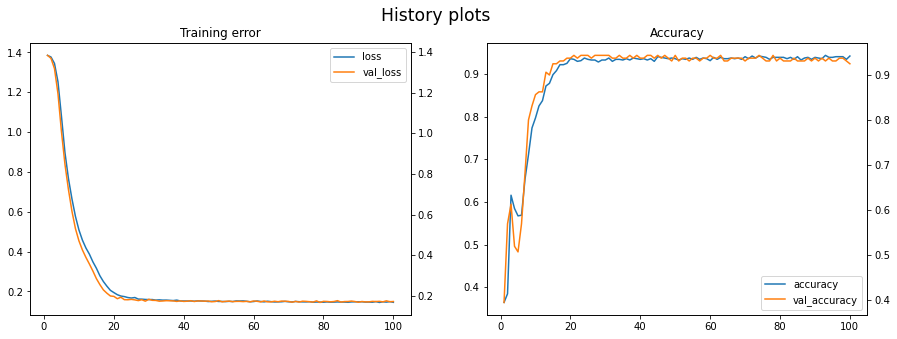



              precision    recall  f1-score   support

           0       0.81      0.77      0.79        44
           1       0.96      0.96      0.96        51
           2       0.86      0.88      0.87        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200

Accuracy: 	90.5%



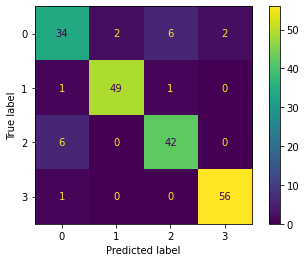



MODEL MET INITIALIZER LECUNUNIFORM EN NORMALISATIE


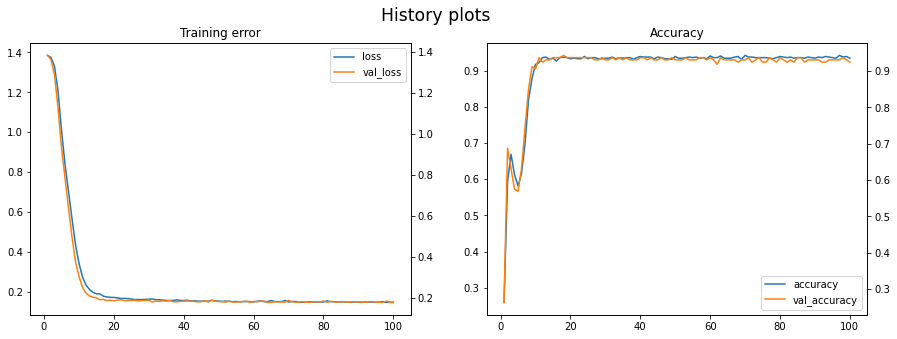



              precision    recall  f1-score   support

           0       0.81      0.77      0.79        44
           1       0.96      0.96      0.96        51
           2       0.86      0.88      0.87        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200

Accuracy: 	90.5%



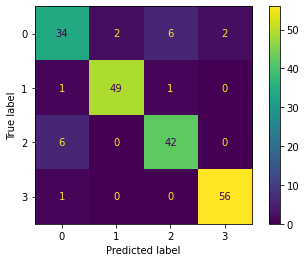



MODEL MET INITIALIZER ORTHOGONAL EN NORMALISATIE


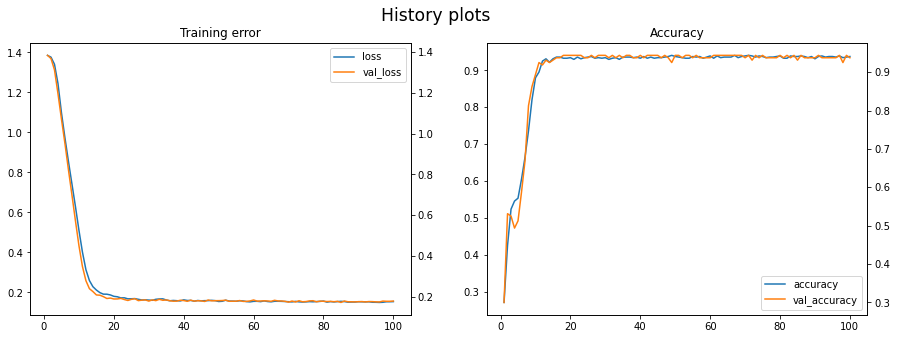



              precision    recall  f1-score   support

           0       0.78      0.70      0.74        44
           1       0.94      0.96      0.95        51
           2       0.82      0.88      0.85        48
           3       0.96      0.96      0.96        57

    accuracy                           0.89       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.89      0.88       200

Accuracy: 	88.5%



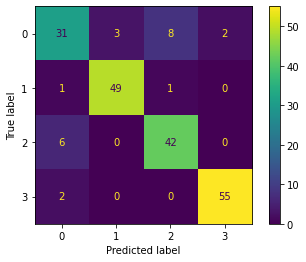



MODEL MET INITIALIZER TRUNCATEDNORMAL EN NORMALISATIE


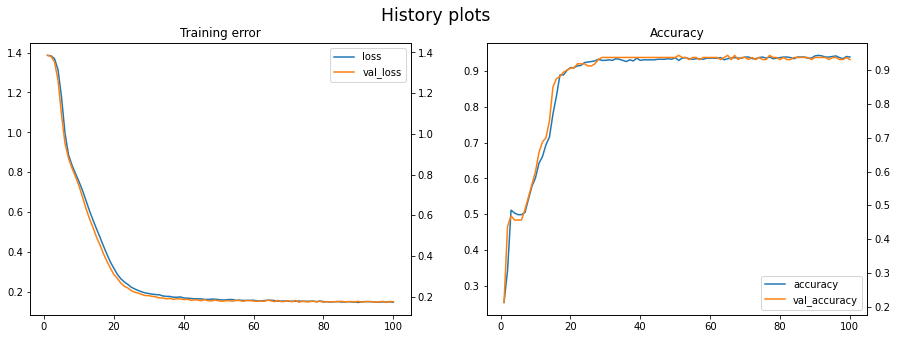



              precision    recall  f1-score   support

           0       0.82      0.73      0.77        44
           1       0.96      0.96      0.96        51
           2       0.83      0.90      0.86        48
           3       0.97      0.98      0.97        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.90      0.90      0.90       200

Accuracy: 	90.0%



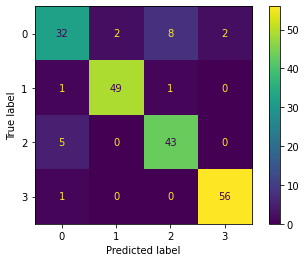



MODEL MET INITIALIZER ZEROS EN NORMALISATIE


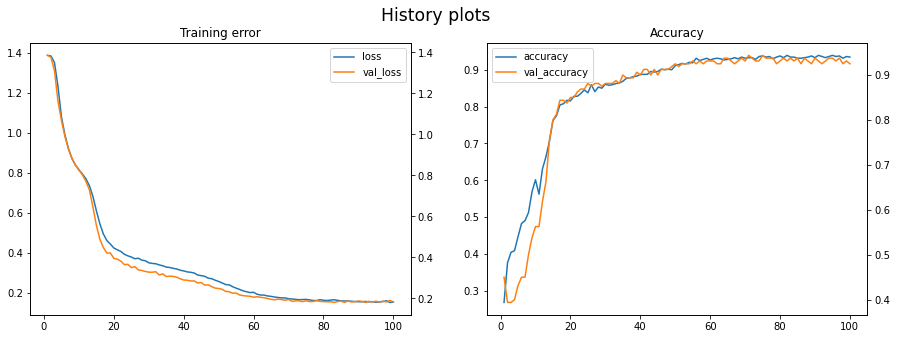



              precision    recall  f1-score   support

           0       0.80      0.75      0.78        44
           1       0.96      0.96      0.96        51
           2       0.84      0.88      0.86        48
           3       0.97      0.98      0.97        57

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.90      0.90      0.90       200

Accuracy: 	90.0%



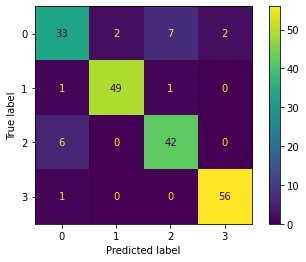

In [32]:
# Uitwerking verschillende initializers
initializers = [
    'RandomUniform',
    'RandomNormal',
    'GlorotNormal',
    'GlorotUniform',
    'HeNormal',
    'HeUniform',
    'LecunNormal',
    'LecunUniform',
    'Orthogonal',
    'TruncatedNormal',
    'Zeros'
]

for i in initializers:
    header = f'MODEL MET INITIALIZER {i.upper()} EN NORMALISATIE'
    headlen = len(header)
    headline = '=' * headlen
    print(header)
    print(headline)
    a = 'relu'
    batch_size = 32
    epochs = 100
    dropoutrate = 0.0
    input_dim = X_train.shape[1]
    activation_output = 'sigmoid'# activatie van de output layer neuronen
    adam = tf.optimizers.Adam()
    model = Sequential()
    model.add(Dense(20, input_dim=input_dim, kernel_initializer=initializer,activation=a))
    model.add(Dropout(dropoutrate))
    model.add(Dense(20, kernel_initializer=initializer,activation=a))
    model.add(Dropout(dropoutrate))
    model.add(Dense(20, kernel_initializer=initializer,activation=a))
    model.add(Dropout(dropoutrate))
    model.add(Dense(y_train.shape[1], kernel_initializer=i,activation=activation_output))
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    history = model.fit(X_train_ss, y_train, epochs=epochs, validation_split = 0.2,verbose=0)
    
    history_plotter(epochs, metric1='loss', metric2='accuracy')
    
    y_pred = np.argmax(model.predict(X_test_ss), axis=-1)
    print('\n')
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('\n')

**Conclusie initializers**  
Op zich hebben de initializers weinig invloed, behalve dat bij sommige initializers de loss-functie veel sneller zal dalen, dan anderen.

#### Hyperparameter tuning
**Opdracht**  
Doe hyperparameter tuning via grid search, random search en bayes optimization. Wat is de finale accuracy die je haalt op de test set?

In [45]:
# Uitwerking grid search

# Model definiëren met de te investigeren parameters
def create_model(optimizer="adam", neurons=20, dropout=0.1, initializer='RandomUniform', activation_hidden='relu'):
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    activation_output = 'sigmoid'# activatie van de output layer neuronen
    
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim, kernel_initializer=initializer, activation=activation_hidden))
    model.add(Dropout(dropout))
    model.add(Dense(neurons, input_dim=input_dim, kernel_initializer=initializer, activation=activation_hidden))
    model.add(Dropout(dropout))
    model.add(Dense(neurons, kernel_initializer=initializer, activation=activation_hidden))
    model.add(Dropout(dropout))
    model.add(Dense(neurons, kernel_initializer=initializer, activation=activation_hidden))
    model.add(Dropout(dropout))
    model.add(Dense(output_dim, kernel_initializer=initializer, activation=activation_output))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# SKLearn compatibel maken
model = KerasClassifier(build_fn=create_model, batch_size=8, epochs=10, verbose=0)

# Parametergrid aanmaken
param_grid = {
    'epochs': [10, 50, 100],
    'neurons': [10, 20, 50],
    'initializer': ['RandomUniform', 'lecun_uniform', 'normal'], 
    'batch_size':[8, 32],
    'optimizer':['SGD', 'Adam'],
    'dropout': [0.3, 0.1, 0],
    'activation_hidden': ['relu', 'sigmoid', 'softmax']
}

# Gridsearch
grid = GridSearchCV(estimator=model, n_jobs=2, verbose=1, param_grid=param_grid)

gs = grid.fit(X_train, y_train)

Beste accuracy: 0.9350000023841858
Parameters voor beste model: {'activation_hidden': 'relu', 'batch_size': 8, 'dropout': 0.1, 'epochs': 100, 'initializer': 'normal', 'neurons': 10, 'optimizer': 'Adam'}


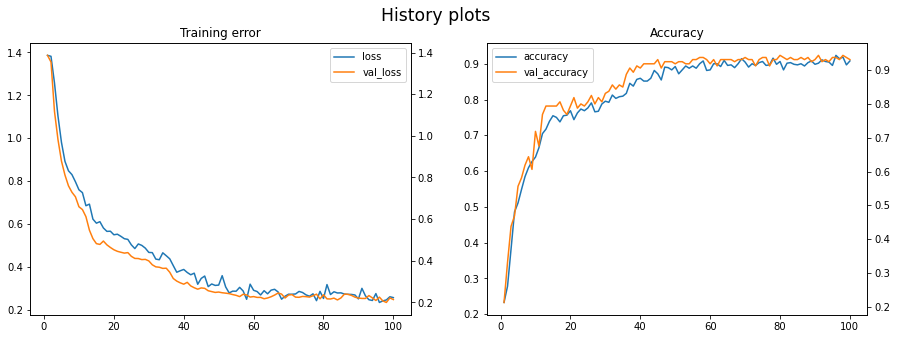



              precision    recall  f1-score   support

           0       0.85      0.77      0.81        44
           1       0.96      0.98      0.97        51
           2       0.85      0.92      0.88        48
           3       0.98      0.96      0.97        57

    accuracy                           0.92       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.92      0.92      0.91       200

Accuracy: 	91.5%



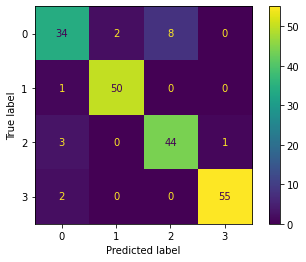

In [52]:
print(f"Beste accuracy: {gs.best_score_}")
print(f"Parameters voor beste model: {gs.best_params_}")

# Create model met beste parameters
model = create_model(
    optimizer = gs.best_params_['optimizer'],
    neurons = gs.best_params_['neurons'],
    dropout = gs.best_params_['dropout'],
    initializer = gs.best_params_['initializer'],
    activation_hidden = gs.best_params_['activation_hidden'],
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=gs.best_params_['epochs'], 
    batch_size = gs.best_params_['batch_size'], 
    validation_split = 0.2, 
    verbose=0
)

history_plotter(gs.best_params_['epochs'], metric1='loss', metric2='accuracy')
    
y_pred = np.argmax(model.predict(X_test), axis=-1)
print('\n')
print(classification_report(y_test, y_pred, zero_division=0))
print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
print('\n')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Beste accuracy: 0.9387500047683716
Parameters voor beste model: {'optimizer': 'Adam', 'neurons': 50, 'initializer': 'lecun_uniform', 'epochs': 100, 'dropout': 0.1, 'batch_size': 8, 'activation_hidden': 'sigmoid'}


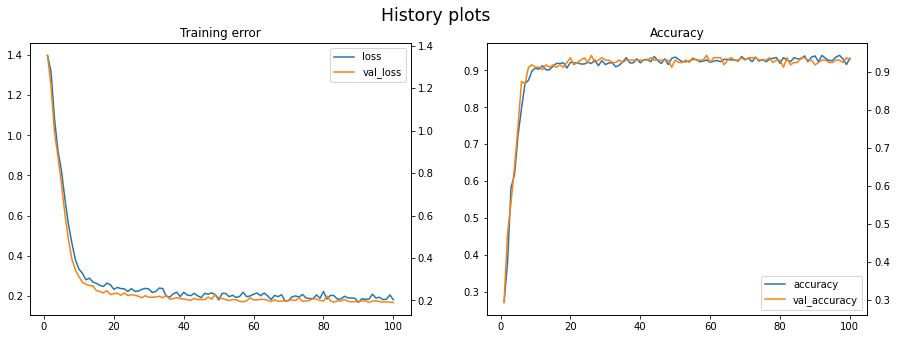



              precision    recall  f1-score   support

           0       0.80      0.80      0.80        44
           1       0.96      0.96      0.96        51
           2       0.84      0.88      0.86        48
           3       1.00      0.96      0.98        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200

Accuracy: 	90.5%



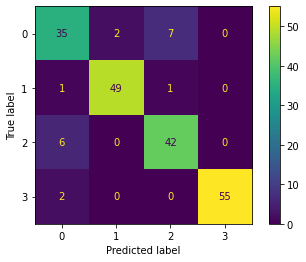

In [55]:
# Uitwerking RandomSearch

# SKLearn compatibel maken
model = KerasClassifier(build_fn=create_model, batch_size=8, epochs=10, verbose=0)

# Parametergrid aanmaken
param_grid = {
    'epochs': [10, 50, 100],
    'neurons': [10, 20, 50],
    'initializer': ['RandomUniform', 'lecun_uniform', 'normal'], 
    'batch_size':[8, 32],
    'optimizer':['SGD', 'Adam'],
    'dropout': [0.3, 0.1, 0],
    'activation_hidden': ['relu', 'sigmoid', 'softmax']
}

# Gridsearch
randsearch = RandomizedSearchCV(model, param_grid, cv=5, n_jobs=1, n_iter=50, verbose=1)

rs = randsearch.fit(X_train, y_train)

print(f"Beste accuracy: {rs.best_score_}")
print(f"Parameters voor beste model: {rs.best_params_}")

# Create model met beste parameters
model = create_model(
    optimizer = rs.best_params_['optimizer'],
    neurons = rs.best_params_['neurons'],
    dropout = rs.best_params_['dropout'],
    initializer = rs.best_params_['initializer'],
    activation_hidden = rs.best_params_['activation_hidden'],
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=rs.best_params_['epochs'], 
    batch_size = rs.best_params_['batch_size'], 
    validation_split = 0.2, 
    verbose=0
)

history_plotter(rs.best_params_['epochs'], metric1='loss', metric2='accuracy')
    
y_pred = np.argmax(model.predict(X_test), axis=-1)
print('\n')
print(classification_report(y_test, y_pred, zero_division=0))
print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
print('\n')

Beste accuracy: 0.9337499976158142
Parameters voor beste model: OrderedDict([('activation_hidden', 'relu'), ('batch_size', 30), ('dropout', 0.0), ('epochs', 100), ('initializer', 'lecun_uniform'), ('neurons', 20), ('optimizer', 'Adam')])


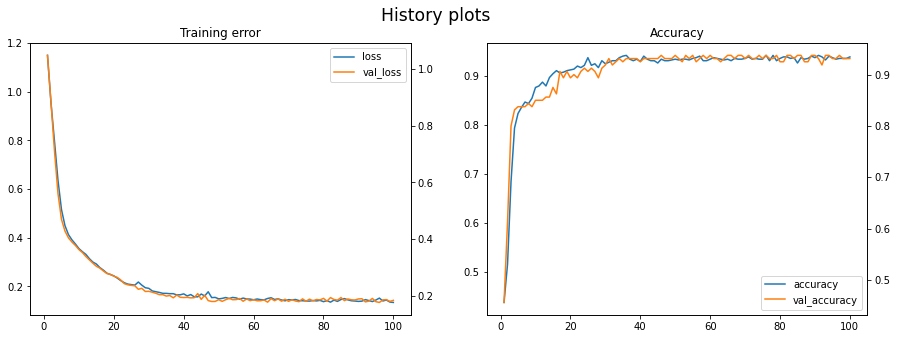



              precision    recall  f1-score   support

           0       0.80      0.75      0.78        44
           1       0.94      0.98      0.96        51
           2       0.88      0.88      0.88        48
           3       0.97      0.98      0.97        57

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200

Accuracy: 	90.5%



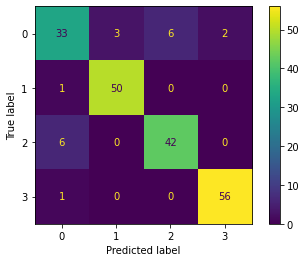

In [62]:
# Uitwerking BayesSearchCV

# SKLearn compatibel maken
model = KerasClassifier(build_fn=create_model, batch_size=8, epochs=10, verbose=0)

# Parametergrid aanmaken
search_space = {
    'epochs': [10, 50, 100],
    'neurons': [10, 20, 50],
    'initializer': ['RandomUniform', 'lecun_uniform', 'normal'], 
    'batch_size':[8, 32],
    'optimizer':['SGD', 'Adam'],
    'dropout': [0.3, 0.1, 0],
    'activation_hidden': ['relu', 'sigmoid', 'softmax']
}

# BayesSearch
bayes = BayesSearchCV(estimator=model, search_spaces=search_space, n_jobs=1, cv=5, n_iter=20, verbose=0)

bs = bayes.fit(X_train, y_train)

print(f"Beste accuracy: {bs.best_score_}")
print(f"Parameters voor beste model: {bs.best_params_}")

# Create model met beste parameters
model = create_model(
    optimizer = bs.best_params_['optimizer'],
    neurons = bs.best_params_['neurons'],
    dropout = bs.best_params_['dropout'],
    initializer = bs.best_params_['initializer'],
    activation_hidden = bs.best_params_['activation_hidden'],
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=rs.best_params_['epochs'], 
    batch_size = bs.best_params_['batch_size'], 
    validation_split = 0.2, 
    verbose=0
)

history_plotter(rs.best_params_['epochs'], metric1='loss', metric2='accuracy')
    
y_pred = np.argmax(model.predict(X_test), axis=-1)
print('\n')
print(classification_report(y_test, y_pred, zero_division=0))
print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n') 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
print('\n')

**Conclusie hyperparameter tuning**  
Het beste model werd verkregen bij RandomSearch, waarbij de accuracy op de test set uiteindelijk 91.5% bedraagt. De parameters voor het beste model kunnen hierboven worden teruggevonden.

## Customer satisfaction

Een bank probeert vroegtijdig ontevreden klanten op te sporen en wil daarvoor deep learning toepassen.
Gegeven is een dataset "customersatisfaction.csv" met geanonimiseerde gegevens van hun klanten en de bijhorende klantentevredenheid. De features zelf werden ook geanonimiseerd.
De target kolom is de variabele die voorspeld moet worden. 1 staat voor ontevreden klanten, 0 staat voor tevreden klanten.

Train een neuraal netwerk dat een zo hoog mogelijke accuraatheid haalt. 
Zorg dat er 10000 samples in de test set aanwezig zijn en zet de random_state op 0.

In [96]:
cs = pd.read_csv('./customersatisfaction.csv')
cs.head(10)

ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   1     2     23                 0.0                      0.0   
1   3     2     34                 0.0                      0.0   
2   4     2     23                 0.0                      0.0   
3   8     2     37                 0.0                    195.0   
4  10     2     39                 0.0                      0.0   
5  13     2     23                 0.0                      0.0   
6  14     2     27                 0.0                      0.0   
7  18     2     26                 0.0                      0.0   
8  20     2     45                 0.0                      0.0   
9  23     2     25                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   
5                      0.0                      0.0                      0.0   
6                      0.0                      0.0                      0.0   
7                      0.0                      0.0                      0.0   
8                      0.0                      0.0                      0.0   
9                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
0                      0.0                      0.0  ...   
1                      0.0                      0.0  ...   
2                      0.0                      0.0  ...   
3                      0.0                      0.0  ...   
4                      0.0                      0.0  ...   
5                      0.0                      0.0  ...   
6                      0.0                      0.0  ...   
7                      0.0                      0.0  ...   
8                      0.0                      0.0  ...   
9                      0.0                      0.0  ...   

   saldo_medio_var33_hace2  saldo_medio_var33_hace3  saldo_medio_var33_ult1  \
0                      0.0                      0.0                     0.0   
1                      0.0                      0.0                     0.0   
2                      0.0                      0.0                     0.0   
3                      0.0                      0.0                     0.0   
4                      0.0                      0.0                     0.0   
5                      0.0                      0.0                     0.0   
6                      0.0                      0.0                     0.0   
7                      0.0                      0.0                     0.0   
8                      0.0                      0.0                     0.0   
9                      0.0                      0.0                     0.0   

   saldo_medio_var33_ult3  saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
0                     0.0                      0.0                      0.0   
1                     0.0                      0.0                      0.0   
2                     0.0                      0.0                      0.0   
3                     0.0                      0.0                      0.0   
4                     0.0                      0.0                      0.0   
5                     0.0                      0.0                      0.0   
6                     0.0                      0.0                      0.0   
7                     0.0                      0.0                      0.0   
8                     0.0                      0.0                      0.0   
9                     0.0                      0.0             

### Gebalanceerdheid onderzoeken
In een eerste stap wordt onderzocht of de data gebalanceerd is.

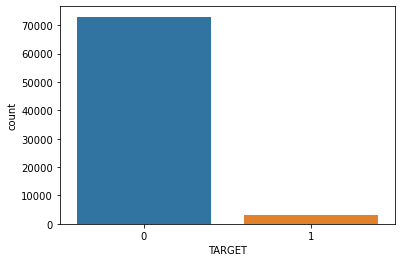

In [98]:
plt.rcParams["figure.figsize"] = (6,4)
sns.countplot(x='TARGET', data=cs, saturation=0.75);

**Conclusie gebalanceerdheid**  
De data is niet gebalanceerd. Er is een sterk overwicht aan tevreden klanten (TARGET = 0)

Gezien de features zijn geanonimiseerd, lijkt het minder nuttig om aan verdere datavisualisatie te doen (vb. pairplot of individuele plots).

### Statistische vooranalyse en preprocessing
Volgende stappen worden doorlopen:
- Analyse van ontbrekende waarden
- Statistische vooranalyse
- Verwijderen van onnodige features
- Opsplitsen van features en target
- Opsplitsen in training en test set
- Schalen van de features
- One-hot encoding van het target

#### Ontbrekende waarden
Doormiddel van een eigen gemaakte functie wordt onderzocht of er ontbrekende waarden in de dataset zijn.

In [99]:
# Ontbrekende data
def ismissing(df):
    all_columns = df.columns

    missing_arr = []
    missing_column = ['Column name', 'Number of missing values']

    for c in all_columns:
        mv = df[c].isnull().sum()
        if mv != 0:
            missing_row = [c, mv]
            missing_arr.append(missing_row)
    
    if not missing_arr:
        print("Er zijn geen ontbrekende waarden")
    else:
        missing_df = pd.DataFrame(missing_arr, columns = missing_column)
        return missing_df

ismissing(cs)

Er zijn geen ontbrekende waarden


**Conclusie ontbrekende waarden**  
Er zijn geen ontbrekende waarden in deze dataset. Er moeten bijgevolg geen observaties worden geschrapt.

#### Statistische vooranalyse
Doormiddel van de describe functie worden de basisstatistieken onderzocht van de dataset.

In [100]:
cs.describe()

ID           var3         var15  imp_ent_var16_ult1  \
count   76020.000000   76020.000000  76020.000000        76020.000000   
mean    75964.050723   -1523.199277     33.212865           86.208265   
std     43781.947379   39033.462364     12.956486         1614.757313   
min         1.000000 -999999.000000      5.000000            0.000000   
25%     38104.750000       2.000000     23.000000            0.000000   
50%     76043.000000       2.000000     28.000000            0.000000   
75%    113748.750000       2.000000     40.000000            0.000000   
max    151838.000000     238.000000    105.000000       210000.000000   

       imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
count             76020.000000             76020.000000   
mean                 72.363067               119.529632   
std                 339.315831               546.266294   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               12888.030000             21024.810000   

       imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
count             76020.000000             76020.000000   
mean                  3.559130                 6.472698   
std                  93.155749               153.737066   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max                8237.820000             11073.570000   

       imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
count             76020.000000             76020.000000  ...   
mean                  0.412946                 0.567352  ...   
std                  30.604864                36.513513  ...   
min                   0.000000                 0.000000  ...   
25%                   0.000000                 0.000000  ...   
50%                   0.000000                 0.000000  ...   
75%                   0.000000                 0.000000  ...   
max                6600.000000              6600.000000  ...   

       saldo_medio_var33_hace2  saldo_medio_var33_hace3  \
count             76020.000000             76020.000000   
mean                  7.935824                 1.365146   
std                 455.887218               113.959637   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               50003.880000             20385.720000   

       saldo_medio_var33_ult1  saldo_medio_var33_ult3  \
count            76020.000000            76020.000000   
mean                12.215580                8.784074   
std                783.207399              538.439211   
min                  0.000000                0.000000   
25%                  0.000000                0.000000   
50%                  0.000000                0.000000   
75%                  0.000000                0.000000   
max             138831.630000            91778.730000   

       saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
count             76020.000000             76020.000000   
mean                 31.505324                 1.858575   
std                2013.125393               147.786584   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max              438329.220000             24650.010000   

       saldo_medio_var44_ult1  saldo_medio_var44_ult3         var38  \
count            76020.000000            76020.000000  7.602000e+04   

**Conclusie statistische vooranalyse**  
De meeste features hebben een Q1, Q2 en Q3 met waarde 0. Het is pas in het laatste kwartiel dat er hogere waarden worden aangetroffen. Aangezien de features anoniem zijn, is het moeilijk om hier een onmiddellijke verklaring voor te geven. Er wordt van uitgegaan dat de data correct is.

Er is een kolom 'ID' aanwezig. Aangezien het hier om optellende sleutelwaarde is zonder verdere invloed op de andere features, wordt deze feature geschrapt in de volgende subsectie.

#### Verwijderen van onnodige features
In de vorige subsectie werd de kolom 'ID' geïdentificeerd als een onnodige kolom. Deze wordt bijgevolg verwijderd.

In [101]:
# Verwijderen onnodige features
cs.drop('ID', axis=1, inplace=True)
cs.head()

var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0     2     23                 0.0                      0.0   
1     2     34                 0.0                      0.0   
2     2     23                 0.0                      0.0   
3     2     37                 0.0                    195.0   
4     2     39                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  imp_op_var40_ult1  ...  \
0                      0.0                      0.0                0.0  ...   
1                      0.0                      0.0                0.0  ...   
2                      0.0                      0.0                0.0  ...   
3                      0.0                      0.0                0.0  ...   
4                      0.0                      0.0                0.0  ...   

   saldo_medio_var33_hace2  saldo_medio_var33_hace3  saldo_medio_var33_ult1  \
0                      0.0                      0.0                     0.0   
1                      0.0                      0.0                     0.0   
2                      0.0                      0.0                     0.0   
3                      0.0                      0.0                     0.0   
4                      0.0                      0.0                     0.0   

   saldo_medio_var33_ult3  saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
0                     0.0                      0.0                      0.0   
1                     0.0                      0.0                      0.0   
2                     0.0                      0.0                      0.0   
3                     0.0                      0.0                      0.0   
4                     0.0                      0.0                      0.0   

   saldo_medio_var44_ult1  saldo_medio_var44_ult3          var38  TARGET  
0                     0.0                     0.0   39205.170000       0  
1                     0.0                     0.0   49278.030000       0  
2                     0.0                     0.0   67333.770000       0  
3                     0.0                     0.0   64007.970000       0  
4                     0.0                     0.0  117310.979016       0  

[5 rows x 370 columns]

**Conclusie verwijderen onnodige features**  
De kolom 'ID' is succesvol verwijderd.

#### Opsplitsen van features en target
De dataset wordt gesplitst in target (kolomnaam TARGET) en features (alle andere kolommen)

In [102]:
# Opsplitsen features en target
y = cs['TARGET'].values
X = cs.drop('TARGET', axis=1)

In [103]:
print(y)
print(len(y))

[0 0 0 ... 0 0 0]
76020


In [104]:
X.head()

var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0     2     23                 0.0                      0.0   
1     2     34                 0.0                      0.0   
2     2     23                 0.0                      0.0   
3     2     37                 0.0                    195.0   
4     2     39                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  imp_op_var40_ult1  ...  \
0                      0.0                      0.0                0.0  ...   
1                      0.0                      0.0                0.0  ...   
2                      0.0                      0.0                0.0  ...   
3                      0.0                      0.0                0.0  ...   
4                      0.0                      0.0                0.0  ...   

   saldo_medio_var29_ult3  saldo_medio_var33_hace2  saldo_medio_var33_hace3  \
0                     0.0                      0.0                      0.0   
1                     0.0                      0.0                      0.0   
2                     0.0                      0.0                      0.0   
3                     0.0                      0.0                      0.0   
4                     0.0                      0.0                      0.0   

   saldo_medio_var33_ult1  saldo_medio_var33_ult3  saldo_medio_var44_hace2  \
0                     0.0                     0.0                      0.0   
1                     0.0                     0.0                      0.0   
2                     0.0                     0.0                      0.0   
3                     0.0                     0.0                      0.0   
4                     0.0                     0.0                      0.0   

   saldo_medio_var44_hace3  saldo_medio_var44_ult1  saldo_medio_var44_ult3  \
0                      0.0                     0.0                     0.0   
1                      0.0                     0.0                     0.0   
2                      0.0                     0.0                     0.0   
3                      0.0                     0.0                     0.0   
4                      0.0                     0.0                     0.0   

           var38  
0   39205.170000  
1   49278.030000  
2   67333.770000  
3   64007.970000  
4  117310.979016  

[5 rows x 369 columns]

#### Opsplitsen in training en test set
Zoals gevraagd, wordt de test set 10000 samples groot. Random state wordt op 0 gezet

In [105]:
# Opsplitsen in training en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 10000, random_state=0)

In [106]:
X_train.head()

var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
34787     2     53                 0.0                     0.00   
11506     2     23                 0.0                     0.00   
18173     2     35                 0.0                     0.00   
24910     2     35                 0.0                   544.44   
55797     2     33                 0.0                   119.88   

       imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  \
34787                     0.00                      0.0   
11506                     0.00                      0.0   
18173                     0.00                      0.0   
24910                   544.44                      0.0   
55797                   119.88                      0.0   

       imp_op_var40_comer_ult3  imp_op_var40_efect_ult1  \
34787                      0.0                      0.0   
11506                      0.0                      0.0   
18173                      0.0                      0.0   
24910                      0.0                      0.0   
55797                      0.0                      0.0   

       imp_op_var40_efect_ult3  imp_op_var40_ult1  ...  \
34787                      0.0                0.0  ...   
11506                      0.0                0.0  ...   
18173                      0.0                0.0  ...   
24910                      0.0                0.0  ...   
55797                      0.0                0.0  ...   

       saldo_medio_var29_ult3  saldo_medio_var33_hace2  \
34787                     0.0                      0.0   
11506                     0.0                      0.0   
18173                     0.0                      0.0   
24910                     0.0                      0.0   
55797                     0.0                      0.0   

       saldo_medio_var33_hace3  saldo_medio_var33_ult1  \
34787                      0.0                     0.0   
11506                      0.0                     0.0   
18173                      0.0                     0.0   
24910                      0.0                     0.0   
55797                      0.0                     0.0   

       saldo_medio_var33_ult3  saldo_medio_var44_hace2  \
34787                     0.0                      0.0   
11506                     0.0                      0.0   
18173                     0.0                      0.0   
24910                     0.0                      0.0   
55797                     0.0                      0.0   

       saldo_medio_var44_hace3  saldo_medio_var44_ult1  \
34787                      0.0                     0.0   
11506                      0.0                     0.0   
18173                      0.0                     0.0   
24910                      0.0                     0.0   
55797                      0.0                     0.0   

       saldo_medio_var44_ult3          var38  
34787                     0.0   58762.590000  
11506                     0.0  223974.090000  
18173                     0.0   70360.410000  
24910                     0.0  232389.450000  
55797                     0.0  117310.979016  

[5 rows x 369 columns]

#### Schalen van de features
StandardScaler wordt gebruikt voor het schalen van de numerieke features met behulp van de ColumnTransformer van SKLearn.

In [107]:
# Schalen van de features
X_train_columns = list(X_train.columns)

ss = ColumnTransformer(transformers = [
    ('scaling', StandardScaler(), X_train_columns),
], remainder ='passthrough')

X_train_ss = pd.DataFrame(ss.fit_transform(X_train), columns=X_train_columns)
X_test_ss = pd.DataFrame(ss.transform(X_test), columns=X_train_columns)

X_train_ss.head()

var3     var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0  0.037942  1.516081           -0.053568                -0.212366   
1  0.037942 -0.788796           -0.053568                -0.212366   
2  0.037942  0.133155           -0.053568                -0.212366   
3  0.037942  0.133155           -0.053568                 1.374602   
4  0.037942 -0.020504           -0.053568                 0.137068   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                -0.217967                -0.038016                -0.041968   
1                -0.217967                -0.038016                -0.041968   
2                -0.217967                -0.038016                -0.041968   
3                 0.767969                -0.038016                -0.041968   
4                -0.000874                -0.038016                -0.041968   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  imp_op_var40_ult1  ...  \
0                -0.013376                -0.015748          -0.033233  ...   
1                -0.013376                -0.015748          -0.033233  ...   
2                -0.013376                -0.015748          -0.033233  ...   
3                -0.013376                -0.015748          -0.033233  ...   
4                -0.013376                -0.015748          -0.033233  ...   

   saldo_medio_var29_ult3  saldo_medio_var33_hace2  saldo_medio_var33_hace3  \
0               -0.006282                -0.016537                  -0.0124   
1               -0.006282                -0.016537                  -0.0124   
2               -0.006282                -0.016537                  -0.0124   
3               -0.006282                -0.016537                  -0.0124   
4               -0.006282                -0.016537                  -0.0124   

   saldo_medio_var33_ult1  saldo_medio_var33_ult3  saldo_medio_var44_hace2  \
0               -0.014241               -0.015093                -0.015383   
1               -0.014241               -0.015093                -0.015383   
2               -0.014241               -0.015093                -0.015383   
3               -0.014241               -0.015093                -0.015383   
4               -0.014241               -0.015093                -0.015383   

   saldo_medio_var44_hace3  saldo_medio_var44_ult1  saldo_medio_var44_ult3  \
0                -0.011262               -0.018814               -0.019854   
1                -0.011262               -0.018814               -0.019854   
2                -0.011262               -0.018814               -0.019854   
3                -0.011262               -0.018814               -0.019854   
4                -0.011262               -0.018814               -0.019854   

      var38  
0 -0.326333  
1  0.597071  
2 -0.261510  
3  0.644106  
4  0.000907  

[5 rows x 369 columns]

**Conclusie schalen**  
De features zijn succesvol geschaald.

#### One-hot encoding van het target
Doormiddel van de functie 'to_categorical' van Keras wordt het target one-hot geëncodeerd.

In [108]:
y_train_orig= y_train  # keep the original labels for testing purposes
y_train = to_categorical(y_train)
print(y_train)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


**Conclusie encoderen target**  
Het target is succesvol one-hot geëncodeerd. De dataset is nu klaar voor het trainen van een neuraal netwerk.

### Creatie en trainen van het neuraal netwerk
In een eerste instantie werd getracht het beste model te trainen via GridSearch, maar dit duurde uiteraard veel te lang. Daarom worden in verschillende stappen enkele belangrijke hyperparameters getuned. Aangezien er sprake is van ongebalanceerde data, zal class-weighting worden toegepast.

Om het zoeken naar het beste model overzichtelijk te houden, worden eerste enkele functies gedefinieerd aangaande modelcreatie en modelevaluatie.

In [109]:
# Functie om het model aan te maken
def create_model(
    optimizer="adam", 
    neurons=200, 
    dropout=0.1, 
    initializer='RandomUniform', 
    activation_hidden='relu', 
    n_hidden=3, 
    batch_norm=0,
    input_dim = X_train_ss.shape[1],
    output_dim = y_train.shape[1],
    loss='categorical_crossentropy',
    metrics='accuracy'):
    
    activation_output = 'softmax'
    
    # Model type
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(neurons, input_dim=input_dim, kernel_initializer=initializer, activation=activation_hidden))
    model.add(Dropout(dropout))
    if batch_norm == 1:
        model.add(BatchNormalization())
    
    # Next hidden layers
    for i in range(2, n_hidden):
        model.add(Dense(neurons, kernel_initializer=initializer, activation=activation_hidden))
        model.add(Dropout(dropout))
        if batch_norm == 1:
            model.add(BatchNormalization())
        
    
    # Output layer
    model.add(Dense(output_dim, kernel_initializer=initializer, activation=activation_output))
    model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

    return model


# Functie om de history te evalueren
def model_history(epochs, metric1='loss', 
                   metric2='accuracy'):
    
    metric1val = f'val_{metric1}'
    metric2val = f'val_{metric2}'
    epochlist = np.linspace(1, epochs, epochs)
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('History plots', size='xx-large')
    colors = sns.color_palette()
    
    sns.lineplot(x=epochlist, y=history.history[metric1], color=colors[0], ax=ax1, label=metric1, legend=False)
    ax1.title.set_text('Training error')
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    ax2 = ax1.twinx()
    sns.lineplot(x=epochlist, y=history.history[metric1val], color=colors[1], ax=ax2, label=metric1val, legend=False)
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_a = lines_1 + lines_2
    labels_a = labels_1 + labels_2
    ax2.legend(lines_a, labels_a, loc=0)
    
    sns.lineplot(x=epochlist, y=history.history[metric2], color=colors[0], ax=ax3, label=metric2, legend=False)
    ax3.title.set_text('Accuracy')
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    ax4 = ax3.twinx()
    sns.lineplot(x=epochlist, y=history.history[metric2val], color=colors[1], ax=ax4, label=metric2val, legend=False);
    lines_4, labels_4 = ax4.get_legend_handles_labels()
    lines_b = lines_3 + lines_4
    labels_b = labels_3 + labels_4
    ax4.legend(lines_b, labels_b, loc=0)
    
    plt.show()


# Functie voor evaluatie van het model
def model_evaluation(estimator = create_model(), 
                     y_test = y_test,
                     X_test = X_test,
                    ):
    
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    
    print('\n')
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f'Accuracy: \t{accuracy_score(y_test, y_pred) * 100}%\n')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    
    print('\n')
    if output_dim == 2:
        RocCurveDisplay.from_predictions(y_test, y_pred, name='ROC Curve')
        plt.show()
    print('\n')


# Early stopping en modelcheckpoint instellen
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 50)
checkpoint_filepath = './bestmodel'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                        save_weights_only=True, 
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True)

# Classweights
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train_orig), y=y_train_orig)
class_weights= dict(enumerate(class_weights))

In deze eerste stap wordt bepaald hoeveel hidden layers en neuronen nodig zijn voor het neuronaal netwerk. Datawetenschappers vermelden vaak dat een feed forward netwerk in principe slechts nood zou hebben aan 1 hidden layer. Het aantal neuronen hierbij varieert per publicatie: gemiddelde van output en input dimensie of tweederden van de input dimensie opgeteld bij de output dimensie. In eerste instantie wordt gestart met een neuronaal netwerk van 1 hidden layer en 200 neuronen. Dit zal stapsgewijs worden verhoogd tot de accuracy niet meer verhoogd.

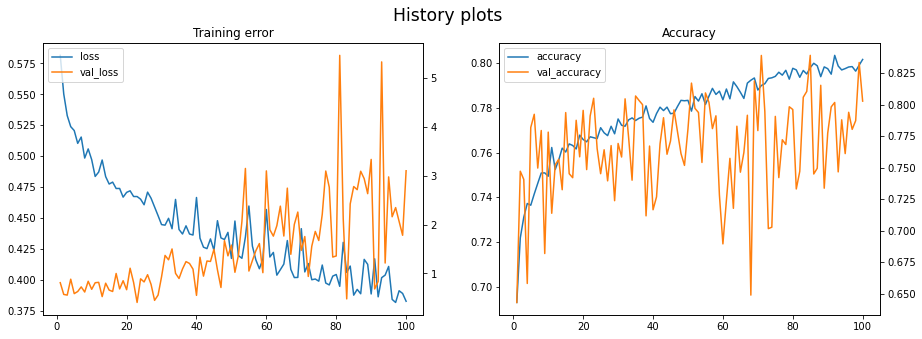



              precision    recall  f1-score   support

           0       0.98      0.80      0.88      9572
           1       0.14      0.69      0.23       428

    accuracy                           0.80     10000
   macro avg       0.56      0.75      0.56     10000
weighted avg       0.95      0.80      0.86     10000

Accuracy: 	79.82000000000001%



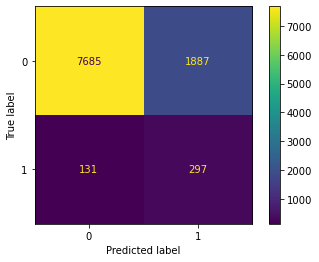

In [112]:
epochs = 100
n_hidden = 1
neurons = 200

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.0,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 32, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

In dit eerste model valt een sterke oscillatie op van de history-curves. Dit betekent dat de bijstelling van de learning rate niet optimaal verloopt Dit kan verholpen worden op 2 manieren: meer dieptegang van het neuraal netwerk of het verhogen van de batch_size. Omdat het eerder de bedoeling is om de invloed van de dieptegang op de fitting en metrics van het model in plaats van de estimatie van de learning rate, wordt er geopteerd voor het verhogen van de batch_size.

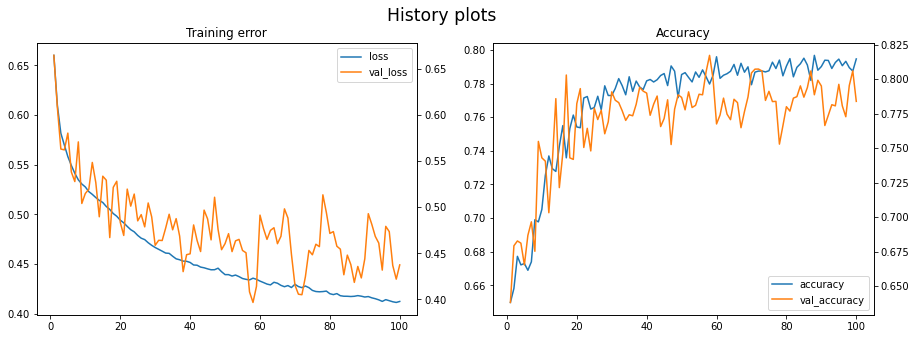



              precision    recall  f1-score   support

           0       0.98      0.79      0.88      9572
           1       0.13      0.71      0.22       428

    accuracy                           0.79     10000
   macro avg       0.56      0.75      0.55     10000
weighted avg       0.95      0.79      0.85     10000

Accuracy: 	78.61%



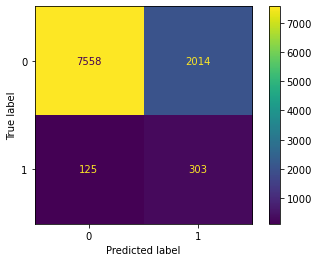

In [115]:
epochs = 100
n_hidden = 1
neurons = 200

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.0,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 5000, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

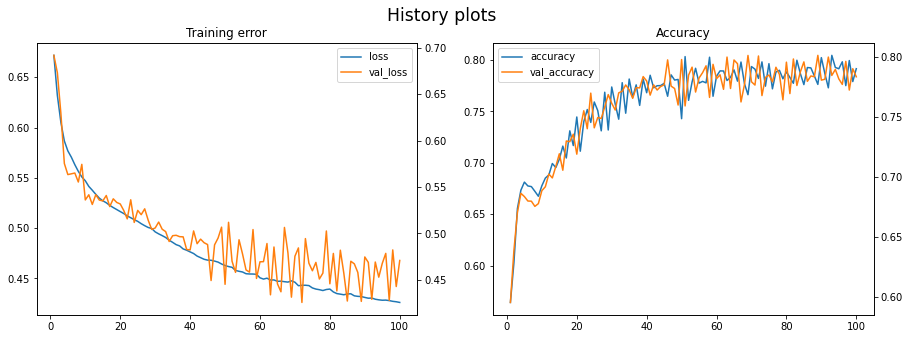



              precision    recall  f1-score   support

           0       0.98      0.79      0.87      9572
           1       0.13      0.73      0.22       428

    accuracy                           0.78     10000
   macro avg       0.56      0.76      0.55     10000
weighted avg       0.95      0.78      0.85     10000

Accuracy: 	78.44%



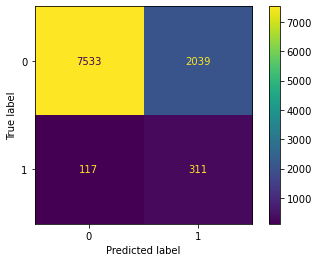

In [116]:
epochs = 100
n_hidden = 1
neurons = 200

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.0,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

Bij het verhogen van de batch_size is de oscillatie het minst bij een grootte van 10000 samples. Verdere verhoging kan een negatieve impact hebben op nde robuustheid en accuraatheid van het model en zal verder niet worden toegepast. Er zal nu aandacht gegeven worden aan het verhogen van de dieptegang met in eerste instantie het aantal hidden layers.

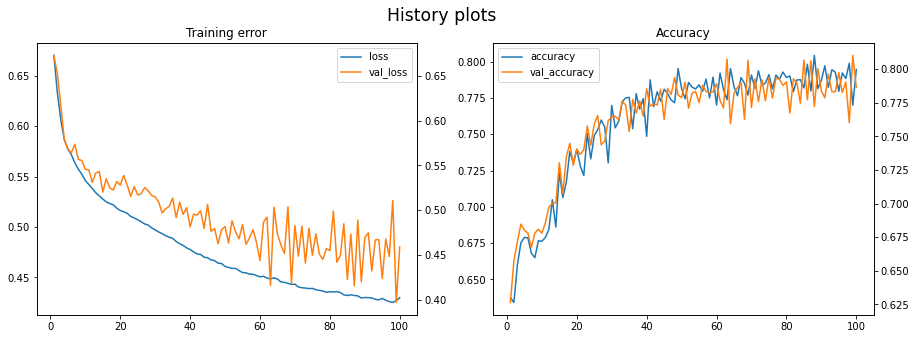



              precision    recall  f1-score   support

           0       0.98      0.79      0.88      9572
           1       0.13      0.71      0.22       428

    accuracy                           0.79     10000
   macro avg       0.56      0.75      0.55     10000
weighted avg       0.95      0.79      0.85     10000

Accuracy: 	78.64%



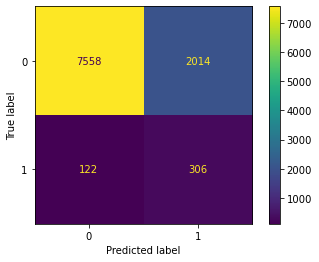

In [117]:
# verhogen van aantal hidden layers n=2
epochs = 100
n_hidden = 2
neurons = 200

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.0,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

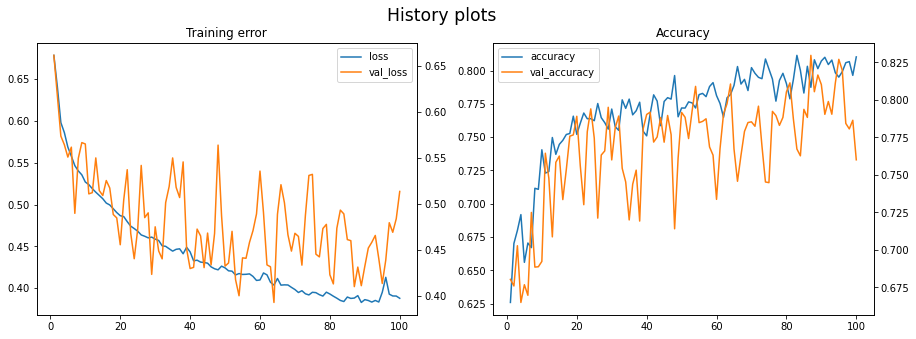



              precision    recall  f1-score   support

           0       0.98      0.76      0.86      9572
           1       0.12      0.71      0.20       428

    accuracy                           0.76     10000
   macro avg       0.55      0.74      0.53     10000
weighted avg       0.95      0.76      0.83     10000

Accuracy: 	76.21%



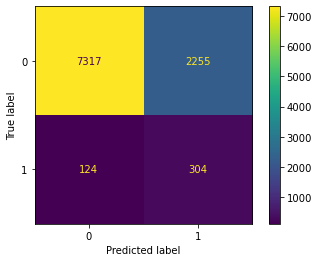

In [118]:
# verhogen van aantal hidden layers n=3
epochs = 100
n_hidden = 3
neurons = 200

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.0,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

Bij het verhogen van het aantal lagen treed al heel snel overfitting op. Bij 3 hidden layers treed er opnieuw sterke oscillaties op. Bij 2 hidden layers word gekeken of een daling van het aantal neuronen een effect heeft op de accuracy en de overfitting.

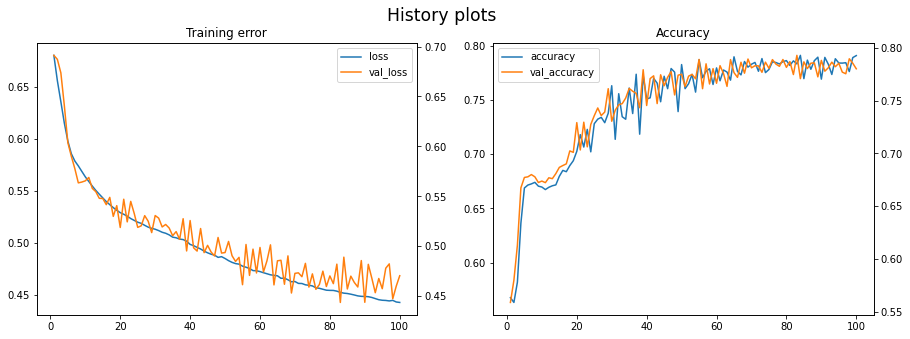



              precision    recall  f1-score   support

           0       0.98      0.78      0.87      9572
           1       0.13      0.72      0.22       428

    accuracy                           0.78     10000
   macro avg       0.56      0.75      0.55     10000
weighted avg       0.95      0.78      0.84     10000

Accuracy: 	78.14%



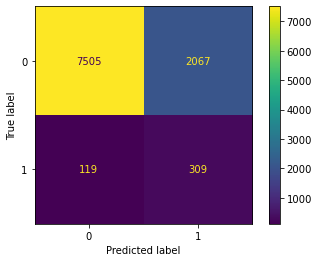

In [119]:
# hidden layers n=2, verlagen van aantal neuronen (100)
epochs = 100
n_hidden = 2
neurons = 100

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.0,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

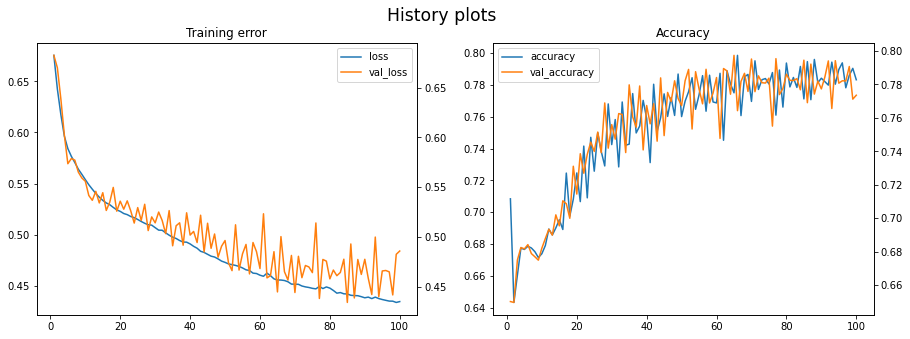



              precision    recall  f1-score   support

           0       0.98      0.78      0.87      9572
           1       0.13      0.73      0.22       428

    accuracy                           0.77     10000
   macro avg       0.56      0.75      0.54     10000
weighted avg       0.95      0.77      0.84     10000

Accuracy: 	77.45%



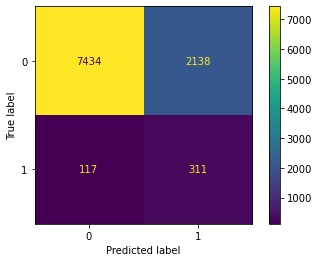

In [120]:
# hidden layers n=2, verlagen van aantal neuronen (150)
epochs = 100
n_hidden = 2
neurons = 150

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.0,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

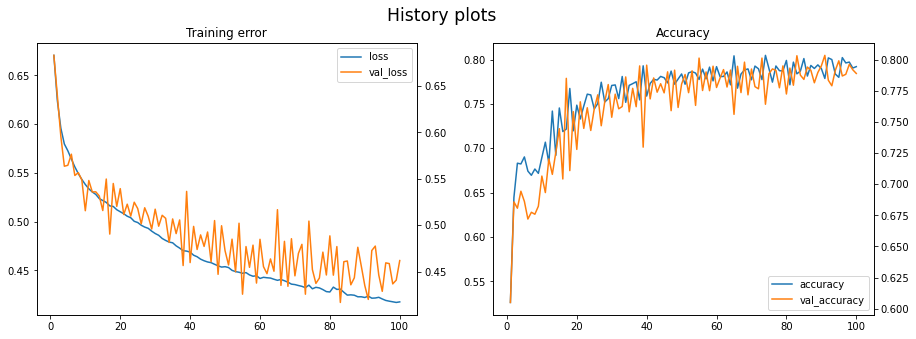



              precision    recall  f1-score   support

           0       0.98      0.79      0.88      9572
           1       0.13      0.71      0.22       428

    accuracy                           0.79     10000
   macro avg       0.56      0.75      0.55     10000
weighted avg       0.95      0.79      0.85     10000

Accuracy: 	78.60000000000001%



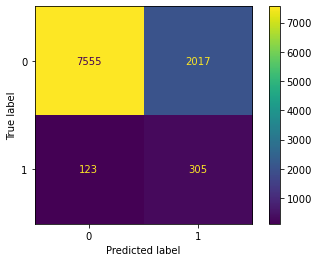

In [121]:
# hidden layers n=2, verhogen van aantal neuronen (300)
epochs = 100
n_hidden = 2
neurons = 300

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.0,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

Het verlagen tot 100 neuronen heeft het beste effect op de history-curves. Hierdoor lijkt de overfitting minder aanwezig te zijn, maar is nog steeds substantieel aanwezig. Er wordt bijkomend drop-out toegepast.

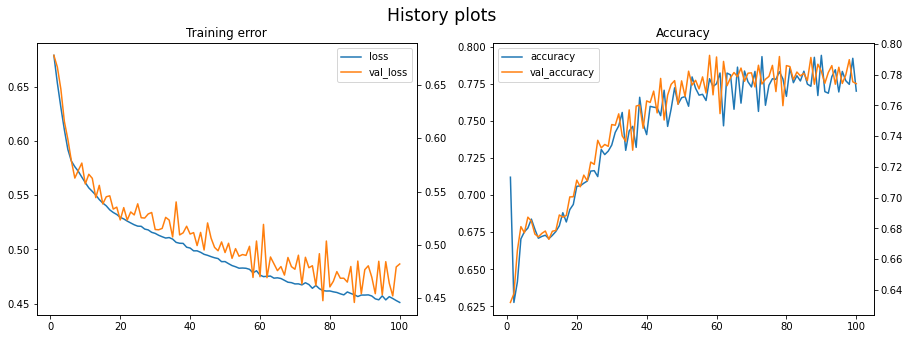



              precision    recall  f1-score   support

           0       0.98      0.78      0.87      9572
           1       0.13      0.73      0.22       428

    accuracy                           0.78     10000
   macro avg       0.56      0.75      0.54     10000
weighted avg       0.95      0.78      0.84     10000

Accuracy: 	77.52%



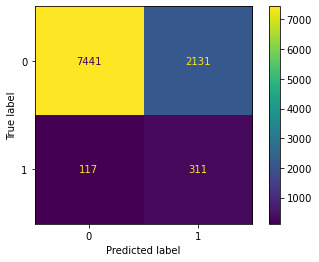

In [124]:
# hidden layers n=2, aantal neuronen (100), dropout 0.1
epochs = 100
n_hidden = 2
neurons = 100

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.1,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

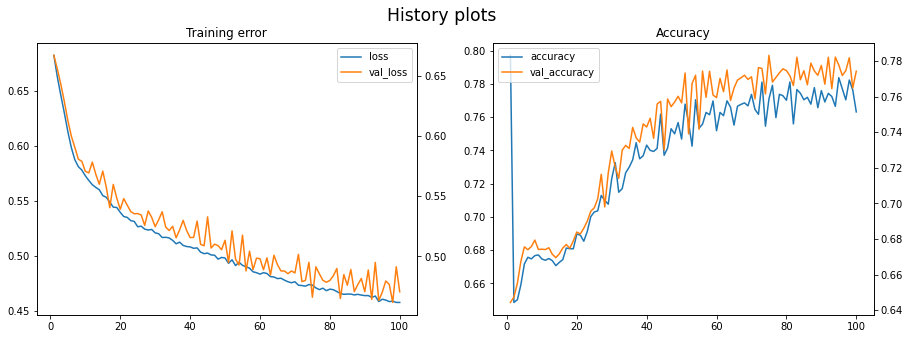



              precision    recall  f1-score   support

           0       0.98      0.79      0.87      9572
           1       0.13      0.71      0.22       428

    accuracy                           0.78     10000
   macro avg       0.56      0.75      0.55     10000
weighted avg       0.95      0.78      0.85     10000

Accuracy: 	78.28%



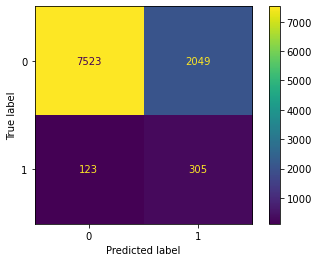

In [128]:
# hidden layers n=2, aantal neuronen (100), dropout 0.3
epochs = 100
n_hidden = 2
neurons = 100

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.3,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.3, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

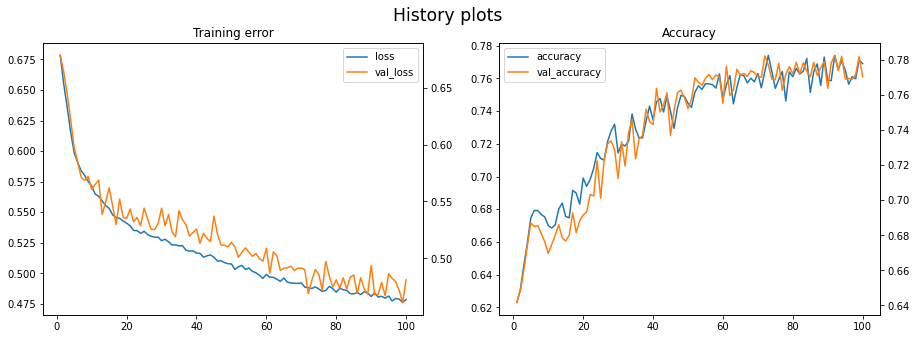



              precision    recall  f1-score   support

           0       0.98      0.78      0.87      9572
           1       0.13      0.72      0.21       428

    accuracy                           0.77     10000
   macro avg       0.56      0.75      0.54     10000
weighted avg       0.95      0.77      0.84     10000

Accuracy: 	77.42%



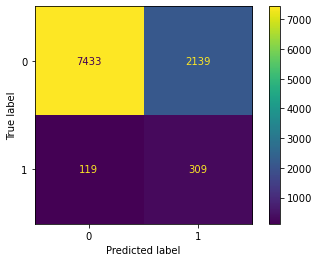

In [127]:
# hidden layers n=2, aantal neuronen (100), dropout 0.5
epochs = 100
n_hidden = 2
neurons = 100

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.5,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

Drop out heeft effect op de overfitting. Een drop-out van 0.3 lijkt de beste resultaten op te leveren.

In een volgende stap wordt het effect van batchnormalization uitgezocht.

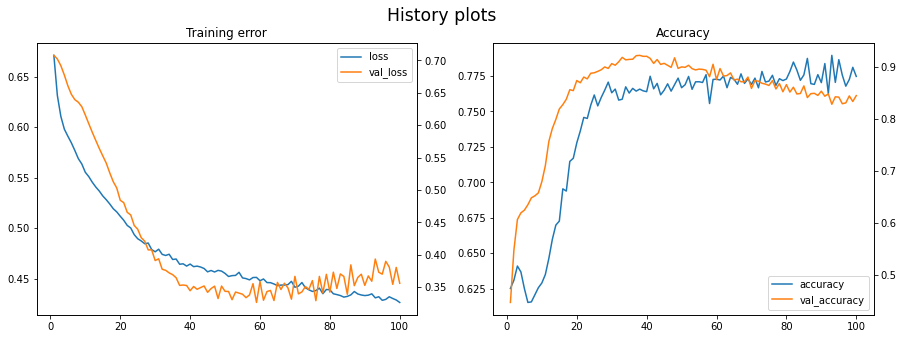



              precision    recall  f1-score   support

           0       0.98      0.86      0.92      9572
           1       0.17      0.62      0.26       428

    accuracy                           0.85     10000
   macro avg       0.57      0.74      0.59     10000
weighted avg       0.95      0.85      0.89     10000

Accuracy: 	84.93%



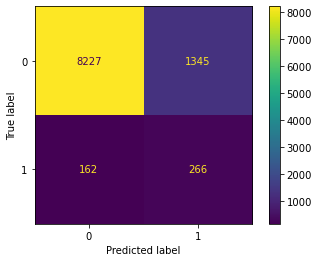

In [129]:
# hidden layers n=2, aantal neuronen (100), dropout 0.3 met batchnormalization
epochs = 100
n_hidden = 2
neurons = 100

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.3,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=1,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.3, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

Batchnormalization heeft een positieve impact op het model in termen van de accuracy. Deze stijgt tot bijna 85%. De leercurves worden daarentegen vertraagd (latere en tragere daling van de loss-curves). Het effect van het aantal hidden layers en neuronen worden opnieuw onderzocht.

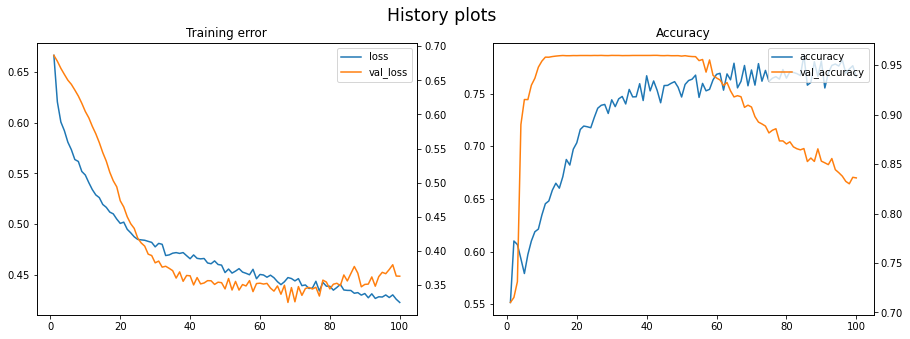



              precision    recall  f1-score   support

           0       0.98      0.84      0.91      9572
           1       0.15      0.63      0.25       428

    accuracy                           0.84     10000
   macro avg       0.57      0.74      0.58     10000
weighted avg       0.95      0.84      0.88     10000

Accuracy: 	83.52000000000001%



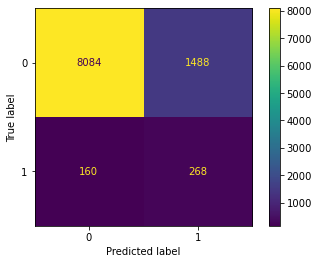

In [131]:
# hidden layers n=3, aantal neuronen (100), dropout 0.3 met batchnormalization
epochs = 100
n_hidden = 3
neurons = 100

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.3,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=1,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.3, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

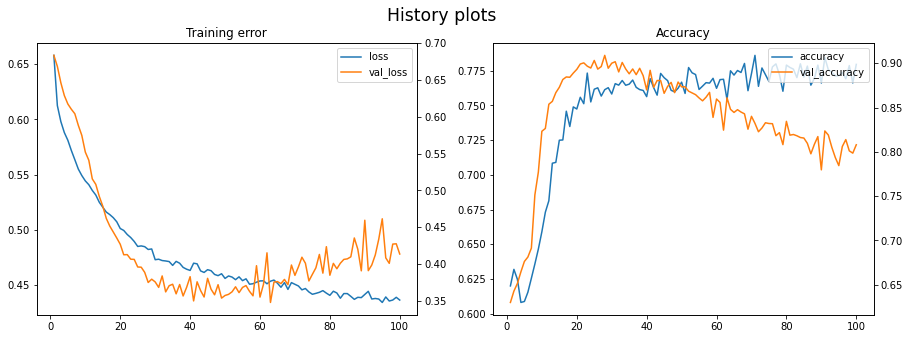



              precision    recall  f1-score   support

           0       0.98      0.82      0.89      9572
           1       0.15      0.69      0.24       428

    accuracy                           0.81     10000
   macro avg       0.56      0.76      0.57     10000
weighted avg       0.95      0.81      0.86     10000

Accuracy: 	81.17999999999999%



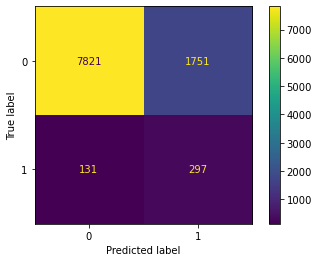

In [134]:
# hidden layers n=2, aantal neuronen (150), dropout 0.3 met batchnormalization
epochs = 100
n_hidden = 2
neurons = 150

model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.3,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=1,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='binary_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

Het verhogen van de neuronen of de hidden layers zorgt opnieuw voor overfitting, maar de huidige accuracy is nog steeds hoger dan de initiële modellen. Tot nu toe werd het model rechthoekig beschouwd. In een volgende stap wordt het model opgebouwd, waarbij de opeenvolgende hidden layers dalend aantal neuronen hebben (triangulaire opbouw).

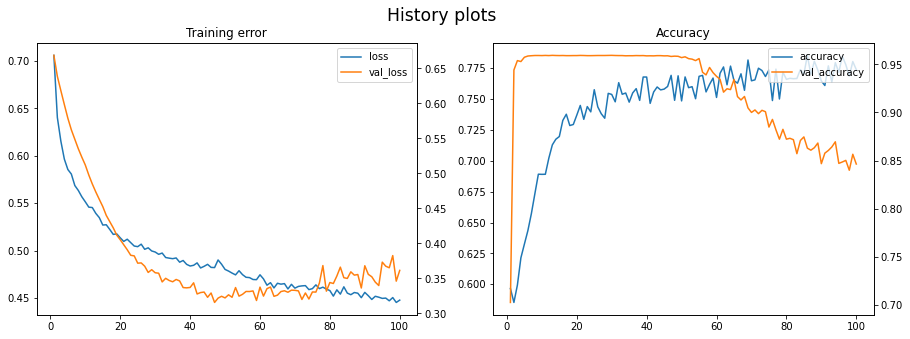



              precision    recall  f1-score   support

           0       0.98      0.86      0.92      9572
           1       0.17      0.62      0.26       428

    accuracy                           0.85     10000
   macro avg       0.57      0.74      0.59     10000
weighted avg       0.95      0.85      0.89     10000

Accuracy: 	84.94%



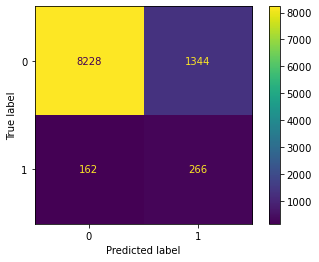

In [137]:
model = Sequential()
model.add(Dense(units=100, input_dim=X_train_ss.shape[1],
                activation="relu",
                kernel_initializer="random_uniform",
                bias_initializer="zeros"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(units=50, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(units=2, activation="softmax"))

model.compile(loss='binary_crossentropy', 
              optimizer="adam",#lr=0.0001),
              metrics=['accuracy'])

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

Het triangulair aspect leidt tot een model, waarbij een accuracy van bij 85% wordt bereikt. Er is echter uitgesproken overfitting. Als laatste toevoeging wordt earlystopping toegepast.

Epoch 00068: early stopping


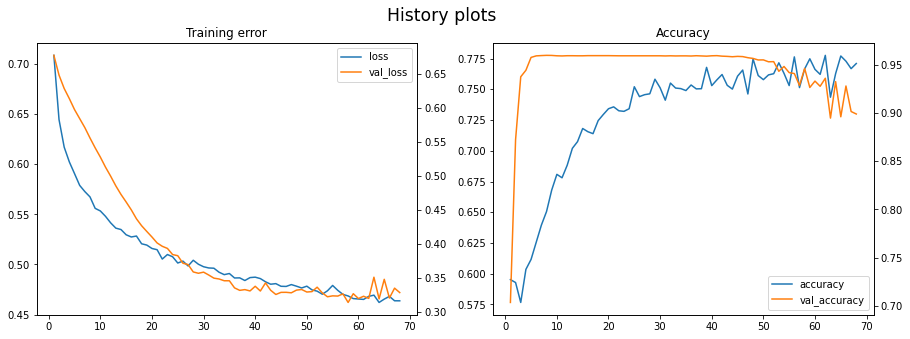



              precision    recall  f1-score   support

           0       0.98      0.91      0.94      9572
           1       0.21      0.51      0.30       428

    accuracy                           0.90     10000
   macro avg       0.59      0.71      0.62     10000
weighted avg       0.94      0.90      0.92     10000

Accuracy: 	89.63%



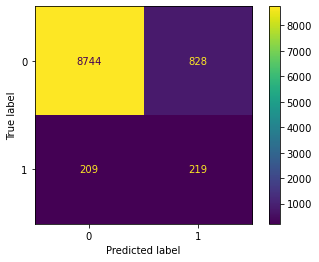

In [140]:
# triangulair model met early stopping
# Early stopping en modelcheckpoint instellen
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
checkpoint_filepath = './bestmodelcs'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                        save_weights_only=True, 
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True)

model = Sequential()
model.add(Dense(units=100, input_dim=X_train_ss.shape[1],
                activation="relu",
                kernel_initializer="random_uniform",
                bias_initializer="zeros"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(units=50, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(units=2, activation="softmax"))

model.compile(loss='binary_crossentropy', 
              optimizer="adam",#lr=0.0001),
              metrics=['accuracy'])

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights,
                    callbacks=[es,mc])

epochs = len(history.history['loss'])

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

Met early stopping kan de accuracy van het model worden verhoogd tot 89.63%. Het gaat hier echter om de gewichten van de laatste epoch.

### Evaluatie van het finale model
Omdat vorige metrics gebaseerd zijn op de gewichten van het laatste epoch, worden voor de finale evaluatie de gewichten van het beste model geladen en geëvalueerd.



              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9572
           1       0.60      0.01      0.01       428

    accuracy                           0.96     10000
   macro avg       0.78      0.50      0.50     10000
weighted avg       0.94      0.96      0.94     10000

Accuracy: 	95.73%



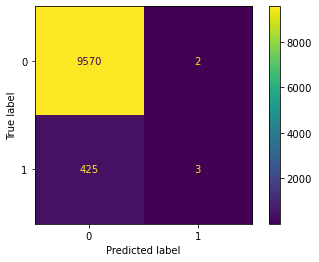

In [141]:
model.load_weights(checkpoint_filepath)

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

**Conclusie beste model**  
Het beste model haalt uiteindelijk een accuraatheid van 95,73%, maar het valt al snel op dat dit model weinig heeft geleerd. Het klasseert alles als categorie 0, hetgeen een duidelijke effect is van de ongebalanceerdheid van de data. Hoewel de accuraatheid hoog is, faalt dit model in het opsporen van klasse 1, namelijk de ontevreden klanten. Er wordt nog even onderzocht of oversampling een positieve invloed zou hebben.

In [143]:
from imblearn.over_sampling import BorderlineSMOTE
X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X_train_ss, y_train_orig)

y_resampled_orig = y_resampled
y_resampled = to_categorical(y_resampled)

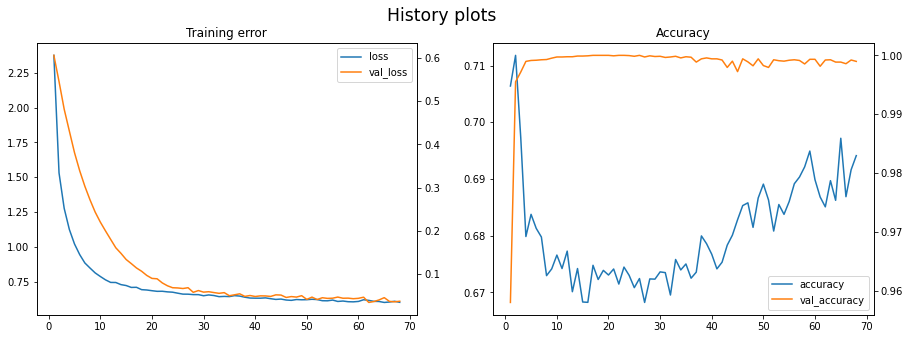



              precision    recall  f1-score   support

           0       0.99      0.51      0.68      9572
           1       0.08      0.89      0.14       428

    accuracy                           0.53     10000
   macro avg       0.53      0.70      0.41     10000
weighted avg       0.95      0.53      0.65     10000

Accuracy: 	52.81%



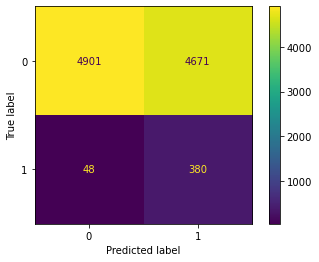

In [144]:
# triangulair model met early stopping
# Early stopping en modelcheckpoint instellen
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
checkpoint_filepath = './bestmodelcs'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                        save_weights_only=True, 
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True)

model = Sequential()
model.add(Dense(units=100, input_dim=X_train_ss.shape[1],
                activation="relu",
                kernel_initializer="random_uniform",
                bias_initializer="zeros"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(units=50, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(units=2, activation="softmax"))

model.compile(loss='binary_crossentropy', 
              optimizer="adam",#lr=0.0001),
              metrics=['accuracy'])

history = model.fit(X_resampled, 
                    y_resampled, 
                    epochs=epochs, 
                    batch_size = 10000, 
                    validation_split = 0.2, 
                    verbose=0,
                    class_weight=class_weights,
                    callbacks=[es,mc])

epochs = len(history.history['loss'])

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

### Conclusie
Na oversampling daalt de accuracy tot 52.81%. Het model blijft nog steeds onbruikbaar voor de gegeven vraagstelling. Nieuwe sampling van data met aandacht aan ontevreden klanten, kan een groot deel van de de problemen bij de modellen verhelpen. Na oversampling

## Zalando 

Fashion-MNIST is een dataset van Zalando bestaande uit afbeeldingen van kledij. De training set ('fashion-mnist_train.csv') bestaat uit 60000 afbeeldingen, de test set ('fashion-mnist_test.csv') uit 10000 afbeeldingen.
Elke grijsafbeelding is 28x28 pixels groot en is toegewezen aan één van de 10 klasses: 

0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'.

Train een neuraal netwerk dat een zo hoog mogelijke accuracy score behaalt op de test set.
Eén optie is om als features de ruwe pixeldata (784 pixels) te gebruiken. Een andere benadering is om via Principle Component Analysis (PCA) de featureset te reduceren en daarmee als het ware feature extraction toe te passen.
Onderzoek welke afbeeldingen niet correct werden geclassificeerd en visualiseer ze.

Tijdens de volgende sessie zullen we op dezelfde dataset convolutional neural networks toepassen. Deze neurale netwerk architectuur leent zich uitstekend voor image classification.

Vergelijk jouw eigen accuracy score met deze opgelijst op https://github.com/zalandoresearch/fashion-mnist.


In [20]:
df_train = pd.read_csv('./fashion-mnist_train.csv')
df_test = pd.read_csv('./fashion-mnist_test.csv')
df_train.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

### Gebalanceerdheid onderzoeken
In een eerste stap wordt onderzocht of de data gebalanceerd is.

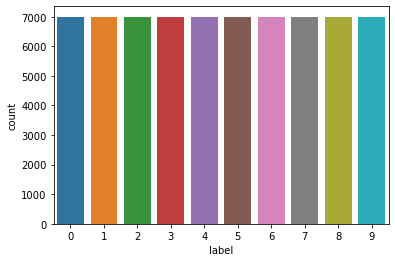

In [21]:
df_all = pd.concat([df_train, df_test])
sns.countplot(x='label', data=df_all, saturation=0.75);

**Conclusie gebalanceerdheid**  
De data is uitermate gebalanceerd.

### Statistische vooranalyse en preprocessing
Volgende stappen worden doorlopen:
- Analyse van ontbrekende waarden
- Statistische vooranalyse
- Verwijderen van onnodige features
- Opsplitsen van features en target
- Opsplitsen in training en test set
- Schalen van de features
- One-hot encoding van het target

#### Ontbrekende waarden
Doormiddel van een eigen gemaakte functie wordt onderzocht of er ontbrekende waarden in de dataset zijn.

In [22]:
ismissing(df_all)

Er zijn geen ontbrekende waarden


**Conclusie ontbrekende waarden**  
Er zijn geen ontbrekende waarden in deze dataset. Er moeten bijgevolg geen observaties worden geschrapt. Er zijn tevens geen onnodige features.

#### Opsplitsen van features en target
De dataset wordt gesplitst in target (kolomnaam label) en features (alle andere kolommen)

In [26]:
# Opsplitsen features en target
y_train = df_train['label'].values
y_test = df_test['label'].values
X_train = df_train.drop('label', axis=1)
X_test = df_test.drop('label', axis=1)

In [27]:
X_train.head()

pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       5       0   
3       0       0       0       1       2       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0        0  ...         0         0         0         0         0         0   
1        0  ...         0         0         0         0         0         0   
2        0  ...         0         0         0        30        43         0   
3        0  ...         3         0         0         0         0         1   
4        0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 784 columns]

#### Schalen van de features
StandardScaler wordt gebruikt voor het schalen van de numerieke features met behulp van de ColumnTransformer van SKLearn.

In [28]:
# Schalen van de features
X_train_columns = list(X_train.columns)

ss = ColumnTransformer(transformers = [
    ('scaling', StandardScaler(), X_train_columns),
], remainder ='passthrough')

X_train_ss = pd.DataFrame(ss.fit_transform(X_train), columns=X_train_columns)
X_test_ss = pd.DataFrame(ss.transform(X_test), columns=X_train_columns)

X_train_ss.head()

pixel1    pixel2    pixel3    pixel4    pixel5    pixel6    pixel7  \
0 -0.009505 -0.022693 -0.028907 -0.041557 -0.057575 -0.070503 -0.098084   
1 -0.009505 -0.022693 -0.028907 -0.041557 -0.057575 -0.070503 -0.098084   
2 -0.009505 -0.022693 -0.028907 -0.041557 -0.057575 -0.070503 -0.098084   
3 -0.009505 -0.022693 -0.028907  0.366132  0.406799 -0.070503 -0.098084   
4 -0.009505 -0.022693 -0.028907 -0.041557 -0.057575 -0.070503 -0.098084   

     pixel8    pixel9   pixel10  ...  pixel775  pixel776  pixel777  pixel778  \
0 -0.155981 -0.238546 -0.377959  ... -0.601712 -0.476945 -0.395154 -0.406441   
1 -0.155981 -0.238546 -0.377959  ... -0.601712 -0.476945 -0.395154 -0.406441   
2  0.198798 -0.238546 -0.377959  ... -0.601712 -0.476945 -0.395154  0.275910   
3 -0.155981 -0.238546 -0.377959  ... -0.549579 -0.476945 -0.395154 -0.406441   
4 -0.155981 -0.238546 -0.377959  ... -0.601712 -0.476945 -0.395154 -0.406441   

   pixel779  pixel780  pixel781  pixel782  pixel783  pixel784  
0 -0.440185 -0.396719 -0.287717 -0.158258 -0.091432 -0.033046  
1 -0.440185 -0.396719 -0.287717 -0.158258 -0.091432 -0.033046  
2  0.389449 -0.396719 -0.287717 -0.158258 -0.091432 -0.033046  
3 -0.440185 -0.374570 -0.287717 -0.158258 -0.091432 -0.033046  
4 -0.440185 -0.396719 -0.287717 -0.158258 -0.091432 -0.033046  

[5 rows x 784 columns]

**Conclusie schalen**  
De features zijn succesvol geschaald.

#### One-hot encoding van het target
Doormiddel van de functie 'to_categorical' van Keras wordt het target one-hot geëncodeerd.

In [29]:
y_train = to_categorical(y_train)
print(y_train)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


**Conclusie encoderen target**  
Het target is succesvol one-hot geëncodeerd. De dataset is nu klaar voor het trainen van een neuraal netwerk.

### Creatie en trainen van het neuraal netwerk

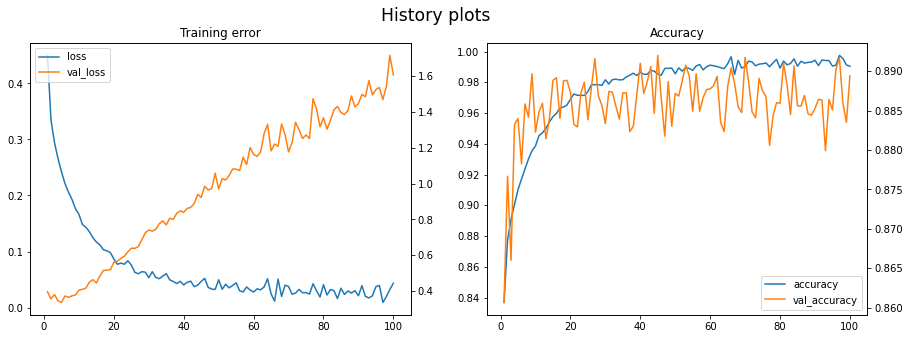



              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.98      0.99      0.98      1000
           2       0.82      0.81      0.82      1000
           3       0.94      0.88      0.91      1000
           4       0.83      0.85      0.84      1000
           5       0.98      0.94      0.96      1000
           6       0.72      0.71      0.72      1000
           7       0.93      0.95      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.94      0.95      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy: 	89.24%



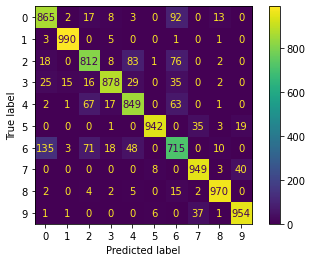

In [39]:
input_dim = X_train_ss.shape[1]
output_dim = y_train.shape[1]

epochs = 100
n_hidden = 1
neurons = 256


model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.0,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='categorical_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 64, 
                    validation_split = 0.2, 
                    verbose=0)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

In een eerste poging wordt gemerkt dat de loss-functie zeer sterk oscilleert en het model niet leert ten opzichte van de validatieset. De learning rates worden met andere woorden niet optimaal bepaald. Dit kan worden opgelost op 2 manieren: batch_size verhogen of meer diepte gang toevoegen. Er wordt eerst gestart met de batch_size verhogen.

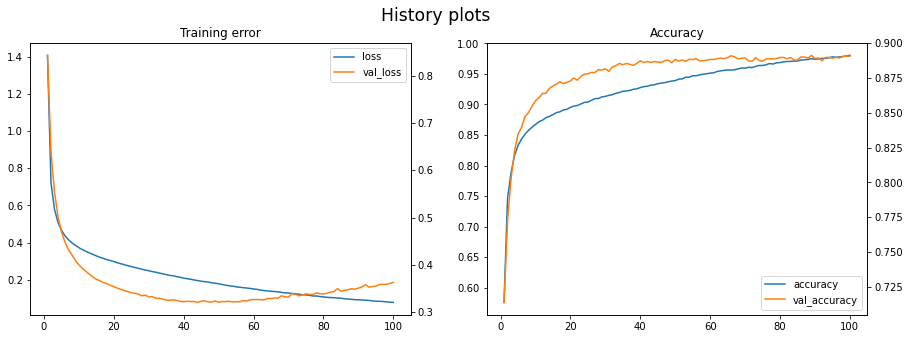



              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.98      0.98      0.98      1000
           2       0.84      0.82      0.83      1000
           3       0.90      0.92      0.91      1000
           4       0.85      0.84      0.85      1000
           5       0.97      0.95      0.96      1000
           6       0.74      0.73      0.73      1000
           7       0.94      0.93      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy: 	89.71000000000001%



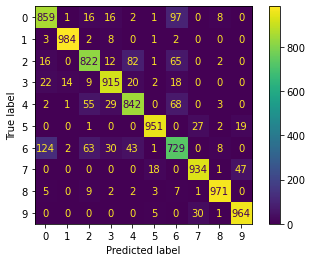

In [30]:
input_dim = X_train_ss.shape[1]
output_dim = y_train.shape[1]

epochs = 100
n_hidden = 1
neurons = 256


model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.0,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='categorical_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 6000, 
                    validation_split = 0.2, 
                    verbose=0)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

De batch_size verhogen heeft het gewenste effect. Het model leert nu ook beter ten opzichte van de validatieset en de history-curves oscilleren nu veel minder. Er is reeds een goede accuracy op de test set. De loss- en accuracy-functies laten echter zien dat er belangrijke overfitting optreedt. Het aantal neuronen worden verminderd om overfitting tegen te gaan.

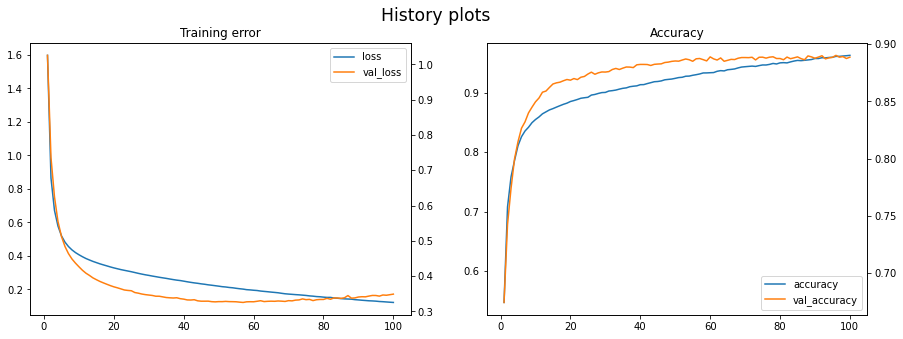



              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.81      0.84      0.83      1000
           3       0.90      0.90      0.90      1000
           4       0.84      0.84      0.84      1000
           5       0.96      0.94      0.95      1000
           6       0.75      0.70      0.72      1000
           7       0.94      0.91      0.93      1000
           8       0.98      0.97      0.97      1000
           9       0.92      0.97      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy: 	89.12%



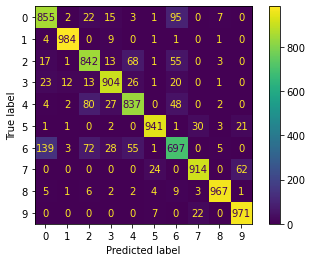

In [34]:
input_dim = X_train_ss.shape[1]
output_dim = y_train.shape[1]

epochs = 100
n_hidden = 1
neurons = 150


model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.0,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='categorical_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 6000, 
                    validation_split = 0.2, 
                    verbose=0)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

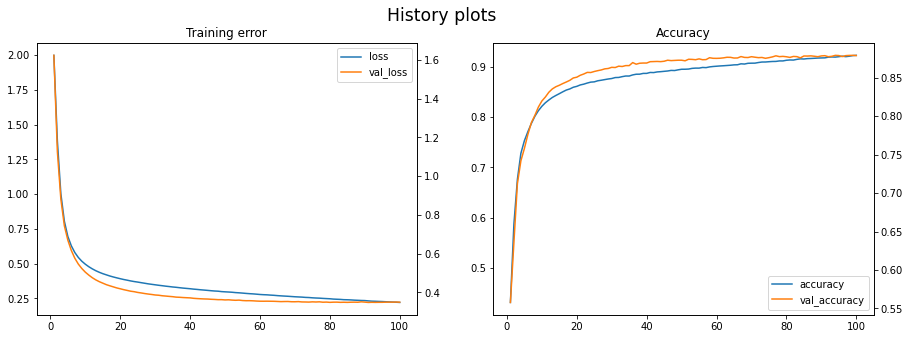



              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.82      0.81      0.81      1000
           3       0.89      0.91      0.90      1000
           4       0.81      0.85      0.83      1000
           5       0.96      0.92      0.94      1000
           6       0.74      0.66      0.70      1000
           7       0.90      0.94      0.92      1000
           8       0.96      0.97      0.96      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Accuracy: 	88.32%



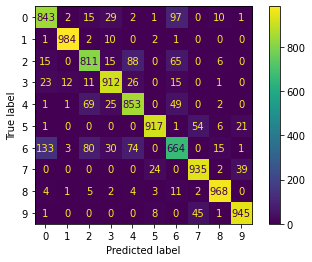

In [35]:
input_dim = X_train_ss.shape[1]
output_dim = y_train.shape[1]

epochs = 100
n_hidden = 1
neurons = 50


model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.0,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='categorical_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 6000, 
                    validation_split = 0.2, 
                    verbose=0)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

Bij een vermindering tot 150 neuronen is er nog steeds overfitting. Het is pas bij 50 neuronen, waarbij de overfitting wat wordt weggewerkt, maar dit heeft een negatieve invloed op de uiteindelijke accuracy (89% tot 88%). In een volgende poging wordt dropout toegepast.

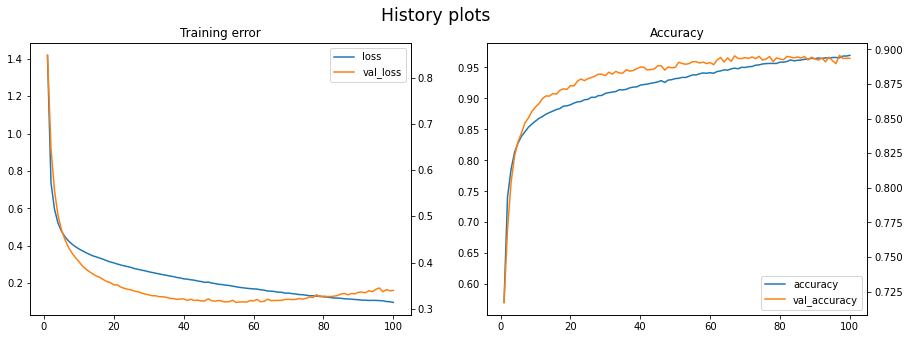



              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.98      0.98      0.98      1000
           2       0.82      0.83      0.83      1000
           3       0.91      0.91      0.91      1000
           4       0.84      0.86      0.85      1000
           5       0.97      0.94      0.96      1000
           6       0.77      0.73      0.75      1000
           7       0.94      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy: 	90.06%



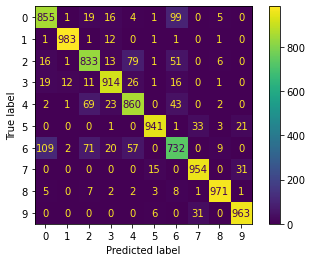

In [36]:
input_dim = X_train_ss.shape[1]
output_dim = y_train.shape[1]

epochs = 100
n_hidden = 1
neurons = 256


model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.1,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='categorical_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 6000, 
                    validation_split = 0.2, 
                    verbose=0)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

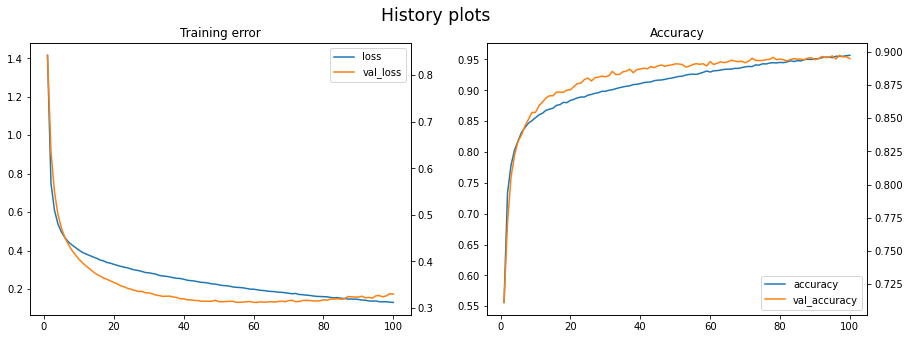



              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       0.98      0.99      0.98      1000
           2       0.84      0.83      0.83      1000
           3       0.91      0.93      0.92      1000
           4       0.84      0.88      0.86      1000
           5       0.97      0.95      0.96      1000
           6       0.76      0.72      0.74      1000
           7       0.94      0.95      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.96      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy: 	90.09%



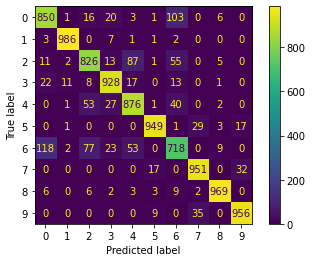

In [37]:
input_dim = X_train_ss.shape[1]
output_dim = y_train.shape[1]

epochs = 100
n_hidden = 1
neurons = 256


model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.3,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='categorical_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 6000, 
                    validation_split = 0.2, 
                    verbose=0)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

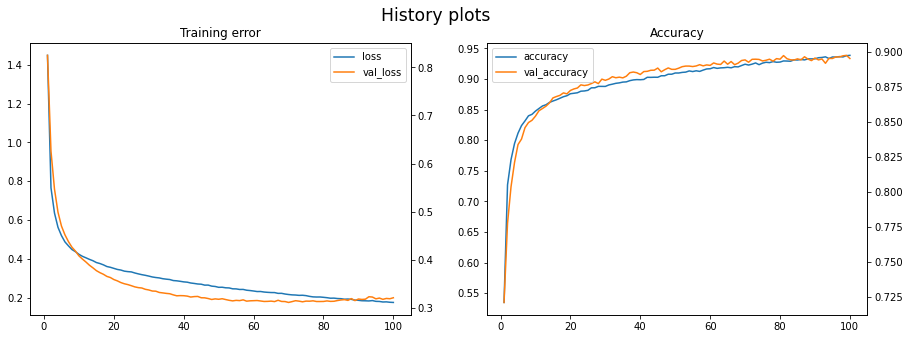



              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1000
           1       0.98      0.98      0.98      1000
           2       0.86      0.81      0.84      1000
           3       0.92      0.91      0.92      1000
           4       0.83      0.87      0.85      1000
           5       0.97      0.94      0.95      1000
           6       0.76      0.71      0.73      1000
           7       0.93      0.94      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.93      0.96      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy: 	89.8%



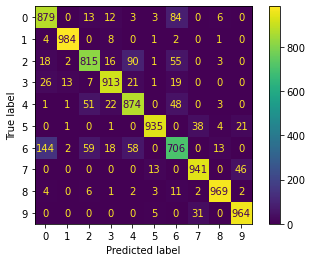

In [38]:
input_dim = X_train_ss.shape[1]
output_dim = y_train.shape[1]

epochs = 100
n_hidden = 1
neurons = 256


model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.5,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='categorical_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 6000, 
                    validation_split = 0.2, 
                    verbose=0)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

Een drop out van 50% lijkt de overfitting het beste tegen te werken. De uiteindelijek accuracy begint te naderen tot 90%. Er wordt nu getracht om meer hidden layers toe te voegen.

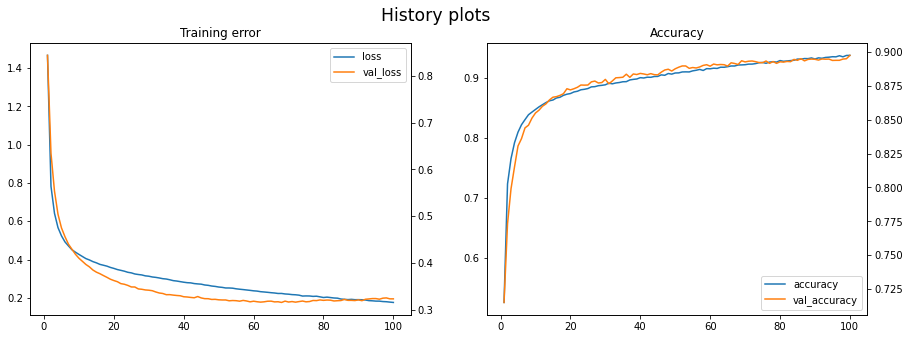



              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.85      0.82      0.84      1000
           3       0.91      0.92      0.91      1000
           4       0.85      0.86      0.85      1000
           5       0.96      0.95      0.96      1000
           6       0.76      0.71      0.73      1000
           7       0.94      0.94      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy: 	89.81%



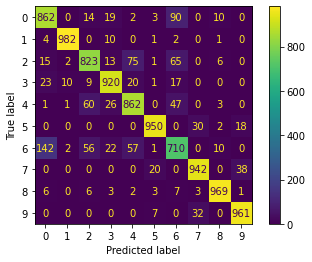

In [40]:
input_dim = X_train_ss.shape[1]
output_dim = y_train.shape[1]

epochs = 100
n_hidden = 2
neurons = 256


model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.5,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='categorical_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 6000, 
                    validation_split = 0.2, 
                    verbose=0)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

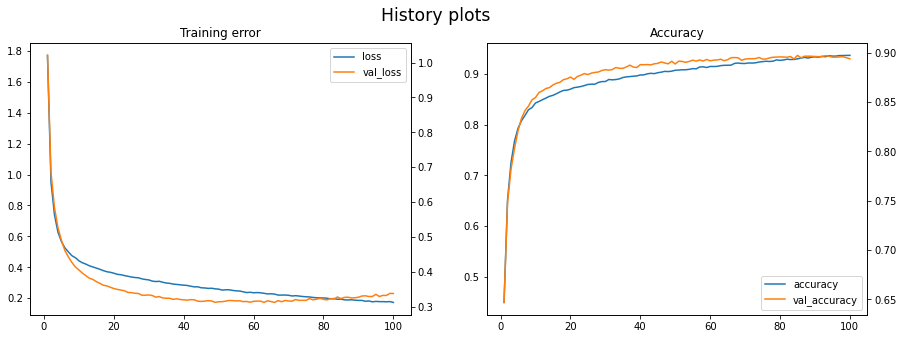



              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.87      0.81      0.84      1000
           3       0.91      0.92      0.92      1000
           4       0.83      0.89      0.86      1000
           5       0.96      0.94      0.95      1000
           6       0.75      0.71      0.73      1000
           7       0.94      0.94      0.94      1000
           8       0.97      0.96      0.97      1000
           9       0.93      0.97      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy: 	89.75%



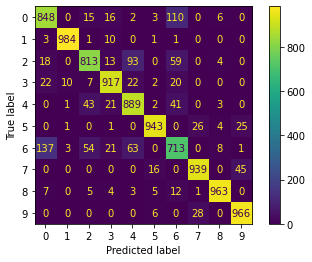

In [42]:
input_dim = X_train_ss.shape[1]
output_dim = y_train.shape[1]

epochs = 100
n_hidden = 3
neurons = 256


model = create_model(optimizer="adam", 
                     neurons=neurons,
                     dropout=0.5,
                     initializer='RandomUniform',
                     activation_hidden='relu', 
                     n_hidden=n_hidden, 
                     batch_norm=0,
                     input_dim = X_train_ss.shape[1],
                     output_dim = y_train.shape[1],
                     loss='categorical_crossentropy',
                     metrics='accuracy')

history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 6000, 
                    validation_split = 0.2, 
                    verbose=0)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

Bij 2 hidden layers is het nog niet zo zichtbaar, maar vanaf 3 hidden layers is er overduidelijke overfitting aan het optreden in de latere epochs. Tot nu toe werd steeds een rechthoekig feed forward netwerk gemaakt. Het doel is nu om de opeenvolgende hidden layers steeds kleiner te maken en een meer triangulair aspect te creëren.

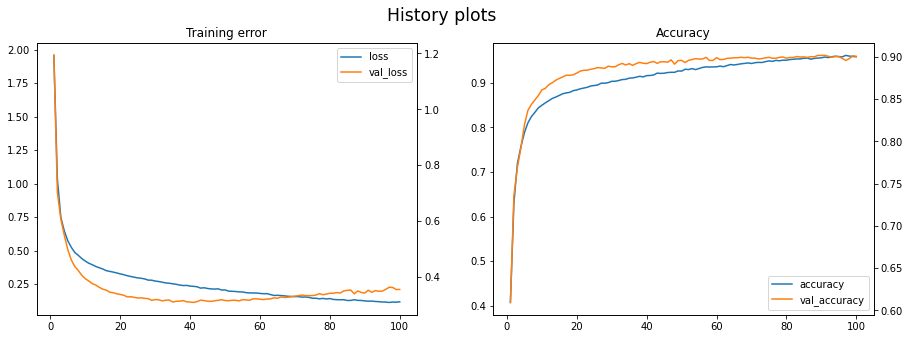



              precision    recall  f1-score   support

           0       0.80      0.89      0.85      1000
           1       0.98      0.98      0.98      1000
           2       0.84      0.84      0.84      1000
           3       0.91      0.93      0.92      1000
           4       0.85      0.88      0.86      1000
           5       0.97      0.95      0.96      1000
           6       0.78      0.68      0.73      1000
           7       0.93      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy: 	90.22%



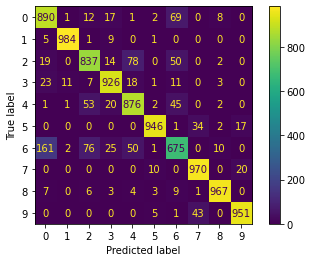

In [44]:
model = Sequential()
model.add(Dense(units=500, input_dim=X_train_ss.shape[1],
                activation="relu",
                kernel_initializer="random_uniform",
                bias_initializer="zeros"))
model.add(Dropout(0.50))
model.add(Dense(units=250, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.25))
model.add(Dense(units=125, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.12))
model.add(Dense(units=50, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.05))

model.add(Dense(units=10, activation="softmax"))

model.compile(loss='categorical_crossentropy', 
              optimizer="adam",#lr=0.0001),
              metrics=['accuracy'])


history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 6000, 
                    validation_split = 0.2, 
                    verbose=0)

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

Het model overstijgt nu een accuracy van 90% op de test set. Er is echter nog steeds belangrijke overfitting. In een volgende stap wordt het model vroegtijdig afgebroken (EarlyStopping)

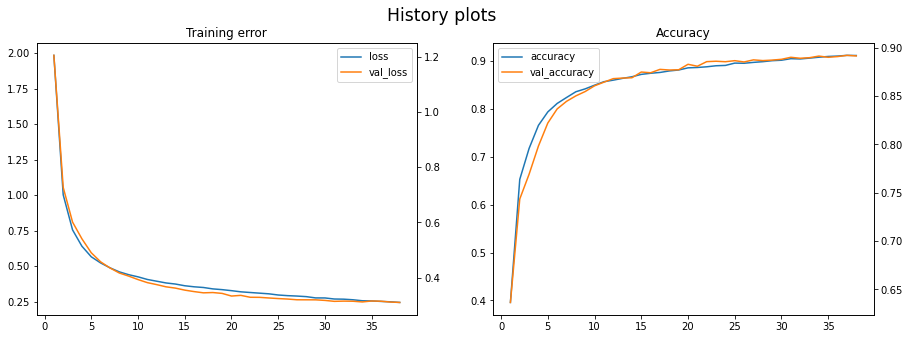



              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.87      0.79      0.83      1000
           3       0.90      0.93      0.91      1000
           4       0.84      0.86      0.85      1000
           5       0.97      0.95      0.96      1000
           6       0.73      0.72      0.72      1000
           7       0.94      0.95      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy: 	89.61%



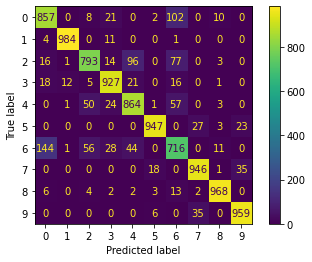

In [53]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
checkpoint_filepath = './bestmodel'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                        save_weights_only=True, 
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True)

model = Sequential()
model.add(Dense(units=500, input_dim=X_train_ss.shape[1],
                activation="relu",
                kernel_initializer="random_uniform",
                bias_initializer="zeros"))
model.add(Dropout(0.50))
model.add(Dense(units=250, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.25))
model.add(Dense(units=125, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.12))
model.add(Dense(units=50, activation="relu", kernel_initializer="random_uniform", bias_initializer="zeros"))
model.add(Dropout(0.05))

model.add(Dense(units=10, activation="softmax"))

model.compile(loss='categorical_crossentropy', 
              optimizer="adam",#lr=0.0001),
              metrics=['accuracy'])


history = model.fit(X_train_ss, 
                    y_train, 
                    epochs=epochs, 
                    batch_size = 6000, 
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[es,mc])

epochs = len(history.history['loss'])

model_history(epochs, 
              metric1='loss', 
              metric2='accuracy')

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

### Evaluatie van het finale model
De vorige model evaluatie betreft het model van de laatste epoch. In de volgende stap worden de gewichten van het beste model bij earlystopping geladen en geëvalueerd.



              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.88      0.79      0.83      1000
           3       0.90      0.93      0.91      1000
           4       0.85      0.85      0.85      1000
           5       0.98      0.94      0.96      1000
           6       0.71      0.72      0.72      1000
           7       0.93      0.94      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy: 	89.51%



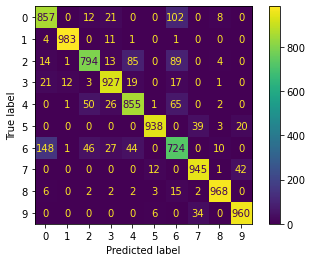

In [54]:
# Create model met beste parameters
model.load_weights(checkpoint_filepath)

model_evaluation(estimator = model, 
                 y_test = y_test,
                 X_test = X_test_ss)

**Conclusie beste model**  
Het uiteindelijke model van de checkpoint presteert toch net iets minder dan deze van de laatste epoch bij early stopping. Toch zitten allen in dezelfde range van ongeveer 89.5%. Gezien de accuracy nooit echt sterk heeft verbeterd wordt dit laatste model gebruikt om enkele verkeerd geclassificeerde beelden te visualiseren.

### Visualisatie van verkeerd geclassificeerde beelden
De verkeerd geklassificeerde beelden worden geïdentificeerd. Voor 3 hiervan worden de afbeeldingen met behulp van de pixeldata weergegeven.

In [87]:
y_pred = np.argmax(model.predict(X_test_ss), axis=-1)

wrong_arr = []
wrong_labels = []
right_labels = []

for i in range(0, len(X_test)):
    if y_pred[i] != y_test[i]:
        wrong_row = np.array(X_test.iloc[[i]])
        wrong_arr.append(wrong_row)
        wrong_label = y_pred[i]
        wrong_labels.append(wrong_label)
        right_label = y_test[i]
        right_labels.append(right_label)

label_map = {0: 'T-shirt/top', 
             1: 'Trouser', 
             2: 'Pullover', 
             3: 'Dress', 
             4: 'Coat', 
             5: 'Sandal', 
             6: 'Shirt', 
             7: 'Sneaker', 
             8: 'Bag', 
             9: 'Ankle boot'}

Voorbeeld van verkeerd geklassificeerde afbeelding 0
----------------------------------------------------


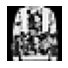

De correcte categorie van deze afbeelding:	categorie 2	Pullover
Deze afbeelding werd geclassificeerd als:	categorie 6	Shirt


Voorbeeld van verkeerd geklassificeerde afbeelding 1
----------------------------------------------------


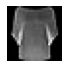

De correcte categorie van deze afbeelding:	categorie 2	Pullover
Deze afbeelding werd geclassificeerd als:	categorie 6	Shirt


Voorbeeld van verkeerd geklassificeerde afbeelding 2
----------------------------------------------------


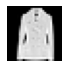

De correcte categorie van deze afbeelding:	categorie 4	Coat
Deze afbeelding werd geclassificeerd als:	categorie 6	Shirt




In [94]:
for n in range(0,3):
    header = f'Voorbeeld van verkeerd geklassificeerde afbeelding {n}'
    headlen = len(header)
    line = '-' * headlen
    print(header, line, sep="\n")
    plt.rcParams["figure.figsize"] = (1,1)
    plt.imshow(wrong_arr[n].reshape((28,28)),cmap = 'gray')
    plt.axis('off')
    plt.show()
    print(f'De correcte categorie van deze afbeelding:\tcategorie {right_labels[n]}\t{label_map[right_labels[n]]}')
    print(f'Deze afbeelding werd geclassificeerd als:\tcategorie {wrong_labels[n]}\t{label_map[wrong_labels[n]]}')
    print("\n")

**Conclusie verkeerd geklasseerde afbeeldingen**  
Deze 3 afbeeldingen zijn toevallig foutief geklassificeerd als shirt. Kijkend naar het classificatie raport van het model, valt op dat de metrics voor deze categorie het slechtst scoren en dat de klasse shirt dikwijls bijdraagt tot een foutieve classificatie.

### Conclusie
Het finale model behaalde een accuracy van 89.51% en is daarom nog niet geschikt voor gebruik in dagdagelijkse praktijk. Meeste fouten worden veroorzaakt in afbeeldingen die sterk op elkaar gelijken, maar toch tot een andere categorie behoren. De categorie 'shirt' heeft hier vaak een rol in. Dit wordt ook gezien in confusiematrix en de metrics in het classificatierapport van het model aangaande deze categorie. In deze modellen werd steeds de ruwe pixeldata gebruikt. Er werdt geen dimensionaliteitsreductie toegepast. Er wordt uitgekeken naar de volgende sessie voor het toepassen van convolutionele lagen om de classificatie van deze afbeeldingen te verbeteren.